# Data Understanding and Feature Engineering

This Notebook ideally follows the `data_exploration` one.

## Autoreload

Autoreload allows the notebook to dynamically load code: if we update some helper functions *outside* of the notebook, we do not need to reload the notebook.

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
# Uncomment the next line and install the package, in case you don't have it in your environment
#%pip install procyclingstats

In [3]:
import ast
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import procyclingstats as pcs
import re
import seaborn as sns
import sys
import scipy.stats as stats
from sklearn.linear_model import LinearRegression



sys.path.append('../dataset/')
sys.path.append('../utility/')

from utility.data_understanding import *
from utility.overall_utilities import save_plot

In [4]:
IMAGES_DIR = 'Images'

In the `data_exploration` notebook we've assessed the quality of the data, also adressing some problems that were discovered.

### Dataframes

Motivated by the "imputation by scraping", we decided to retrieve data from [procyclingstats](https://www.procyclingstats.com/index.php), which is a trusted source of data on cyclism. <br>
The `procyclingstats` notebook details the process of web scraping and data retrieval & augmentation.

In [5]:
cyclist_df = pd.read_csv(os.path.join('dataset','cyclists_new.csv'))
races_df = pd.read_csv(os.path.join('dataset','races_new.csv'))

The dataframes have to be preprocessed in order to be used

In [6]:
cyclist_df = cyclist_df.drop(columns=['Unnamed: 0'], errors='ignore')
cyclist_df['full_history'] = cyclist_df['full_history'].apply(ast.literal_eval)

In [7]:
races_df = races_df.drop(columns=['Unnamed: 0'], errors='ignore')

In [8]:
cyclist_df.head()

_url                  name  birth_year  weight  height  \
0           bruno-surra           Bruno Surra      1964.0     NaN     NaN   
1            gerard-rue            Gérard Rué      1965.0    74.0   182.0   
2              jan-maas              Jan Maas      1996.0    69.0   189.0   
3  nathan-van-hooydonck  Nathan Van Hooydonck      1995.0    78.0   192.0   
4      jose-felix-parra      José Félix Parra      1997.0    55.0   171.0   

   nationality  points_total  tot_seasons_attended  \
0        Italy          15.0                     2   
1       France        4717.0                    11   
2  Netherlands         315.0                    10   
3      Belgium         953.0                     9   
4        Spain         459.0                     5   

                                        full_history  
0  [{'season': 1989, 'points': 14.0, 'rank': 828}...  
1  [{'season': 1997, 'points': 164.0, 'rank': 257...  
2  [{'season': 2024, 'points': 30.0, 'rank': 990}...  
3  [{'season': 2023, 'points': 298.0, 'rank': 218...  
4  [{'season': 2024, 'points': 197.0, 'rank': 317...

In [9]:
races_df.head()

_url            name stage_type  points  uci_points  \
0  tour-de-france/1978/stage-6  Tour de France         RR   100.0         NaN   
1  tour-de-france/1978/stage-6  Tour de France         RR    70.0         NaN   
2  tour-de-france/1978/stage-6  Tour de France         RR    50.0         NaN   
3  tour-de-france/1978/stage-6  Tour de France         RR    40.0         NaN   
4  tour-de-france/1978/stage-6  Tour de France         RR    32.0         NaN   

     length  climb_total  profile  startlist_quality  average_temperature  \
0  162000.0       1101.0      1.0               1241                  NaN   
1  162000.0       1101.0      1.0               1241                  NaN   
2  162000.0       1101.0      1.0               1241                  NaN   
3  162000.0       1101.0      1.0               1241                  NaN   
4  162000.0       1101.0      1.0               1241                  NaN   

                  date  position           cyclist  cyclist_age  is_tarmac  \
0  1978-07-05 04:02:24         0        sean-kelly         22.0       True   
1  1978-07-05 04:02:24         1  gerrie-knetemann         27.0       True   
2  1978-07-05 04:02:24         2    rene-bittinger         24.0       True   
3  1978-07-05 04:02:24         3    joseph-bruyere         30.0       True   
4  1978-07-05 04:02:24         4  sven-ake-nilsson         27.0       True   

   is_cobbled  is_gravel                    cyclist_team  delta  
0       False      False   team/flandria-velda-lano-1978    0.0  
1       False      False  team/ti-raleigh-mc-gregor-1978    0.0  
2       False      False   team/flandria-velda-lano-1978    0.0  
3       False      False                   team/c-a-1978    0.0  
4       False      False          team/miko-mercier-1978    0.0

## Added features

Let's discuss feature augmentation and feature engineering

### Added features (scraping)

We decided to add the following features, obtained by scraping the website:

For the `cyclists` dataset:
- `full_history`: the rider’s points per season history, obtained by reading the *PCS Ranking position per season* table 
- `points_total`: the rider's points accumulated throughout his career, obtained by summing the values in the aforementioned table
- `tot_season_attended`: the number of seasons ran by the cyclist.<br>
We decided not to use these features for now, because the data they contain comes from many cyclism disciplines, whereas the data at our disposal only includes road races.

For the `races` dataset:
- `stage_type`: can be RR (Road Race), ITT (Individual Time Trial), TTT (Team Time Trial). Obtained from the stage's webpage

The following changes were made, w.r.t. the original `races` dataset:
- The column `name` now has a unique identifier for each race. Races with identical `_url` prefix are the same race, but in the original dataset they might have been referred with multiple names
- The values in the `points` and `uci_points` column  are now those coming from the website. In the original dataset the (UCI) points were those of the first runner-up 
- The values in the `cyclist_team` column are now those coming from the website. 

In [10]:
cyclist_df = cyclist_df.drop(columns=['points_total', 'tot_seasons_attended','full_history'], errors='ignore')
cyclist_df.head()

_url                  name  birth_year  weight  height  \
0           bruno-surra           Bruno Surra      1964.0     NaN     NaN   
1            gerard-rue            Gérard Rué      1965.0    74.0   182.0   
2              jan-maas              Jan Maas      1996.0    69.0   189.0   
3  nathan-van-hooydonck  Nathan Van Hooydonck      1995.0    78.0   192.0   
4      jose-felix-parra      José Félix Parra      1997.0    55.0   171.0   

   nationality  
0        Italy  
1       France  
2  Netherlands  
3      Belgium  
4        Spain

### Other added features (races, not scraped)

By comparing the values with the website, we noticed that the `date` column includes the date of the competition and the time the cyclist took to complete the race. So we disentangle such values.

In [11]:
races_df['time'] = races_df['date'].apply(lambda string: string.split(' ')[1])
races_df['date'] = races_df['date'].apply(lambda string: string.split(' ')[0])

In [12]:
races_df['time_seconds'] = races_df['time'].apply(lambda x: sum(int(t) * 60**i for i, t in enumerate(reversed(x.split(':')))))

Speed. The be all end all of any metric. We can obviously only calculate a mean of it. 

In [13]:
races_df['average_speed'] = races_df['length'] / races_df['time_seconds']

#### Steepness

Another feature is the ratio between the vertical meters and the length of the stage, in percentage. This is a "climb density", or steepness.

In [14]:
races_df['steepness'] = 100*races_df['climb_total']/races_df['length']

#### Season

We also add the season in which a race is ran, by looking at the date.

In [15]:
# 0: winter, 1: spring, 2: summer, 3: fall
races_df['season'] = races_df['date'].apply(lambda data: (int(data.split('-')[1])//3)%4)

#### `is_staged`

Some competitions are composed of multiple stages, each of which is ran in a different day. One example of this is the Giro d'Italia. Some other are ran in a single stage (that takes a single day), one example being the Ronde van Vlaanedren.

In [16]:
races_df['is_staged'] = races_df['_url'].apply(lambda race_url: bool(re.match(r"[a-z0-9-]+/\d{4}/(prologue|stage-\d)",race_url)))

In [17]:
gare_non_tappe = np.unique([gara.split('/')[0] for gara in races_df.loc[races_df['is_staged'] == False,'_url'].unique()])
gare_tappe = np.unique([gara.split('/')[0] for gara in races_df.loc[races_df['is_staged'],'_url'].unique()])

print(f"Non-staged races: {gare_non_tappe}")
print()
print(f"Staged races: {gare_tappe}")

Non-staged races: ['amstel-gold-race' 'dwars-door-vlaanderen' 'e3-harelbeke' 'gp-montreal'
 'gp-quebec' 'il-lombardia' 'la-fleche-wallone' 'liege-bastogne-liege'
 'milano-sanremo' 'omloop-het-nieuwsblad' 'paris-roubaix'
 'ronde-van-vlaanderen' 'san-sebastian' 'strade-bianche'
 'world-championship']

Staged races: ['dauphine' 'giro-d-italia' 'gran-camino' 'itzulia-basque-country'
 'paris-nice' 'tirreno-adriatico' 'tour-de-france' 'tour-de-romandie'
 'tour-de-suisse' 'uae-tour' 'volta-a-catalunya' 'vuelta-a-espana']


Some competitions take place in the same location each year, while others change location each year.

In [18]:
# Mmm I don't know how to do this... Domain knowledge?

#### Country of the competition

Another trivial yet interesting feature is the country in which the competition is held. It's domain knowledge, summarized in the following dictionary.

**OSS**: This dictionary, and the following cells that create the `race_country` column, use the values of the `name` column in the `races_new.csv` file! 

In [19]:
# For this dictionary I use the names in the races_new.csv format!
country_competition_dict = {
    'France' : ['Tour de France', 
                'Paris - Nice',
                'Criterium du Dauphiné',
                'Paris - Roubaix'],
    'Spain' : ['La Vuelta ciclista a España',
                'Volta Ciclista a Catalunya',
                'Gran Camiño',
                'Itzulia Basque Country',
                'Clasica Ciclista San Sebastian'],
    'Italy' : ['Tirreno-Adriatico', 
               'Milano-Sanremo',
               "Giro d'Italia",
               'Monte Paschi Eroica', 
               'Giro di Lombardia'],
    'Belgium' : ['Ronde van Vlaanderen - Tour des Flandres ME',
                 'La Flèche Wallonne',
                 'E3 BinckBank Classic',
                 'Liège - Bastogne - Liège',
                 'Dwars door België / À travers la Belgique',
                 'Omloop Het Nieuwsblad ME'
                 ],
    'Netherlands' :['Amstel Gold Race'],
    'Switzerland' : ['Tour de Suisse',
                     'Tour de Romandie'],
    'UAE' : ['UAE Tour'],
    'Canada' : ['Grand Prix Cycliste de Quebec', 
                'Grand Prix Cycliste de Montréal']
    # 'World Championships - Road Race' doesn't take place in a fixed country
}

In [20]:
def coutry_returner(race_name:str,
        countries_races_dict:dict[str,list[str]] = country_competition_dict) -> str:
    for country, names_list in countries_races_dict.items():
        if race_name in names_list:
            return country
    return np.nan

races_df['race_country'] = races_df['name'].apply(coutry_returner)

#### Normalized scores

Now, we'll try to infer some value regarding the performance of each individual cyclist at a given age. 
We try to compute an age performance index: it will assign greater values based on the points and the oldness of the cyclist at a given race.

In [21]:
# First, we normalize the scores
races_df['norm_points'] = races_df.groupby('_url')['points'].transform(
    lambda x: (x - x.mean()) / x.std()
)
# Then, we multiply by age
races_df['age_performance_index'] = races_df['norm_points'] * races_df['cyclist_age']

Now, we are going to do the same process for the `startlist_quality`. By engineering this feature, we may infer a set of points to assign to each race that is more nuanced towards the expertise of the cyclists that will participate in it.

In [22]:
races_df['quality_adjusted_points'] = races_df['norm_points'] * races_df['startlist_quality']

Now we'll define a feature to better determine a stamina indicator for each race. We want to take into account any factor that might indicate the need of a better stamina.

In [23]:
races_df['normalized_length'] = races_df['length'] / races_df['length'].max()
races_df['normalized_quality'] = (races_df['startlist_quality'] / races_df['startlist_quality'].max()) * 10
races_df['normalized_steepness'] = races_df['steepness'] / races_df['steepness'].max()
races_df['normalized_time'] = races_df['time_seconds'] / races_df['time_seconds'].max()

races_df['stamina_index'] = np.where(
    races_df['normalized_steepness'].notna(),
    ((races_df['average_speed'] * races_df['normalized_length'] / 1+ races_df['normalized_time']) *
     (1 + races_df['normalized_steepness']) *
     (1 + (races_df['normalized_quality']) / (1+ races_df['position']))),
    np.nan  # Set to NaN where `normalized_steepness` is null
)


### Other added features (cyclists)

#### BMI

We add the BMI (body Mass Index) of each cyclist: the ratio between the weight (kilograms) and the square of the height (meters).

In [24]:
cyclist_df['bmi'] = cyclist_df['weight']/np.square(cyclist_df['height']/100)

#### Experience level

Now, let's try to infer an experience level for the cyclists. We should take into account everything, but to have a relaxed yet probably closer-to-the-truth model we'll only take into account the races that the cyclists ran into.

In [25]:
# Exclude duplicates (sometimes a cyclist appears multiple times in the same race)
race_count = races_df.groupby('cyclist')['_url'].agg(lambda x: len(set(x)))

race_count_df = pd.DataFrame({'_url': race_count.index, 'race_count': race_count.values})
cyclist_df = cyclist_df.merge(right=race_count_df, how='left', on='_url')
cyclist_df['race_count'] = cyclist_df['race_count'].replace(np.nan, 0)

# now with all of our complete, total, absolute domain knowledge we can define the experience levels
experience_levels = ['beginner', 'developing', 'competitive', 'semi-pro', 'pro']
bins = [0, 15, 50, 100, 200, float('inf')]

cyclist_df['experience_level'] = pd.cut(cyclist_df['race_count'], bins=bins, labels=experience_levels, right=False)

#### Total score, victories by points

Now we compute the total score collected by each cyclist throughout his career. That is, we just retrieve all the score of a given cyclist and sum it up. Some comments:
- This analysis is made possible by the use of the scraped version of the dataset, because in it the points are relative to the cyclist's position and not to the stage.
- However, there are many NaNs, because very few cyclists, compared to how many participate to a stage, get points
- *Having the most points in a competition doesn't always imply the victory of that competition*. This is expecially true for the Grand Tours, for example, in the Tour de France the points classification is a minor classification
- Of course, for the single-staged races such as the Paris-Roubaix the cyclist with the highest score is also the first one that arrived, and is also the winner.

In [26]:
punti_totali = races_df.groupby('cyclist')['points'].sum()
cyclist_df['total_points'] = cyclist_df['_url'].apply(lambda x: punti_totali[x] if x in punti_totali.index else 0)

We also add a count of how many *competitions* (not how many stages!) were won by points. As said earlier, a victory by points is not the same as a "true" victory, but it seems like that's the most we can do. In fact, to obtain the "true" victory (in staged races) we should either have
- Domain knowledge, or...
- ... more data (as the "true" victory is a combination of factors)

In [27]:
cyclist_df['victories_by_points'] = 0

def get_base_url(url: str) -> str:
    parts = url.split('/')
    return f"{parts[0]}/{parts[1]}"

# Group by the base URL and cyclist, then sum the points
grouped = races_df.groupby([races_df['_url'].apply(get_base_url), 'cyclist'])['points'].sum()

# Find the top scorer for each base URL. 
# We group by URL (1st level of the multi-index), 
# then we find the index (i.e. the cyclist's url) of the max value (i.e. the points)
top_scorers = grouped.groupby(level=0).idxmax().apply(lambda x: x[1])

# Count the victories by points for each cyclist, by just counting how
# many times they appear in top_scorers
victories_by_points = top_scorers.value_counts()

# Update the cyclist_df with the victories by points
cyclist_df['victories_by_points'] = cyclist_df['_url'].map(victories_by_points).fillna(0).astype(int)

The function above is not 100\% reliable, because in case of ties it's not extremely clear how the function awards the victory. Probably alphabetical. 

In fact, an equivalent method with a `for` loop yielded very similar results, with differences just involving a dozen of cyclist for the reason just described. For example, in the 2020 Giro d'Italia it was Arnaud Démare that won by points, but Filippo Ganna had the same amount of points. The method presented here gives the victory to Démare, but the `for` loop gave it to Ganna.

#### Average points per race

We have the total points accumulated by a cyclist throughout his career, we have the `race_count` feature... It's just natural that we define a `avg_points_per_race` feature!

Being an average, it will retain all strengths and weaknesses of the mean. Cyclists may have a long career, thus a certain amount of points, but some other cyclists may accumulate the same amount of points while racing less.


In [28]:
cyclist_df['avg_points_per_race'] = cyclist_df['total_points'] / cyclist_df['race_count']
cyclist_df['avg_points_per_race'] = cyclist_df['avg_points_per_race'].fillna(0)

#### Average position

Now we compute the average position of each cyclist throughout his career. 
- Albeit interesting, we don't differentiate between the various competitions
- As with all the average, should be taken with a grain of salt. Is really a cyclist that only participated to a single stage of a minor competition and arrived first that better than a cyclist that attended multiple competitions, sometimes not finishing first? 

These two factors limit the strength of any conclusion that we reach by analizing this feature.

In [29]:
posizioni = races_df.groupby('cyclist')['position']
average_position = posizioni.mean()
cyclist_df['average_position'] = cyclist_df['_url'].apply(lambda x: average_position[x] if x in average_position.index else np.nan)

In [30]:
print(f"The cyclist with the lowest average position is {cyclist_df.loc[cyclist_df['_url'] == average_position.idxmin(), 'name'].iloc[0]},")
print(f"with an average position of {average_position.min()}.")

The cyclist with the lowest average position is Adriano Pella,
with an average position of 0.0.


In [31]:
cyclist_df[cyclist_df['_url'] == average_position.idxmin()][['name','race_count','experience_level','total_points','victories_by_points','average_position']]

name  race_count experience_level  total_points  \
2816  Adriano Pella         1.0         beginner          50.0   

      victories_by_points  average_position  
2816                    0               0.0

## Studying the (added?) features

Let's do some data understanding with (also) the new features that we discovered!

### `average_speed`

Let's check what insights we can gain from `average_speed`

In [32]:
races_df['average_speed'].describe()

count    604840.000000
mean         11.006316
std          10.611866
min           0.160154
25%          10.157743
50%          11.006766
75%          11.750510
max        5443.589744
Name: average_speed, dtype: float64

Cool it seems they let F-15s and snails participate in these races.

In [33]:
SPEED_CHECKPOINTS = [0, 3, 5, 22, 60, 500, races_df['average_speed'].max()]

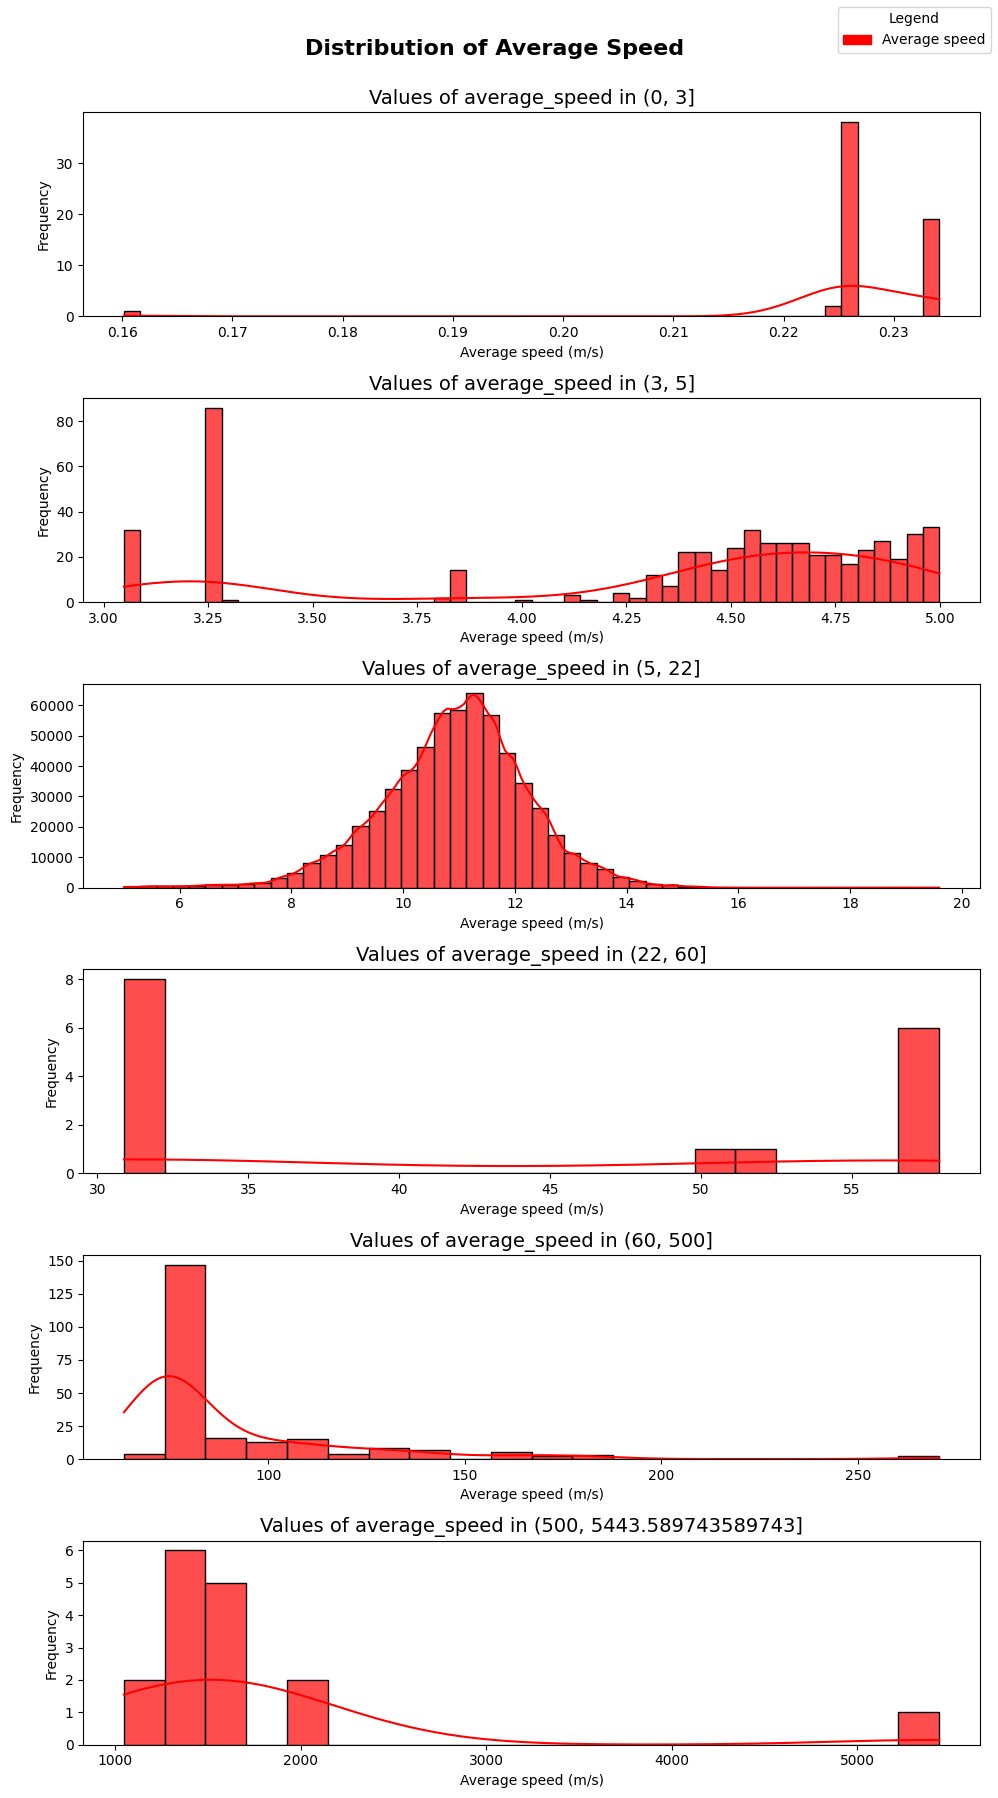

In [34]:
from matplotlib import patches as mpatches

fig, ax = plt.subplots(len(SPEED_CHECKPOINTS) - 1, 1, figsize=(10, 18))
fig.suptitle('Distribution of Average Speed', fontsize=16, fontweight='bold')

for i, (speed_start, speed_end) in enumerate(zip(SPEED_CHECKPOINTS[:-1], SPEED_CHECKPOINTS[1:])):
    sub_df = races_df[(races_df['average_speed'] > speed_start) & (races_df['average_speed'] <= speed_end)]
    
    n_bins = 20 if speed_end >= 60 else 50
    sns.histplot(sub_df['average_speed'], bins=n_bins, kde=True, color='red', alpha=0.7, ax=ax[i], label='Average speed')
    ax[i].set_title(f'Values of average_speed in ({speed_start}, {speed_end}]', fontsize=14)
    ax[i].set_xlabel('Average speed (m/s)')
    ax[i].set_ylabel('Frequency')
    #ax[i].yscale('log')
    #ax[i].legend()

# Add the legend to the figure
fig.legend(handles=[mpatches.Patch(color='red', label='Average speed')], loc='upper right', title='Legend')

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

Who are these guys? What's up with these values??

Upon an in-detail analysis it turned out that:
- Average speeds below 1 solely correspond to the Prologue stages of 1996 and 1997 Tour de Romandie (and also to the "trollino" Riccardo Forconi, but we already know him. It's a duplicate). In particular
    - All the average speeds are below 1 m/s. There are no average speeds actually between 0.25 m/s and 3 m/s
    - All the riders in such races have this low value for `average_speed`. This is due to the fact that the recorded `time`s are 10 hours circa, but the races are only 8.1Km long. This is most probably an error. Such values of time are unreliable.
- There are 11 races in which the average speeds are between 3 m/s and 5 m/s.
    - All of them have a high value of `profile`. Only one is missing, the others are either 3 or 5. This makes sense
    - The distribution of the positions of the cyclists that have such speeds (displayed below) shows that there are some front runners
    - In particular, for three of those 11 races (Stage 16 of 2010's Giro d'Italia, 2011's Gran Prix Cycliste de Québec and Stage 3 of 1999 Volta a Catalunya) there are cyclists that arrived in 10th position or better. These races have a high `profile` value. Moreover, 2011's GP of Québec had been addressed already in the study of the `delta` values 
    - All in all, at this level of analysis (superficial, for what concerns the power of the tools used), nothing seems highly suspicious, or worthy to be removed from the dataset.
- Most of the values for `average_speed` fall between 5 and 22 m/s. 
- The only races in which there appear average speeds between 22 and 60 are Stage 7a of 1990's Paris-Nice, Stage 1 of 1995's Tour de Romandie. 
    - The first one of these has negative deltas, so it will be excluded in the delta-based dataset cleaning
    - The Stage 1 of 1995's Tour de Romandie has no problems such as duplicated cyclists, negative/unordered delta, but the values for the `time` are unreliable, because the race is more than 200Km long, and allegedly it was run in 1hr circa
- There are five races with `average_speed` values greater than 60 m/s: Stage 3 of 1988's Tour de Suisse, Stage 19 of 1992's Vuelta a Espana, Stage 12 of 2003's Tour de France, Stage 10 of 1997's Vuelta a Espana and Stage 4 of 1993's Tour de Suisse.
    - Stage 12 of 2003 Tour de France is a 47Km long ITT stage, with `profile` equal to 2. It is plausible that cyclists completed it in 1 hour. We don't remove it a priori. 
    - The other races are problematic because of the negative delta values

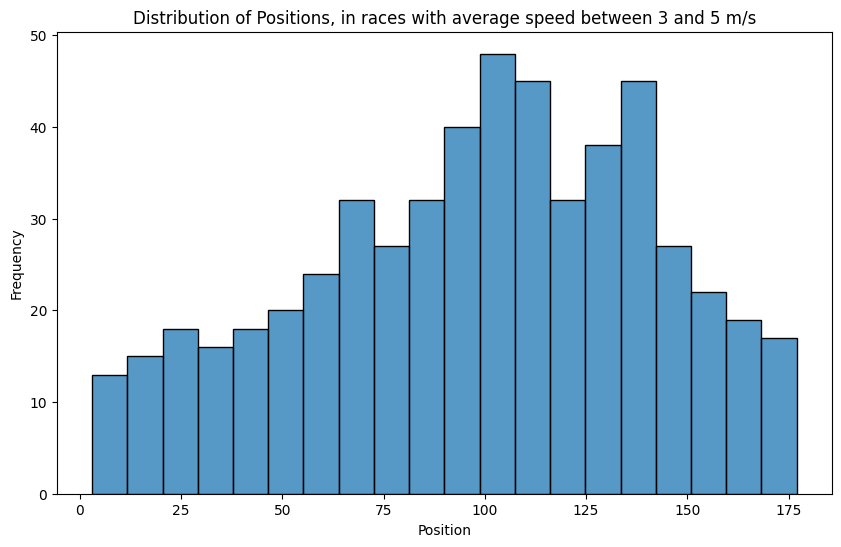

In [35]:
plt.figure(figsize=(10, 6))
sub_df = races_df[(races_df['average_speed'] > 3) & (races_df['average_speed'] <= 5)]

sns.histplot(sub_df['position'], bins=20, edgecolor='black')
plt.title('Distribution of Positions, in races with average speed between 3 and 5 m/s')
plt.xlabel('Position')
plt.ylabel('Frequency')
plt.show()

#### A further look at the `average_speed` distribution

Let's look at the `average_speed` distribution, for values between 3 m/s and 60 m/s

In [36]:
from utility.dataset_cleaning import speed_based_dataset_cleaning

filtered_out_speeds_df = speed_based_dataset_cleaning(dataset=races_df, speed_min=3, speed_max=60, keep_tdf=False)
avg_spd_distribution = filtered_out_speeds_df['average_speed']
avg_spd_distribution.describe()

count    604578.000000
mean         10.931381
std           1.334236
min           3.048298
25%          10.157671
50%          11.006598
75%          11.748646
max          57.903731
Name: average_speed, dtype: float64

In [37]:
avg_spd_distribution[races_df['stage_type'] == 'ITT'].describe()

count    55727.000000
mean        11.455753
std          2.109872
min          4.219823
25%         10.866512
50%         11.964585
75%         12.815851
max         16.341991
Name: average_speed, dtype: float64

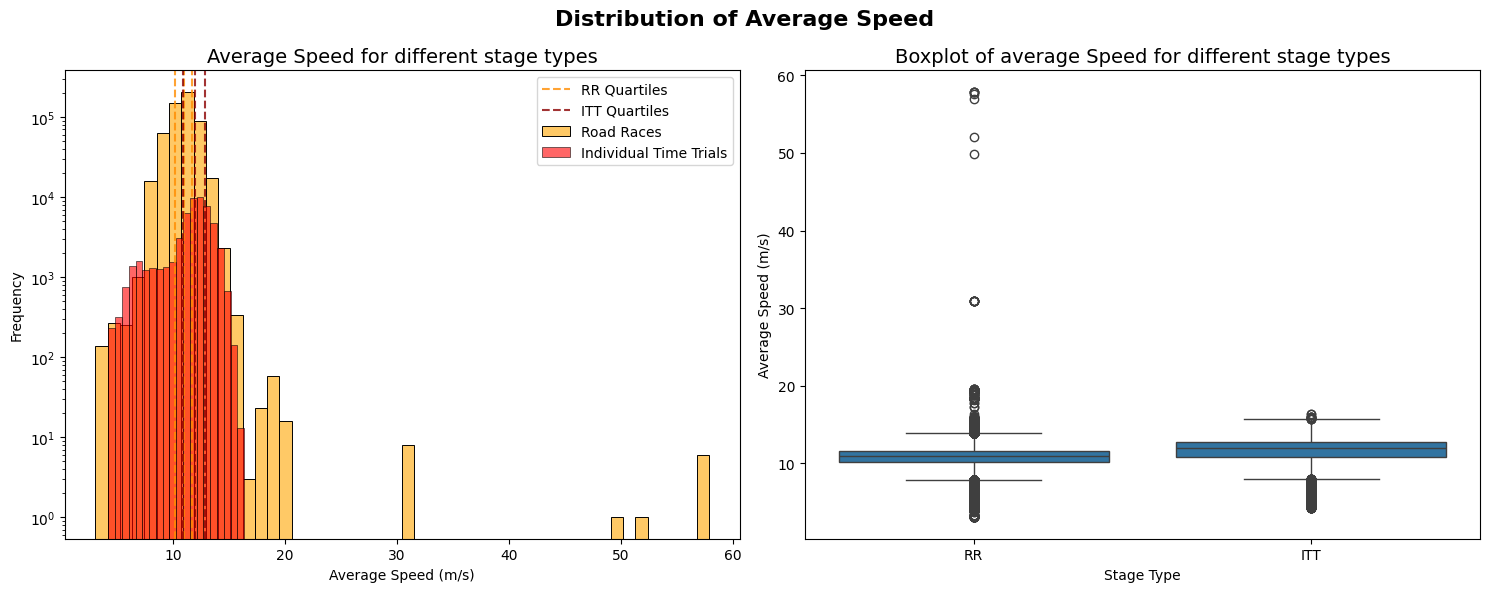

In [38]:
fig, ax = plt.subplots(1,2, figsize=(15, 6))
fig.suptitle('Distribution of Average Speed', fontsize=16, fontweight='bold')

sns.histplot(avg_spd_distribution[filtered_out_speeds_df['stage_type'] == 'RR'], bins=50, kde=False, color='orange', alpha = 0.6, label='Road Races', ax=ax[0])
rr_quartiles = avg_spd_distribution[filtered_out_speeds_df['stage_type'] == 'RR'].quantile([0.25, 0.5, 0.75])

sns.histplot(avg_spd_distribution[filtered_out_speeds_df['stage_type'] == 'ITT'], bins=20, kde=False, color='red', alpha = 0.6, label='Individual Time Trials', ax=ax[0])
itt_quartiles = avg_spd_distribution[filtered_out_speeds_df['stage_type'] == 'ITT'].quantile([0.25, 0.5, 0.75])

# Add vertical lines for Road Races quartiles
for i, q in enumerate(rr_quartiles):
    label = 'RR Quartiles' if i == 0 else None
    ax[0].axvline(q, linestyle='--', color='darkorange', alpha=0.8, label=label)

# Add vertical lines for Individual Time Trials quartiles
for i, q in enumerate(itt_quartiles):
    label = 'ITT Quartiles' if i == 0 else None
    ax[0].axvline(q, linestyle='--', color='darkred', alpha=0.8, label=label)

ax[0].set_title('Average Speed for different stage types', fontsize=14)
ax[0].set_xlabel('Average Speed (m/s)')
ax[0].set_ylabel('Frequency')
ax[0].set_yscale('log')
ax[0].legend()

sns.boxplot(data=filtered_out_speeds_df,
            x='stage_type',
            y='average_speed',
            ax=ax[1])
ax[1].set_title('Boxplot of average Speed for different stage types', fontsize=14)
ax[1].set_xlabel('Stage Type')
ax[1].set_ylabel('Average Speed (m/s)')
#ax[1].set_yscale('log')

plt.tight_layout()
plt.show()

This doesn't look promising. Let's also see the point-biserial correlation.

In [39]:
correlation, _ = stats.pointbiserialr(avg_spd_distribution, filtered_out_speeds_df['stage_type'] == 'RR')
print(f"Point-biserial correlation between the `stage_type` being `RR` and the `average_speed`: {correlation:.3f}")

Point-biserial correlation between the `stage_type` being `RR` and the `average_speed`: -0.125


The value for the point-biserial correlation is close to zero. The two distributions are really superimposed. Being a RR or a ITT doesn't make much of a difference for the average speed of the cyclists. ITT races tend to be rode slightly faster, but this result is not significant.

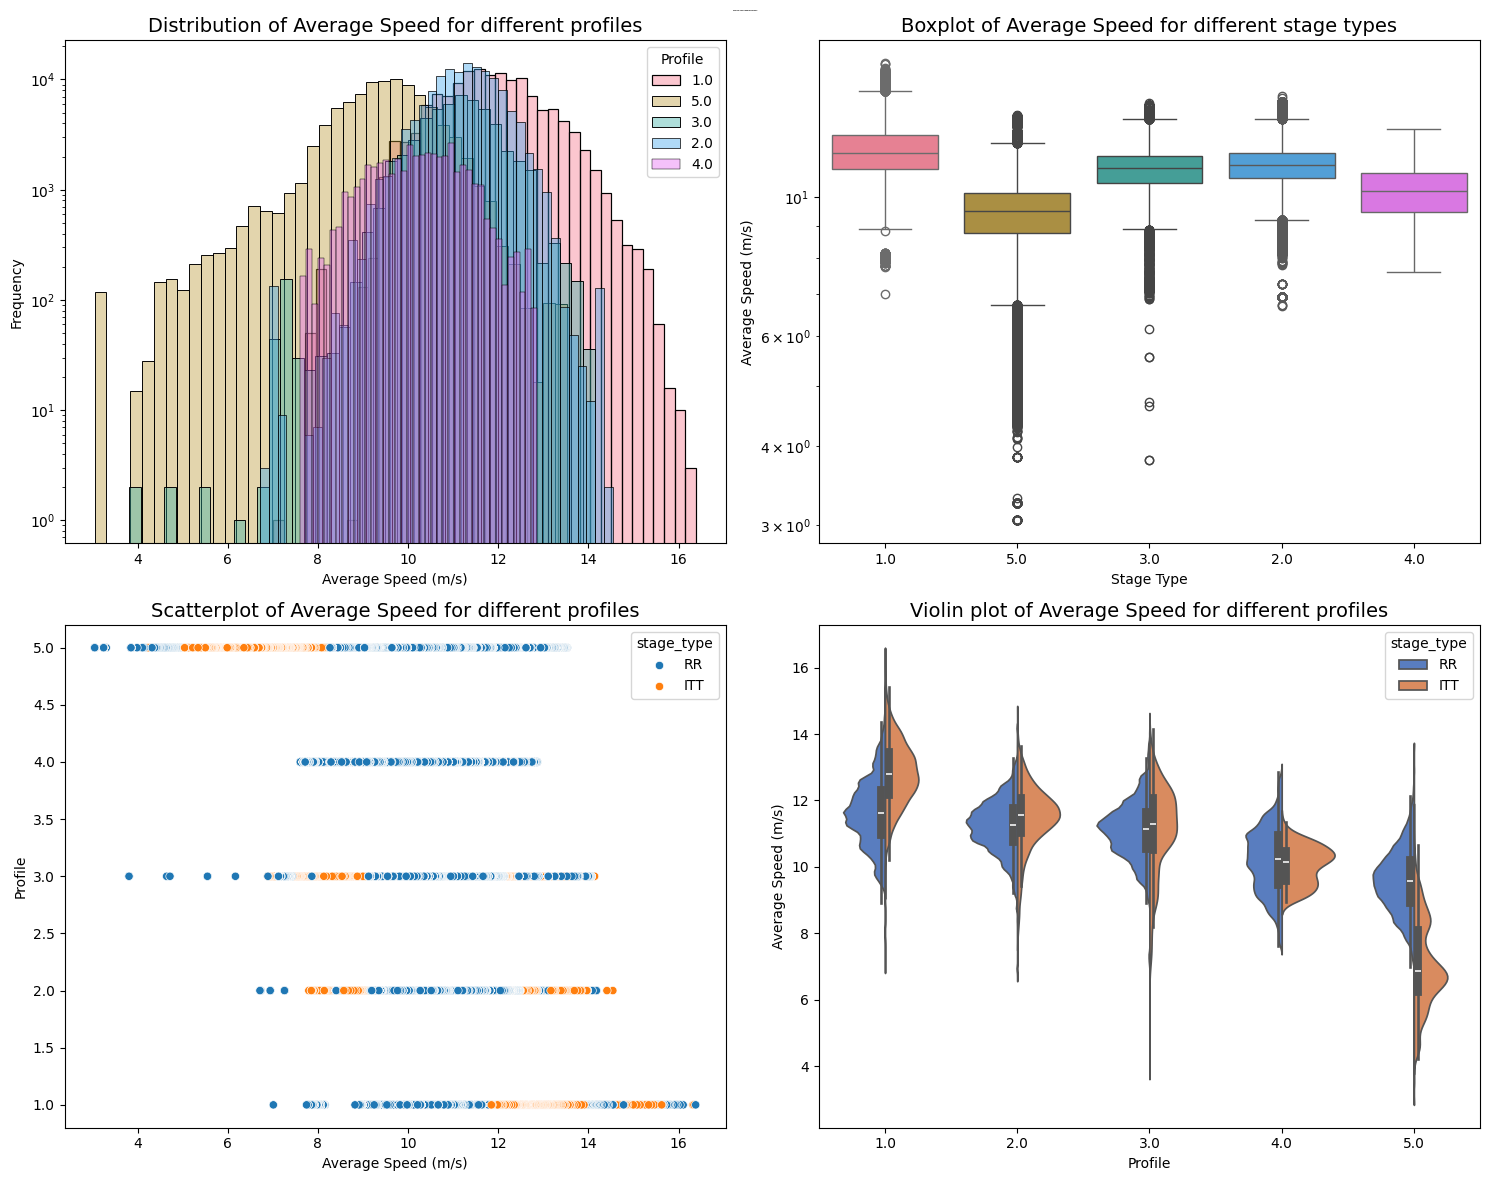

In [40]:
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Average Speed and race Profile', fontsize=1, fontweight='bold')

palette = sns.color_palette("husl", len(filtered_out_speeds_df['profile'].unique()))

for i, profile_value in enumerate(filtered_out_speeds_df['profile'].unique()):
    sns.histplot(filtered_out_speeds_df[filtered_out_speeds_df['profile'] == profile_value]['average_speed'],
                 bins=40, kde=False, alpha=0.4, label=profile_value, ax=ax[0,0], color=palette[i])
    sns.boxplot(data=filtered_out_speeds_df[filtered_out_speeds_df['profile'] == profile_value],
                x='profile',
                y='average_speed',
                ax=ax[0,1], color=palette[i])
    
sns.scatterplot(data=filtered_out_speeds_df, x='average_speed', y='profile', hue='stage_type', ax=ax[1,0])
# What's even this
sns.violinplot(data=filtered_out_speeds_df, x='profile', y='average_speed', hue='stage_type', split=True, ax=ax[1,1], palette='muted')

ax[0, 0].set_title('Distribution of Average Speed for different profiles', fontsize=14)
ax[0, 0].set_xlabel('Average Speed (m/s)')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_yscale('log')
ax[0, 0].legend(title='Profile')

ax[0, 1].set_title('Boxplot of Average Speed for different stage types', fontsize=14)
ax[0, 1].set_xlabel('Stage Type')
ax[0, 1].set_ylabel('Average Speed (m/s)')
ax[0, 1].set_yscale('log')

ax[1, 0].set_title('Scatterplot of Average Speed for different profiles', fontsize=14)
ax[1, 0].set_xlabel('Average Speed (m/s)')
ax[1, 0].set_ylabel('Profile')

ax[1, 1].set_title('Violin plot of Average Speed for different profiles', fontsize=14)
ax[1, 1].set_xlabel('Profile')
ax[1, 1].set_ylabel('Average Speed (m/s)')

plt.tight_layout()
save_plot(plt, IMAGES_DIR, 'avg_speed_vs_profile')
plt.show()


We hoped that by "stratifying" the analysis of the `average_speed` over the `profile` values a clearer separation would emerge. For the `length` values this analysis was successful. Here, instead, we come out empty-handed.

The histograms are really superimposed, and don't allow us to decompose the `average_speed` distribution $\mathbb{P}(\mathtt{average\_speed}) $ into simpler, clearly distinguishable distributions $\mathbb{P}(\mathtt{average\_speed},\,\mathtt{profile}=i)\quad\,i\in\{1,\dots,5\}$. 

The boxplots confirm this: besides the profile 5 (the toughest) - which has more spread out values for `average_speed` overall, and for which the values in the IQR are lower than those of the other distributions - the other profiles have similar median, and very similar IQR in general. But we can notice that very low average speeds are only present for profile 5.

The scatterplot confirms this conclusion, but is difficult to make sense of. However, it suggests that "stratifying" the analysis over both the `profile` and the `stage_type` could be promising (could lead to a clearer separation), as the average speeds for all five profiles clearly show separation between ITT and RR. 

The violin plot supports this hope, because (especially for profiles 1 and 5) the `average_speed` distributions for a given `profile` and `stage_type` have different peaks. This is not formal, though, just ideas.

Overall, with this much overlapping, I don't know how the imputation of the `profile` based on these quantities is a good idea.

#### Average speed of each cyclist

We're not done yet with the `average_speed` feature! What if, instead of looking at this feature per cyclist and per stage, we considered the average speed of each cyclist?

Of course we couldn't stratify the analysis on the profile as was done earlier, but we can compare the average speed of a cyclist with other cyclists-related features!

In [41]:
races_df.groupby('cyclist')['average_speed'].mean().describe()

count    6095.000000
mean       11.212833
std        15.502546
min         0.225583
25%        10.664451
50%        10.927715
75%        11.152271
max      1205.555556
Name: average_speed, dtype: float64

The average speed of a cyclists is around 11m/s, which is a little bit above 40Km/h. It's a high speed, but we're talking about professional cyclists here.

There are obvious outliers, as the values of `min` and `max` make no sense at all, the latter in particular. Well, that's because we didn't exclude some races that gave rise to absurd speeds! Well, this is why one does data analysis, right? 

Let's try again

In [42]:
# Step 1: Compute average speed for each cyclist
cyclist_avg_speed = filtered_out_speeds_df.groupby('cyclist')['average_speed'].mean().reset_index()

# Step 2: Rename the column for clarity
cyclist_avg_speed.rename(columns={'average_speed': 'avg_speed_cyclist', 'cyclist': '_url'}, inplace=True)

# Step 3: Merge with cyclist_df if needed
cyclist_df = cyclist_df.merge(cyclist_avg_speed, how='left', on='_url')

cyclist_df['avg_speed_cyclist'].describe()

count    6094.000000
mean       10.890487
std         0.500134
min         5.349183
25%        10.660895
50%        10.916106
75%        11.123013
max        17.658292
Name: avg_speed_cyclist, dtype: float64

Much better. 

- We notice that some cyclists don't have a speed. This is because they didn't participate to any race, or because they participated only to races that were "discarded". Upon a manual check, 39 cyclists don't have a `avg_speed_cyclist` value because they didn't participate to any race, and two of them because they participated to "problematic" races:
  - Gianni Pigatto participated to the 3rd Stage of 1988 Tour de Suisse, allegedly completing a 217Km long race in 3 minute, thus cycling at 1205m/s
  - Andreas Walzer partecipated to the prologue stage of 1997 Tour de Romandie, a 8Km long race which allegedly took him almost 10h to complete. Upon a deeper look, it turns out that there is a problem in how the dataset was created. <br>
  The `speed_based_dataset_cleaning` function now fixes it, retrieving data from ProCyclingStats
- The average speed is similar to the one we had before, but the standard deviation is way lower. This is a consequence of cutting the "tails" of the `average_speed` distribution


Let's plot the distribution

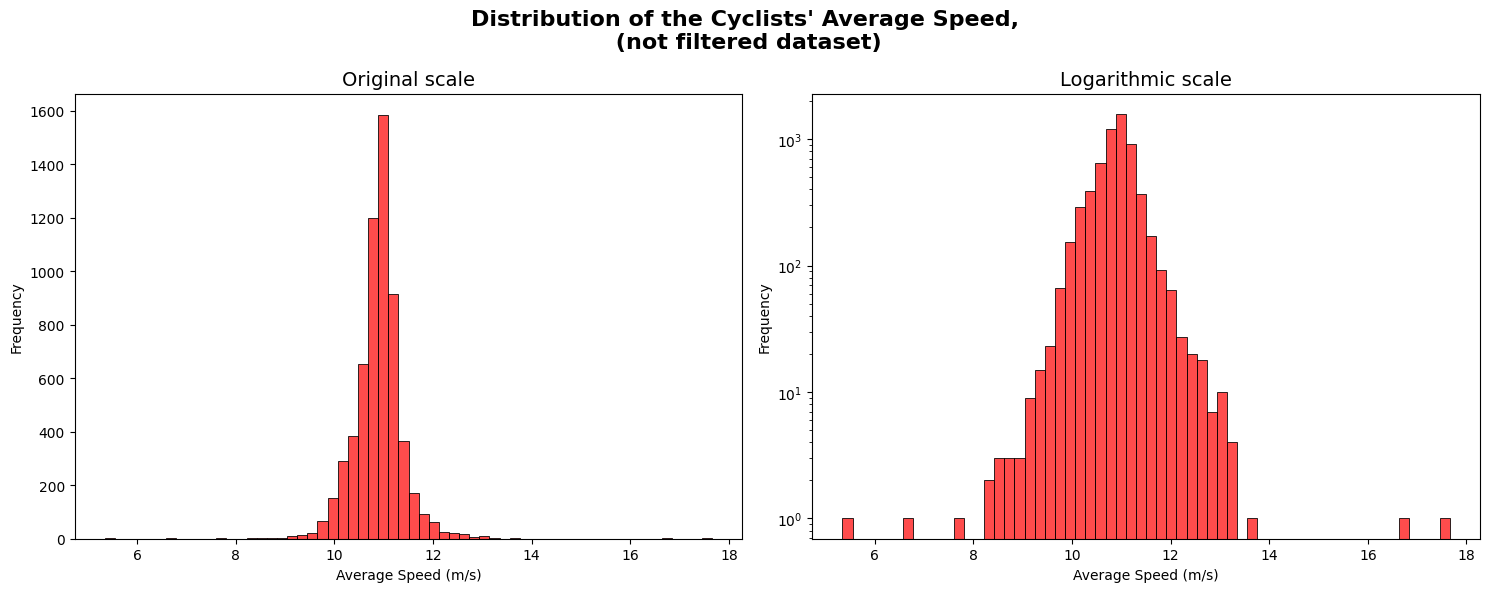

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Distribution of the Cyclists' Average Speed,\n (not filtered dataset)", fontsize=16, fontweight='bold')

sns.histplot(cyclist_df['avg_speed_cyclist'], bins=60, color='red', alpha=0.7, ax=ax[0])
ax[0].set_title("Original scale", fontsize=14)
ax[0].set_xlabel('Average Speed (m/s)')
ax[0].set_ylabel('Frequency')

sns.histplot(cyclist_df['avg_speed_cyclist'], bins=60, color='red', alpha=0.7, ax=ax[1])
ax[1].set_title("Logarithmic scale", fontsize=14)
ax[1].set_xlabel('Average Speed (m/s)')
ax[1].set_ylabel('Frequency')
ax[1].set_yscale('log')

plt.tight_layout()
plt.show()


The distribution looks very "peaked", all of the values concentrated in a narrow interval

There are few isolated values below 8 and above 14. Who are they?

In [44]:
cyclist_df[(cyclist_df['avg_speed_cyclist'] < 8) | (cyclist_df['avg_speed_cyclist'] > 13.5)]

_url                name  birth_year  weight  height  \
1476          vincenzo-galati     Vincenzo Galati      1969.0     NaN     NaN   
4438          jocelyn-jolidon     Jocelyn Jolidon      1962.0     NaN     NaN   
4653           jose-luis-diaz      Jose Luis Diaz      1965.0     NaN     NaN   
4756           thierry-lauder      Thierry Lauder         NaN     NaN     NaN   
5143         federico-ghiotto    Federico Ghiotto      1963.0     NaN     NaN   
6129  juan-jose-martinez-diaz  Juan José Martínez      1966.0     NaN     NaN   

      nationality  bmi  race_count experience_level  total_points  \
1476        Italy  NaN         1.0         beginner           4.0   
4438  Switzerland  NaN         7.0         beginner          28.0   
4653        Spain  NaN         1.0         beginner           0.0   
4756       France  NaN         1.0         beginner           0.0   
5143        Italy  NaN         4.0         beginner          64.0   
6129        Spain  NaN         1.0         beginner           5.0   

      victories_by_points  avg_points_per_race  average_position  \
1476                    0                  4.0          6.000000   
4438                    0                  4.0         28.714286   
4653                    0                  0.0         80.000000   
4756                    0                  0.0         99.000000   
5143                    0                 16.0          4.500000   
6129                    0                  5.0         10.000000   

      avg_speed_cyclist  
1476           7.638447  
4438          17.658292  
4653           6.600660  
4756           5.349183  
5143          16.695447  
6129          13.719512

Just cyclists from the past that ran a handful of races. One hoped to see some great names of cyclism such as Bernard Hinault, Eddy Merckx, ~~Tadej Pogacar~~, ...

These cyclists don't stand out for their superior speeds. The professional cyclists go all at more or less the same speed, but it has to be noted that tiny differences may have a huge impact.

### Exploration of `stage_type`

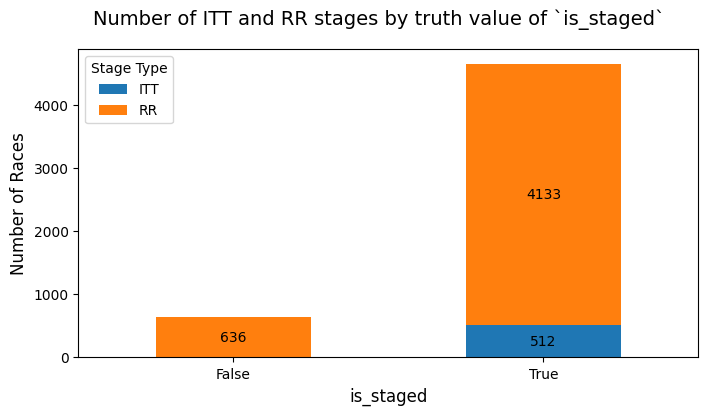

In [45]:
fig, ax = plt.subplots(figsize=(8, 4))
fig.suptitle('Number of ITT and RR stages by truth value of `is_staged`', fontsize=14)

# Get the data
data = races_df.drop_duplicates(subset=['_url']).groupby('is_staged')['stage_type'].value_counts().unstack()

# Plot the data
data.plot(kind='bar', stacked=True, ax=ax)

# Customize the plot
ax.set_ylabel('Number of Races', fontsize=12)
ax.set_xticklabels(['False', 'True'], rotation=0)
ax.set_xlabel('is_staged', fontsize=12)
ax.legend(title='Stage Type', loc='upper left')

# Annotate each bar with the population count
for container in ax.containers:
    # To hide the ugly 0
    labels = [f'{int(v.get_height())}' if v.get_height() > 0 else '' for v in container]
    ax.bar_label(container, labels=labels, label_type='center')

plt.show()

From the plot we can see that only the staged races such as Tour de France have Individual Time Trials. The non-staged races are categorized as Road Races. The ITT stages are really few compared to the "normal" RR stages.

In [46]:
print(f"Overall, in the staged races {(512*100)/4133:5.2f}% of the stages are ITT")

Overall, in the staged races 12.39% of the stages are ITT


The following table shows, for each (staged) competition, how many stages (on average) in total are RR, how many are ITT, and their proportion.

In [47]:
# Calculate non-normalized counts
non_normalized_counts = races_df[races_df['is_staged']].drop_duplicates(subset=['_url']).groupby('name')['stage_type'].value_counts().unstack().fillna(0)

# Calculate normalized counts
normalized_counts = races_df[races_df['is_staged']].drop_duplicates(subset=['_url']).groupby('name')['stage_type'].value_counts(normalize=True).unstack().fillna(0)

# Rename columns
normalized_counts.rename(columns={'RR': 'RR (norm.)', 'ITT': 'ITT (norm.)'}, inplace=True)

# Add the total column from non-normalized counts to normalized counts
normalized_counts['total'] = non_normalized_counts.sum(axis=1)

pd.concat([normalized_counts, non_normalized_counts], axis=1)

stage_type                   ITT (norm.)  RR (norm.)  total  ITT   RR
name                                                                 
Criterium du Dauphiné           0.113475    0.886525    282   32  250
Giro d'Italia                   0.103641    0.896359    714   74  640
Gran Camiño                     0.285714    0.714286      7    2    5
Itzulia Basque Country          0.166667    0.833333    138   23  115
La Vuelta ciclista a España     0.099553    0.900447    894   89  805
Paris - Nice                    0.098985    0.901015    394   39  355
Tirreno-Adriatico               0.114391    0.885609    271   31  240
Tour de France                  0.102086    0.897914    911   93  818
Tour de Romandie                0.146939    0.853061    245   36  209
Tour de Suisse                  0.129225    0.870775    503   65  438
UAE Tour                        0.064516    0.935484     31    2   29
Volta Ciclista a Catalunya      0.101961    0.898039    255   26  229

We can see that for all races except the Grand Camino, 10% circa of the races are Individual Time Trials. This is consistent with the 12.39% value gotten earlier.

In particular, the proportion is the same for all staged races. In other words, the distribution of `stage_type` (i.e. of `RR` and `ITT`) is uniform, with respect to the races themselves.


### `length` vs `stage_type`

Thanks to the domain experts (prof. Setzu) we know that a stage can simply be a road race (RR) or can be a individual time trial (ITT) stage. Furthermore:
- All staged races (e.g. Tour de France) have at least one stage that is ITT
- A ITT differs from a RR for the fact that in the latter all cyclists start at the same time all together, while in a ITT the cyclists start cycling one after the other
- Typically ITTs are shorter

Let's try to see how the `stage_type` compares with the `length`

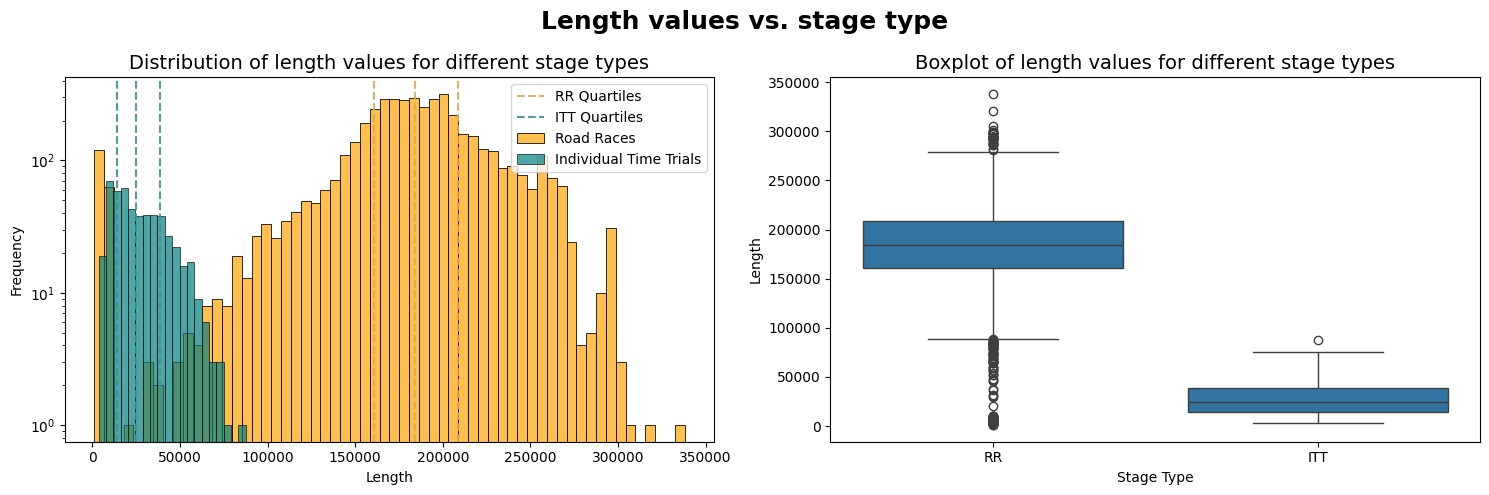

In [48]:
races_df_ = races_df.drop_duplicates(subset=['_url'], keep='first')
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Length values vs. stage type', fontsize=18, fontweight='bold')


sns.histplot(races_df_.loc[races_df_['stage_type'] == 'RR', 'length'], bins=60, kde=False, color='orange', alpha=0.7, label='Road Races', ax=ax[0])
rr_quartiles = races_df_.loc[races_df_['stage_type'] == 'RR', 'length'].quantile([0.25, 0.5, 0.75])

sns.histplot(races_df_.loc[races_df_['stage_type'] == 'ITT', 'length'], bins=20, kde=False, color='teal', alpha=0.7, label='Individual Time Trials', ax=ax[0])
itt_quartiles = races_df_.loc[races_df_['stage_type'] == 'ITT', 'length'].quantile([0.25, 0.5, 0.75])

# Add vertical lines for Road Races quartiles
for i, q in enumerate(rr_quartiles):
    label = 'RR Quartiles' if i == 0 else None
    ax[0].axvline(q, linestyle='--', color=(220/255,170/255,80/255), alpha=0.9, label=label)

# Add vertical lines for Individual Time Trials quartiles
for i, q in enumerate(itt_quartiles):
    label = 'ITT Quartiles' if i == 0 else None
    ax[0].axvline(q, linestyle='--', color=(65/255,145/255,145/255), alpha=0.9, label=label)
    
ax[0].set_title('Distribution of length values for different stage types', fontsize=14)
ax[0].set_xlabel('Length')
ax[0].set_ylabel('Frequency')
ax[0].set_yscale('log')
ax[0].legend()

sns.boxplot(data=races_df_, x='stage_type', y='length', ax=ax[1])
ax[1].set_title('Boxplot of length values for different stage types', fontsize=14)
ax[1].set_xlabel('Stage Type')
ax[1].set_ylabel('Length')



plt.tight_layout()
plt.show()

As we can see, the two distributions are very well separated visually, but there is some overlap, because there are short road races.

In [49]:
# Not the best... To review... To do better... Maybe with the name_stage feature?
races_df.loc[(races_df['length'] < 100000) & (races_df['stage_type'] == 'RR'), 'name'].unique()

array(['Volta Ciclista a Catalunya', 'La Vuelta ciclista a España',
       'Tour de Romandie', 'Tour de Suisse', 'Paris - Nice',
       "Giro d'Italia", 'Tour de France', 'Tirreno-Adriatico',
       'Criterium du Dauphiné', 'Itzulia Basque Country'], dtype=object)

In [50]:
races_df.groupby('stage_type')['length'].describe()

count           mean           std     min       25%       50%  \
stage_type                                                                      
ITT          55804.0   29722.894058  16881.897400  3600.0   15100.0   28000.0   
RR          549036.0  180734.526661  49672.396774  1000.0  161500.0  182900.0   

                 75%       max  
stage_type                      
ITT          41200.0   87500.0  
RR          206000.0  338000.0

As we can see, `RR` is the majority class. 

The average length of a `ITT` is 29,7 Km, very close to the median, that is 28 Km. <br>
The average length of a `RR` is 180 Km, very close to the median, that is 183 Km.

We can notice that all the mass of the `ITT`'s length distribution is before the first quartile of the `RR`'s length distribution. 

The analysis just performed seems to suggest that higher `length` values correspond to Road Races, and lower `length` values correspond to ITTs.

A way to further assess this idea is the [Point-biserial correlation](https://en.wikipedia.org/wiki/Point-biserial_correlation_coefficient), a coefficient that can be used to evaluate the correlation between the `length` (which is continuous) and the values of $\delta_{\mathtt{stage\_type} == \mathtt{RR}}$ ($\delta$ stands for an indicator variable, so is binary).

In [51]:
correlation, _ = stats.pointbiserialr(races_df_['stage_type'] == 'RR', races_df_['length'])
print(f"Point-biserial correlation between the stage_type and the lengths: {correlation:.3f}")

Point-biserial correlation between the stage_type and the lengths: 0.665


We expected a value even closer to 1. But one has to notice that there are very short Road Races as well. As a introduction to the next subparagraph, let's repeat the analysis, this time excluding the `prologue` stages.

In [52]:
no_prologue_races_df_ = races_df_[~races_df_['_url'].str.contains('prologue')]

correlation, _ = stats.pointbiserialr(no_prologue_races_df_['stage_type'] == 'RR', no_prologue_races_df_['length'])
print(f"Point-biserial correlation between the stage_type and the lengths, excluding the 'prologue' stages: {correlation}")
#print(f"P-value: {p_value}")

Point-biserial correlation between the stage_type and the lengths, excluding the 'prologue' stages: 0.7736323415578312


Now the correlation is much stronger!

All in all, `length` is an excellent predictor of `stage_type`, but not a perfect one (mainly because of the `prologue` stages). It's ok to have the ground truth.

### `startlist_quality` vs `stage_type`

We can see if other bimodal distributions are "caused" by the `stage_type`, let's analize the `startlist_quality` in the same way

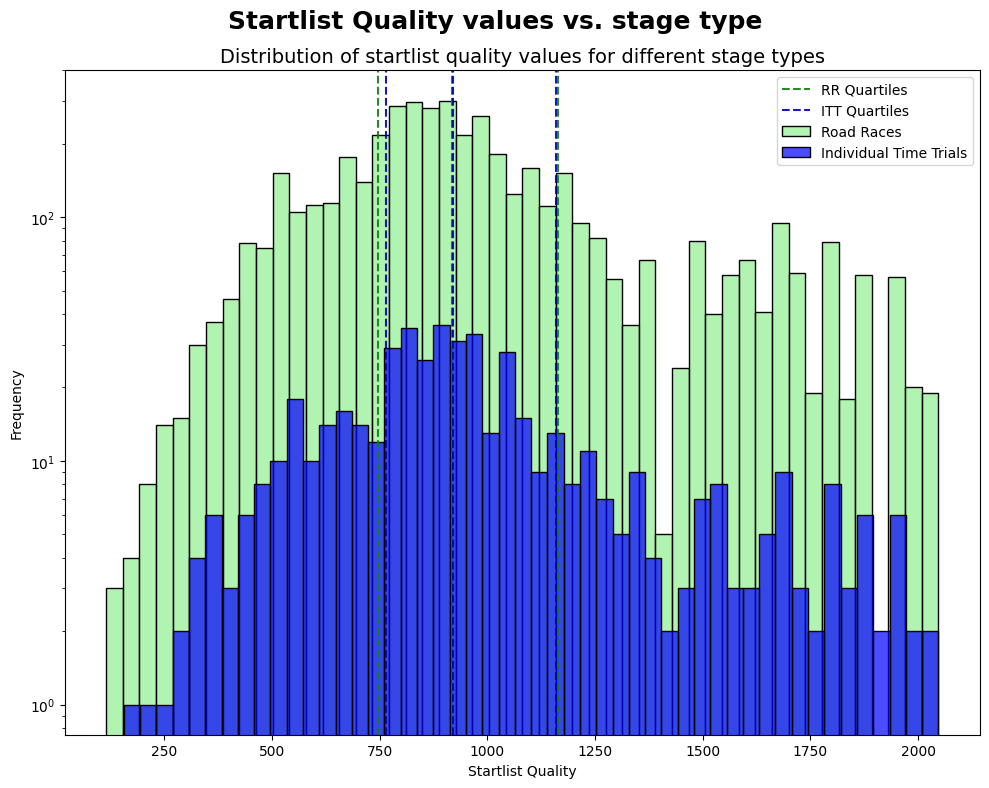

In [53]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Startlist Quality values vs. stage type', fontsize=18, fontweight='bold')

sns.histplot(races_df_.loc[races_df_['stage_type'] == 'RR', 'startlist_quality'], bins=50, kde=False, color='lightgreen', alpha=0.7, label='Road Races', ax=ax)
rr_quartiles = races_df_.loc[races_df_['stage_type'] == 'RR', 'startlist_quality'].quantile([0.25, 0.5, 0.75])

sns.histplot(races_df_.loc[races_df_['stage_type'] == 'ITT', 'startlist_quality'], bins=50, kde=False, color='blue', alpha=0.7, label='Individual Time Trials', ax=ax)
itt_quartiles = races_df_.loc[races_df_['stage_type'] == 'ITT', 'startlist_quality'].quantile([0.25, 0.5, 0.75])

# Add vertical lines for Road Races quartiles
for i, q in enumerate(rr_quartiles):
    label = 'RR Quartiles' if i == 0 else None
    ax.axvline(q, linestyle='--', color=(15/255,127/255,15/255), alpha=0.9, label=label)

# Add vertical lines for Individual Time Trials quartiles
for i, q in enumerate(itt_quartiles):
    label = 'ITT Quartiles' if i == 0 else None
    ax.axvline(q, linestyle='--', color=(0/255,0/255,180/255), alpha=0.9, label=label)
    
ax.set_title('Distribution of startlist quality values for different stage types', fontsize=14)
ax.set_xlabel('Startlist Quality')
ax.set_ylabel('Frequency')
ax.set_yscale('log')
ax.legend()

plt.tight_layout()
plt.show()

This is the opposite of what I was expecting but is indeed intresting to see that the distributions have almost the same shape, this could suggest that the people racing are the same.

***Andrea***: *I think that it's reasonable that the two frequencies follow the same patterns, the `RR` one being a "dilated" version of the `ITT` one, because basically in all the staged races there's one stage that is an ITT and more or less will have the same participants of all the other stages (therefore the same `startlist_quality`). Most of the competitions are staged (we should assess that...), the non-staged ones "add a little bit of noise to this process", but could look more into detail if so wishes. But maybe you had a different idea.*

We think that the road races that are short can be prologue of stage races. We suppose this after we've seen that the shortest race is a prologue. If this is true we could say that the distribution of non prologue RR is more or less Normal

### A deeper study of `length`

First of all we need to create a column that tells us the stage name near the name, s.t. we don't need to retrieve the information from the `_url` each time

In [54]:
def get_name_stage(row) -> Tuple[str, str]:
    array_of_info = row['_url'].split('/')
    array_of_info[-1] = np.nan if array_of_info[-1] == 'result' else array_of_info[-1]
    return array_of_info[0], array_of_info[-1]

#define column name
races_df['stage'] = races_df.apply(lambda row: get_name_stage(row)[1], axis=1)
# move name column to the second position
cols = list(races_df.columns)
cols.insert(2, cols.pop(cols.index('stage')))
races_df = races_df[cols]

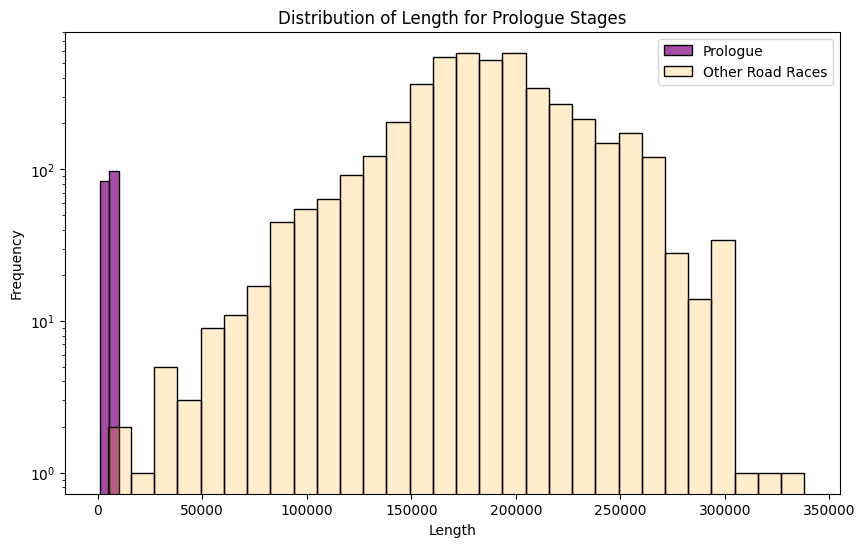

In [55]:
prologue_races = races_df.drop_duplicates(subset=['_url'])
other_rr = prologue_races[(prologue_races['stage_type'] == 'RR') & (prologue_races['stage'] != 'prologue')]
prologue_races = prologue_races[prologue_races['stage'] == 'prologue']

plt.figure(figsize=(10, 6))
sns.histplot(prologue_races['length'], bins=2, kde=False, color='purple', alpha=0.7)
sns.histplot(other_rr['length'], bins=30, kde=False, color='orange', alpha=0.2)
plt.title('Distribution of Length for Prologue Stages')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.yscale('log')
plt.legend(['Prologue', 'Other Road Races'])
plt.show()

We can discuss about the color palette of this plot, and the way it is obtained, but for sure we can say that prologues are the short road races. To see this even better, let's control the distribution of just the prologue length since now it is all compressed to the left.

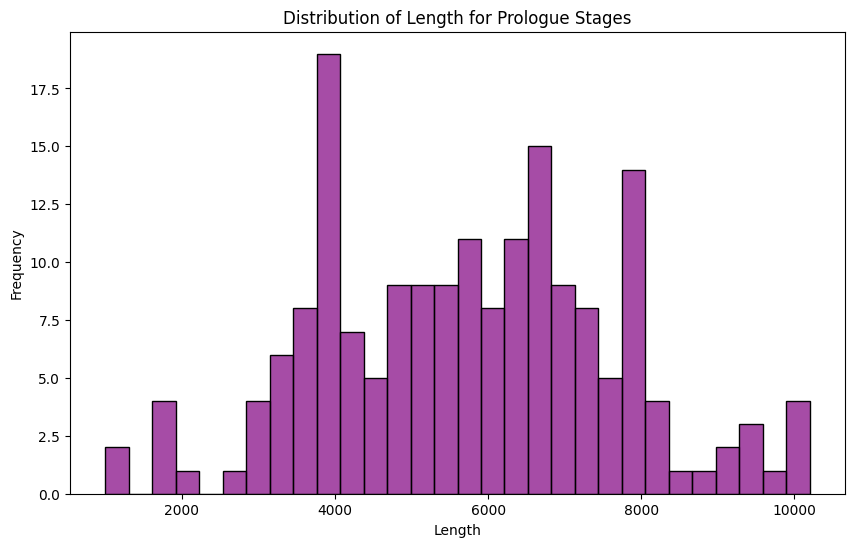

In [56]:
races_df_ = races_df.drop_duplicates(subset=['_url'])
# Filter the races where the stage is a prologue
prologue_races = races_df_[races_df_['stage'] == 'prologue']

# Plot the length of these races
plt.figure(figsize=(10, 6))
sns.histplot(prologue_races['length'], bins=30, kde=False, color='purple', alpha=0.7)
plt.title('Distribution of Length for Prologue Stages')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [57]:
print('There are:', prologue_races[prologue_races['stage_type'] == 'RR'].shape[0], "RR")
print("      and:", prologue_races[prologue_races['stage_type'] == 'ITT'].shape[0],"ITT")

There are: 180 RR
      and: 1 ITT


Nice, we discovered that the shape of the overall shape of the length distribution was given by the summation of 3 different "almost gaussian distribution". We can also see that one prologue only was an ITT race, and there are not many analysis we can do on a single value...

##### Is it normal, though?

We've gone a long way in analyzing the `length` values. The initial distribution $\mathbb{P}(\mathtt{length})$ didn't look nice, but then we noticed that by looking at the `stage_type` the distributions $\mathbb{P}(\mathtt{length},\mathtt{stage\_type}=\mathtt{RR})$ and $\mathbb{P}(\mathtt{length},\mathtt{stage\_type}=\mathtt{ITT})$ are well separated.

$$\begin{align*} 
    \mathbb{P}(\mathtt{length})&=\sum_{s\in\{\mathtt{RR},\mathtt{ITT}\}}\mathbb{P}(\mathtt{length},\mathtt{stage\_type}=\mathtt{s})\\
    &= \mathbb{P}(\mathtt{length},\mathtt{stage\_type}=\mathtt{RR})+\mathbb{P}(\mathtt{length},\mathtt{stage\_type}=\mathtt{ITT})
\end{align*}
$$

But we saw that the distribution of the `RR` stages' length had many small values, and discovered that it was the "fault" of the `prologue` stages. The `prologue` stages are significantly shorter than the non-`prologue` ones, and almost all the `prologue` stages are `RR` stages, we'll just ignore the only `ITT` and `prologue` stage.

By isolating the `prologue` stages, we noticed that the `length` distribution was even nicer. Therefore we claim that the "proper" way to interpret the distribution of the length values is the following:

$$ \mathbb{P}(\mathtt{length}) = \mathbb{P}\left(\mathtt{length},\mathtt{stage\_type}=\mathtt{ITT}\right)+\mathbb{P}\left(\mathtt{length},\neg\,\mathtt{prologue}\right) +\mathbb{P}(\mathtt{length},\mathtt{prologue})$$

(we didn't mention the $\mathtt{stage\_type}=\mathtt{RR}$ when `prologue` was mentioned, to remove redundancies).

We said that the distribution of the non-prologue stages' length is almost normal. Is it normal, though?

Well, it's time for statistical hypothesis testing!

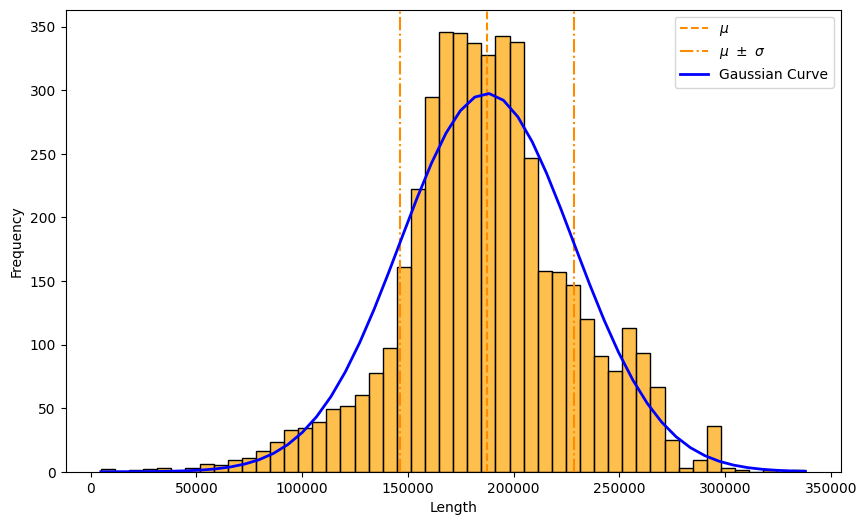

In [58]:
plt.figure(figsize=(10, 6))

non_prologue_length_values = other_rr['length']#.values
mean = non_prologue_length_values.mean()
std = non_prologue_length_values.std()

n_bins = 50

sns.histplot(non_prologue_length_values, bins=n_bins, kde=False, color='orange', alpha=0.7)
plt.axvline(mean, color='darkorange', linestyle='--', label=r'$\mu$')
plt.axvline(mean + std, color='darkorange', linestyle='-.', label=r'$\mu\ \pm\ \sigma$')
plt.axvline(mean - std, color='darkorange', linestyle='-.')

# Generate x values, for the Gaussian curve
x = np.linspace(non_prologue_length_values.min(), non_prologue_length_values.max(), n_bins)#, non_prologue_length_values.shape[0])

# Generate y values for the Gaussian curve
y = stats.norm.pdf(x, mean, std) * len(non_prologue_length_values) * (non_prologue_length_values.max() - non_prologue_length_values.min()) / n_bins  # Adjusting for histogram scaling

# Plot the Gaussian curve
plt.plot(x, y, color='blue', linestyle='-', linewidth=2, label='Gaussian Curve')

plt.xlabel('Length')
plt.ylabel('Frequency')
#plt.yscale('log')
plt.legend()
plt.show()

We now conduct a $\chi^2$ test on `non_prologue_length_values` with expected frequencies given by a normal random variable with law $\mathcal{N}(\mu,\sigma^2)$, where $\mu$ and $\sigma$ are (respectively) the mean and standard deviation of `non_prologue_length_values`.

An important observation is that the binning has a crucial impact on the outcome of the test. 

In [59]:
# Get the observed frequencies, grouping them in n_bins evenly spaced bins
observed_freq, bin_edges = np.histogram(non_prologue_length_values, bins=n_bins)

# Calculate the expected frequencies using the cumulative distribution function of our Gaussian
expected_freq = len(non_prologue_length_values) * np.diff(stats.norm.cdf(bin_edges, mean, std))

# Normalize the expected frequencies to match the sum of the observed frequencies (otherwise stats.chisquare will complain)
expected_freq *= observed_freq.sum() / expected_freq.sum()

chi2_stat, p_value = stats.chisquare(f_obs=observed_freq, f_exp=expected_freq)

print(f"Chi-squared Statistic: {chi2_stat}")
print(f"P-value: {p_value}")

# Interpretation
# We fix alpha, the power of the test, to be 0.05
alpha = 0.05
if p_value > alpha:
    print("Fail to reject the null hypothesis: The data is approximately normally distributed.")
else:
    print("Reject the null hypothesis: The data is not approximately normally distributed.")


Chi-squared Statistic: 650.4256363204169
P-value: 5.369475186797817e-106
Reject the null hypothesis: The data is not approximately normally distributed.


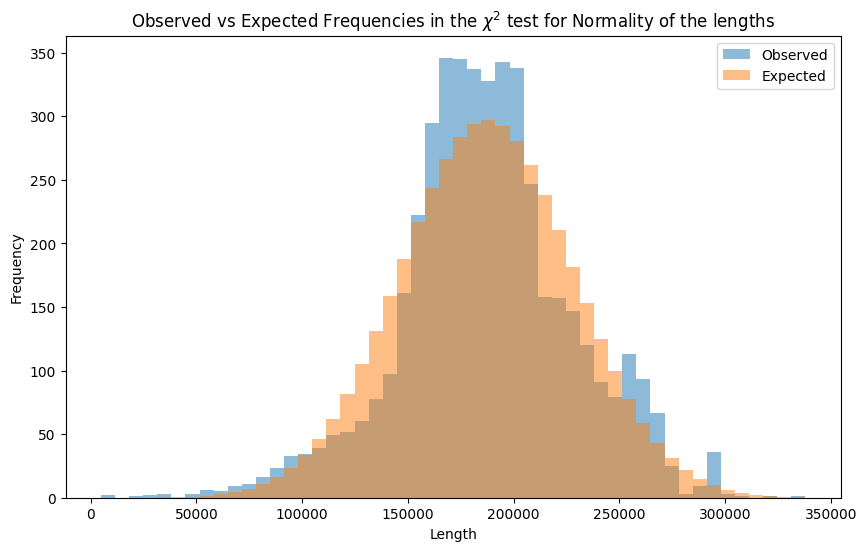

In [60]:
plt.figure(figsize=(10, 6))
plt.hist(bin_edges[:-1], bin_edges, weights=observed_freq, alpha=0.5, label='Observed')
plt.hist(bin_edges[:-1], bin_edges, weights=expected_freq, alpha=0.5, label='Expected')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title(r'Observed vs Expected Frequencies in the $\chi^2$ test for Normality of the lengths')
plt.show()

Well, we can't conclude that the values of length follow a normal distribution, but it was worth trying.

### `total_points`, `total_points` vs `average_position`

Up to now there is no way of knowing which cyclist is the best, and probably also at the end of the project we will not be able to say who's the best... But at least we can try to give an estimate based on who has accumulated more points (considering only the races in our dataset)

In [61]:
## Group by cyclist and sum the points
#points_per_cyclist = races_df.groupby('cyclist')['points'].sum().reset_index()

## Rename the columns for clarity
#points_per_cyclist.columns = ['name', 'total_points']

## Merge the points data with the cyclist_df
#cyclist_df = cyclist_df.merge(points_per_cyclist, left_on='_url', right_on='name', how='left')
#cyclist_df = cyclist_df.drop(columns=['name_y'])
#cyclist_df = cyclist_df.rename(columns={'name_x': 'name'})

## Fill NaN values with 0 (for cyclists who have no points in the races_df)
#cyclist_df['total_points'] = cyclist_df['total_points'].fillna(0)

# The `total_points` column is already in the `cyclist_df` DataFrame, it has been calculated earlier

cyclist_df.head()

_url                  name  birth_year  weight  height  \
0           bruno-surra           Bruno Surra      1964.0     NaN     NaN   
1            gerard-rue            Gérard Rué      1965.0    74.0   182.0   
2              jan-maas              Jan Maas      1996.0    69.0   189.0   
3  nathan-van-hooydonck  Nathan Van Hooydonck      1995.0    78.0   192.0   
4      jose-felix-parra      José Félix Parra      1997.0    55.0   171.0   

   nationality        bmi  race_count experience_level  total_points  \
0        Italy        NaN         1.0         beginner           0.0   
1       France  22.340297       222.0              pro        1354.0   
2  Netherlands  19.316369        49.0       developing          60.0   
3      Belgium  21.158854       161.0         semi-pro         300.0   
4        Spain  18.809206        48.0       developing           5.0   

   victories_by_points  avg_points_per_race  average_position  \
0                    0             0.000000        110.000000   
1                    0             6.099099         63.345291   
2                    0             1.224490         87.693878   
3                    0             1.863354         83.707317   
4                    0             0.104167         69.260000   

   avg_speed_cyclist  
0          13.111546  
1          10.908644  
2          11.320372  
3          11.216245  
4          11.190340

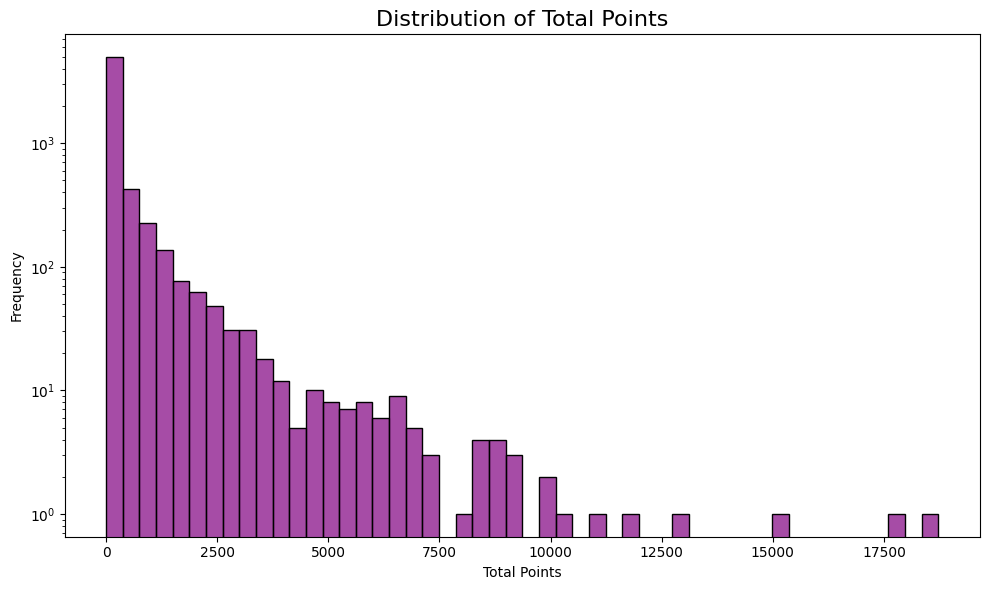

In [62]:
plt.figure(figsize=(10, 6))

sns.histplot(cyclist_df['total_points'], bins=50, kde=False, color='purple', alpha=0.7)
plt.title('Distribution of Total Points', fontsize=16)
plt.xlabel('Total Points')
plt.ylabel('Frequency')
plt.yscale('log')

plt.tight_layout()
plt.show()

I must be honest, I didn't expect this shape. Like all things, I expected a bell-shaped curve (everything is normal in Computer Science, isn't it?). 

But it makes sense, right? It makes sense that most of the cyclists have few points, and less and less cyclists have more points. I mean, it makes sense, but still is impressive. It's in log scale!

There are cyclists that have a lot of points. Who are these madmen?!?

In [63]:
cyclist_df[cyclist_df['total_points'] > 10000]

_url                name  birth_year  weight  height  \
1613          sean-kelly          Sean Kelly      1956.0    77.0   180.0   
2068   greg-van-avermaet   Greg Van Avermaet      1985.0    74.0   181.0   
2276         peter-sagan         Peter Sagan      1990.0    78.0   182.0   
2512  alejandro-valverde  Alejandro Valverde      1980.0    61.0   177.0   
3989          erik-zabel          Erik Zabel      1970.0    69.0   178.0   
4274    laurent-jalabert    Laurent Jalabert      1968.0    66.0   176.0   
4551    philippe-gilbert    Philippe Gilbert      1982.0    75.0   178.0   

     nationality        bmi  race_count experience_level  total_points  \
1613     Ireland  23.765432       629.0              pro       18726.0   
2068     Belgium  22.587833       582.0              pro       10189.0   
2276    Slovakia  23.547881       581.0              pro       15220.0   
2512       Spain  19.470778       942.0              pro       17728.0   
3989     Germany  21.777553       710.0              pro       13077.0   
4274      France  21.306818       562.0              pro       11770.0   
4551     Belgium  23.671254       836.0              pro       10948.0   

      victories_by_points  avg_points_per_race  average_position  \
1613                   29            29.771065         16.067717   
2068                    6            17.506873         44.750422   
2276                   27            26.196213         54.741554   
2512                   19            18.819533         24.401036   
3989                   11            18.418310         41.113103   
4274                   16            20.943060         26.705263   
4551                   16            13.095694         51.226371   

      avg_speed_cyclist  
1613          10.590556  
2068          11.148897  
2276          11.123388  
2512          11.241212  
3989          10.978655  
4274          11.143293  
4551          11.118303

They won a lot (by points), but they also participated to a lot of races.

The bulk of the mass of the distribution seems to be before 7500. In general, 7500 seems like a reasonable cutoff point. So, let's see who populates the "tail" of the distribution.

In [64]:
cyclist_df[(cyclist_df['total_points'] > 7500) & (cyclist_df['total_points'] <= 10000)]

_url                 name  birth_year  weight  height  \
87       michael-matthews     Michael Matthews      1990.0    72.0   178.0   
418         johan-museeuw        Johan Museeuw      1965.0    71.0   184.0   
427           eddy-merckx          Eddy Merckx      1945.0    74.0   182.0   
992    roger-de-vlaeminck   Roger De Vlaeminck      1947.0    74.0   181.0   
1990         oscar-freire         Óscar Freire      1976.0    63.0   171.0   
2497    fabian-cancellara    Fabian Cancellara      1981.0    80.0   186.0   
2576    joaquim-rodriguez    Joaquim Rodríguez      1979.0    58.0   169.0   
2815      mario-cipollini      Mario Cipollini      1967.0    77.0   189.0   
3926       mark-cavendish       Mark Cavendish      1985.0    70.0   175.0   
4446        paolo-bettini        Paolo Bettini      1974.0    58.0   169.0   
4466      davide-rebellin      Davide Rebellin      1971.0    63.0   171.0   
4873           tom-boonen           Tom Boonen      1980.0    82.0   192.0   
5716      bernard-hinault      Bernard Hinault      1954.0    62.0   174.0   
5921  alessandro-petacchi  Alessandro Petacchi      1974.0    70.0   185.0   

        nationality        bmi  race_count experience_level  total_points  \
87        Australia  22.724403       485.0              pro        8044.0   
418         Belgium  20.971172       445.0              pro        8844.0   
427         Belgium  22.340297       111.0         semi-pro        8976.0   
992         Belgium  22.587833       114.0         semi-pro        8465.0   
1990          Spain  21.545091       430.0              pro        8589.0   
2497    Switzerland  23.124061       577.0              pro        9207.0   
2576          Spain  20.307412       796.0              pro        8866.0   
2815          Italy  21.555947       373.0              pro        9807.0   
3926  Great Britain  22.857143       515.0              pro        8382.0   
4446          Italy  20.307412       508.0              pro        8579.0   
4466          Italy  21.545091       625.0              pro        9227.0   
4873        Belgium  22.243924       446.0              pro        8963.0   
5716         France  20.478267       266.0              pro        9917.0   
5921          Italy  20.452885       672.0              pro        9264.0   

      victories_by_points  avg_points_per_race  average_position  \
87                      6            16.585567         53.959514   
418                    14            19.874157         57.549889   
427                    21            80.864865          4.189189   
992                    13            74.254386          6.252174   
1990                    9            19.974419         53.054299   
2497                   15            15.956672         76.070588   
2576                    6            11.138191         48.397810   
2815                   16            26.292225         47.636842   
3926                   10            16.275728         92.355805   
4446                    8            16.887795         48.241905   
4466                    8            14.763200         34.964451   
4873                   16            20.096413         67.384956   
5716                   12            37.281955         17.139706   
5921                   11            13.785714         63.816474   

      avg_speed_cyclist  
87            11.151429  
418           10.958454  
427           10.539823  
992           10.815050  
1990          11.043911  
2497          11.151492  
2576          11.019579  
2815          11.017329  
3926          10.888094  
4446          10.957715  
4466          11.097155  
4873          11.096346  
5716          10.519414  
5921          10.916310

Well, I don't know much about cyclism but in here there are important names as well! Mario Cipollini, Mark Cavendish, Bernard Hinault (the best cyclist of all times), Eddy Merckx, ...

It's important to see that not all of them participated to many races, for example Eddy Merckx is present "just" 111 times in our dataset, but accumulated a lot of points nevertheless.

In [65]:
# Cyclists which at least attended to one race
exclude_non_partecipants_df = cyclist_df.copy()
exclude_non_partecipants_df = cyclist_df[cyclist_df['race_count'] > 0]

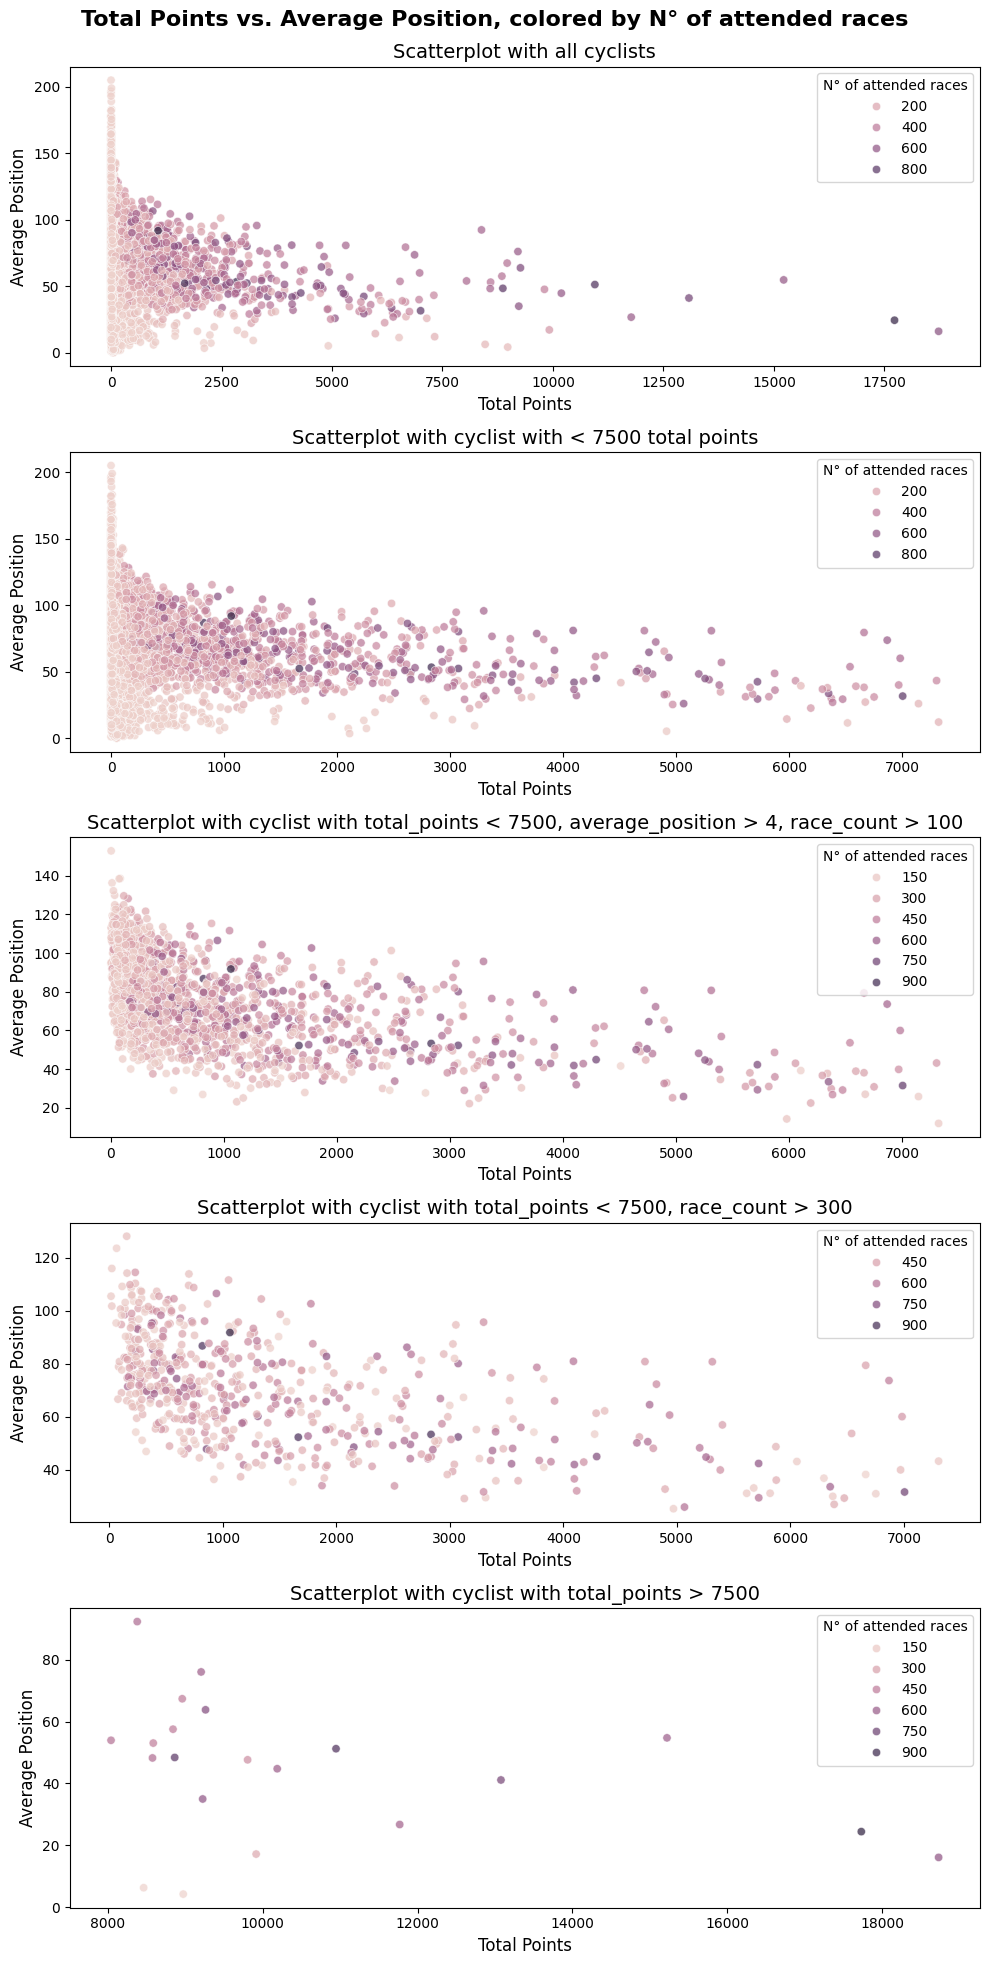

In [66]:
fig, ax = plt.subplots(5, 1, figsize=(10, 20))
fig.suptitle('Total Points vs. Average Position, colored by N° of attended races\n', fontsize=16, fontweight='bold')
TOT_PTS_THRESHOLD = 7500

sns.scatterplot(data=exclude_non_partecipants_df[['total_points','average_position','race_count']], x='total_points', y='average_position', hue='race_count', alpha=0.7, ax=ax[0])
ax[0].set_title('Scatterplot with all cyclists', fontsize=14)
ax[0].set_xlabel('Total Points', fontsize=12)
ax[0].set_ylabel('Average Position', fontsize=12)
ax[0].legend(title='N° of attended races')

sns.scatterplot(data=exclude_non_partecipants_df[exclude_non_partecipants_df['total_points'] < TOT_PTS_THRESHOLD][['total_points','average_position','race_count']],
                 x='total_points', y='average_position', hue='race_count', alpha=0.7, ax=ax[1])
ax[1].set_title(f'Scatterplot with cyclist with < {TOT_PTS_THRESHOLD} total points', fontsize=14)
ax[1].set_xlabel('Total Points', fontsize=12)
ax[1].set_ylabel('Average Position', fontsize=12)
ax[1].legend(title='N° of attended races')

def even_more_filtering(df: pd.DataFrame, 
                        race_count_min:int = 0,
                        race_count_max:int = np.inf, 
                        avg_pos_min:float = 0, 
                        avg_pos_max:float = np.inf,
                        tot_pts_min:float = 0,
                        tot_pts_max:float = np.inf) -> pd.DataFrame:
    ret_df = df[(df['average_position'] > avg_pos_min) & (df['average_position'] < avg_pos_max)]
    ret_df = ret_df[(ret_df['race_count'] > race_count_min) & (ret_df['race_count'] < race_count_max)]
    ret_df = ret_df[(ret_df['total_points'] > tot_pts_min) & (ret_df['total_points'] < tot_pts_max)]
    return ret_df

avg_pos_thresh = 4
race_count_thresh = (100, 300)
sns.scatterplot(data=even_more_filtering(exclude_non_partecipants_df, avg_pos_min=avg_pos_thresh, race_count_min=race_count_thresh[0], tot_pts_max=TOT_PTS_THRESHOLD)[['total_points','average_position','race_count']],
                 x='total_points', y='average_position', hue='race_count', alpha=0.7, ax=ax[2])
ax[2].set_title(f'Scatterplot with cyclist with total_points < {TOT_PTS_THRESHOLD}, average_position > {avg_pos_thresh}, race_count > {race_count_thresh[0]}', fontsize=14)
ax[2].set_xlabel('Total Points', fontsize=12)
ax[2].set_ylabel('Average Position', fontsize=12)
ax[2].legend(title='N° of attended races')

sns.scatterplot(data=even_more_filtering(exclude_non_partecipants_df, race_count_min=race_count_thresh[1], tot_pts_max=TOT_PTS_THRESHOLD)[['total_points','average_position','race_count']],
                 x='total_points', y='average_position', hue='race_count', alpha=0.7, ax=ax[3])
ax[3].set_title(f'Scatterplot with cyclist with total_points < {TOT_PTS_THRESHOLD}, race_count > {race_count_thresh[1]}', fontsize=14)
ax[3].set_xlabel('Total Points', fontsize=12)
ax[3].set_ylabel('Average Position', fontsize=12)
ax[3].legend(title='N° of attended races')

sns.scatterplot(data=even_more_filtering(exclude_non_partecipants_df, tot_pts_min=TOT_PTS_THRESHOLD)[['total_points','average_position','race_count']],
                 x='total_points', y='average_position', hue='race_count', alpha=0.7, ax=ax[4])
ax[4].set_title(f'Scatterplot with cyclist with total_points > {TOT_PTS_THRESHOLD}', fontsize=14)
ax[4].set_xlabel('Total Points', fontsize=12)
ax[4].set_ylabel('Average Position', fontsize=12)
ax[4].legend(title='N° of attended races')

plt.tight_layout()
save_plot(plt, IMAGES_DIR, 'total_points_vs_avg_position_scatterplots')
plt.show()


From the scatterplots above we can see that:
- As the `total_points` value increase, the number of attended races increases. This is to be expected
- There's a big lump of points corresponding to low `average_position` value, but also few participations (therefore few Total Points), in the bottom left corner. If we exclude those that participated to few races, these values go away. This seems to indicate that there are many cyclists that get good results in few stages, and then end their career. As a proof of this, by increasing the `race_count` threshold, this lump of points vanishes
- There are "occasional riders": cyclists that have a very high `average_position` value but also very few participations. By filtering per participation, the points corresponding to high `average_position` go away
- To low `total_points` values, there corresponds many values for `average_position`. As the Total Points increase, the Average Position slowly decreases
- There are some cyclists that participated to few races, but not *very few*, and have a decent amount of `total_points` and a very low value for `average_position`. As said, the average has the problem of being less significative if it's taken over few elements
- By comparing the second subplot with the first subplot, with a low threshold for the Average Position, we can see that many points that populate the high-valued part of the Total Points axis disappear. This means that it's actually the `race_count` threshold that removes them. In turn, this means that the highest achievers in terms of total points participated to few races! Of course they aren't the top achievers because the subplots 2 and 3 have a threshold on `total_points`

Other general comments:
- The "vertical line of points" that correspond to 0 Total Points and `average_position` values over 150 are there because if one has such a high value for `average_position` never actually completed a race in a position that would give him point
- It's interesting to see how cyclists that accumulated more than 7500 points didn't necessarily participate to many races, nor necessarily have values for `average_position` that are super low, say below 20. Of course, they're still low, being under 80. How low, though?

#### A (just a little) deeper look into `average_position`

How rare is to be a cyclist with an average position below 80?

In [67]:
cyclist_df['average_position'].describe()

count    6095.000000
mean       76.493667
std        33.197895
min         0.000000
25%        54.333333
50%        78.727425
75%        98.839379
max       205.000000
Name: average_position, dtype: float64

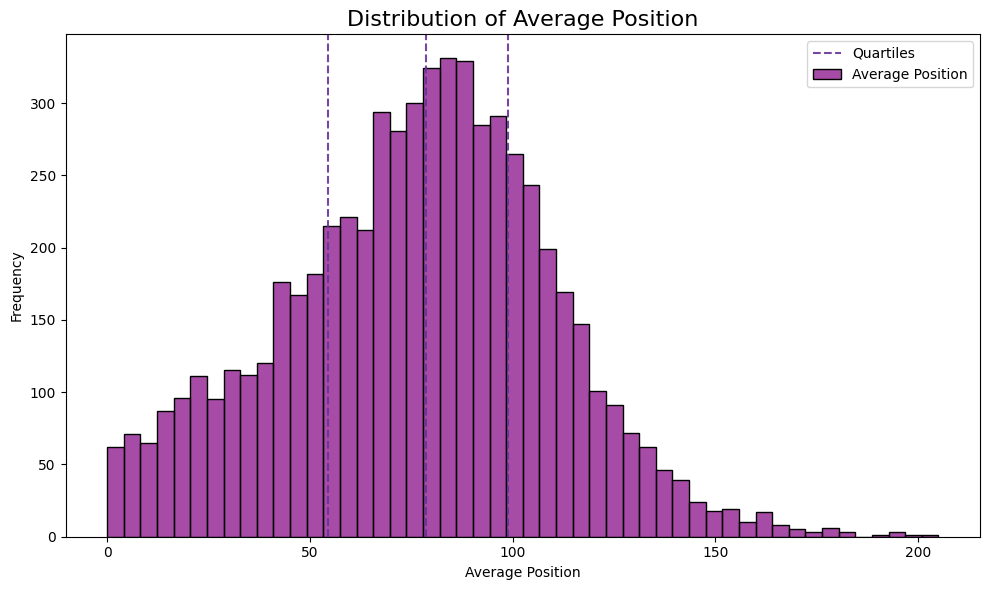

In [68]:
plt.figure(figsize=(10, 6))

sns.histplot(cyclist_df['average_position'], bins=50, kde=False, color='purple', alpha=0.7, label='Average Position')
avg_pos_quartiles = cyclist_df['average_position'].quantile([0.25, 0.5, 0.75])
for i, q in enumerate(avg_pos_quartiles):
    label = 'Quartiles' if i == 0 else None
    plt.axvline(q, linestyle='--', color='rebeccapurple', alpha=0.9, label=label)
plt.title('Distribution of Average Position', fontsize=16)
plt.xlabel('Average Position')
plt.ylabel('Frequency')
plt.legend()
#plt.yscale('log')

plt.tight_layout()
plt.show()

The distribution is very skewed towards lower values. This means that very few cyclists on average arrived in the last positions.

Let's keep in mind that many races in the dataset have way less than 200 participants, as we've seen during the exploration.

### `race-count`

Since we've used this feature in the previous analysis, let's also study *en passant* the `race_count` feature.

This feature has been simply obtained from the races dataset by counting the number of occurrencies of a cyclist (excluding duplications in the same stage). Thus it's a count at the "stage" level, not at the "competition" level. For example, a full partecipation to the Tour de France has a much higher impact than a partecipation to the Paris-Roubaix.

In the following, we also include the cyclists that don't appear in our dataset (and thus have 0 as `race_count` value).

In [69]:
cyclist_df['race_count'].describe()

count    6134.000000
mean       96.142648
std       140.548818
min         0.000000
25%         5.000000
50%        30.000000
75%       132.000000
max       959.000000
Name: race_count, dtype: float64

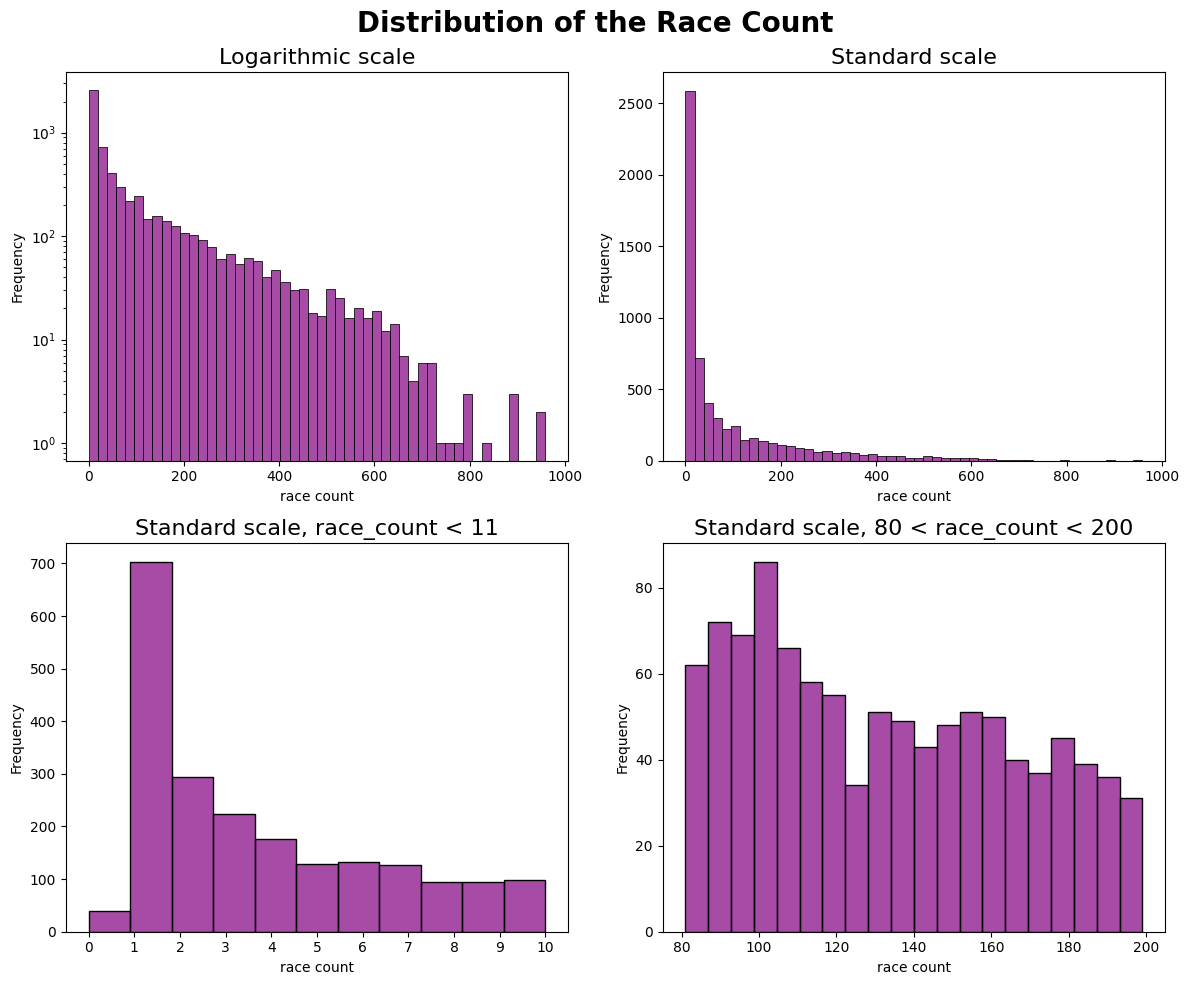

In [70]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Distribution of the Race Count', fontsize=20, fontweight='bold')

sns.histplot(cyclist_df['race_count'], bins=50, kde=False, color='purple', alpha=0.7, ax=axs[0, 0])
axs[0, 0].set_title('Logarithmic scale', fontsize=16)
axs[0, 0].set_xlabel('race count')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].set_yscale('log')


sns.histplot(cyclist_df['race_count'], bins=50, kde=False, color='purple', alpha=0.7, ax=axs[0, 1])
axs[0, 1].set_title('Standard scale', fontsize=16)
axs[0, 1].set_xlabel('race count')
axs[0, 1].set_ylabel('Frequency')

race_count_thresh = (11, 80, 200)
sns.histplot(even_more_filtering(cyclist_df.fillna({'average_position': -1}), 
                                 race_count_min=-1, tot_pts_min=-1, 
                                 avg_pos_min= -2,
                                 race_count_max=race_count_thresh[0])['race_count'], 
                                 bins=11, kde=False, color='purple', alpha=0.7, ax=axs[1, 0])
axs[1, 0].set_title(f'Standard scale, race_count < {race_count_thresh[0]}', fontsize=16)
axs[1, 0].set_xlabel('race count')
axs[1, 0].set_xticks(np.arange(0,11))
axs[1, 0].set_ylabel('Frequency')

sns.histplot(even_more_filtering(cyclist_df, 
                                 race_count_min=race_count_thresh[1],
                                 race_count_max=race_count_thresh[2])['race_count'], 
                                 bins=20, kde=False, color='purple', alpha=0.7, ax=axs[1, 1])
axs[1, 1].set_title(f'Standard scale, {race_count_thresh[1]} < race_count < {race_count_thresh[2]}', fontsize=16)
axs[1, 1].set_xlabel('race count')
axs[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Also in this regard the dataset is unbalanced. It's been already noted over and over, but we reinstate it: most of the cyclists participated to very few races.

### `race_country` and the cyclists' nationality

Is it true that the competitions in a given nation tend to be won by cyclist of that same nation?

In [71]:
nationality_df = races_df.copy()[['_url','race_country']]
nationality_df.drop_duplicates(subset=['_url'], inplace=True)
nationality_df.head()

_url race_country
0        tour-de-france/1978/stage-6       France
106    vuelta-a-espana/2016/stage-14        Spain
271     tour-de-france/2019/stage-21       France
426  volta-a-catalunya/1999/prologue        Spain
545      tour-de-france/2022/stage-9       France

In [72]:
nationality_df = races_df.copy()[['_url','race_country']]

# We just need one row per url, actually
nationality_df.drop_duplicates(subset=['_url'], inplace=True)
# We don't need all the url, just the base one, actually
# We re-use the `get_base_url` function defined above, for the `victories_by_points` feature
nationality_df['race_url'] = nationality_df['_url'].apply(get_base_url)
nationality_df.drop(columns=['_url'], inplace=True)

# We drop the duplicates of `race_url` (the multiple stages now have the same `race_url`)
nationality_df.drop_duplicates(subset=['race_url'], inplace=True)

# We create a new column to store who's the winner of that edition
# (we use the top_scorers Series defined above, for the `victories_by_points` feature)
nationality_df['points_winner'] = nationality_df['race_url'].map(top_scorers)
# And we get the nationality of the winner, from the cyclist_df
nationality_df['points_winner_nationality'] = nationality_df['points_winner'].map(cyclist_df.set_index('_url')['nationality'])
nationality_df.head()

race_country                race_url       points_winner  \
0         France     tour-de-france/1978     freddy-maertens   
106        Spain    vuelta-a-espana/2016  christopher-froome   
271       France     tour-de-france/2019          caleb-ewan   
426        Spain  volta-a-catalunya/1999     george-hincapie   
545       France     tour-de-france/2022       tadej-pogacar   

    points_winner_nationality  
0                     Belgium  
106             Great Britain  
271                 Australia  
426             United States  
545                  Slovenia

In [73]:
nationality_df[nationality_df['race_url'] == 'uae-tour/2019']

race_country       race_url     points_winner points_winner_nationality
11815          UAE  uae-tour/2019  fernando-gaviria                  Colombia

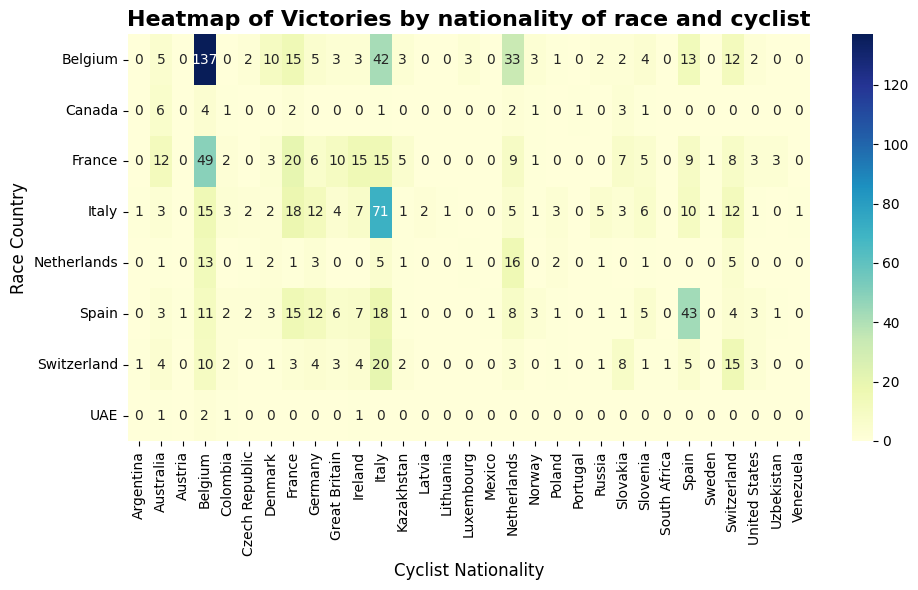

In [74]:
# Count the number of victories by nationality
victory_counts = nationality_df.groupby(['race_country', 'points_winner_nationality']).size().unstack(fill_value=0)

# Plot the heatmap with counts
plt.figure(figsize=(10, 6))
sns.heatmap(victory_counts, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Heatmap of Victories by nationality of race and cyclist', fontsize=16, fontweight='bold')
plt.xlabel('Cyclist Nationality', fontsize=12)
plt.ylabel('Race Country', fontsize=12)

plt.tight_layout()
save_plot(plt, IMAGES_DIR, 'points_winner_nationality_vs_race_country_heatmap.png')
plt.show()

The heatmap above actually tells a lot. General considerations:
- Notice that the Race Country includes many competitions. So, for example we can see that french competitions have been historically won by belgians, but we can't conclude that - for example - the Tour de France has been mostly won by belgians
- The heatmap can be read along the rows, to see which country has hosted the most competitions
- The heatmap can be read along the columns, to see which country has won the most competitions (yes Yuri we know that cyclist ride by themselves, and don't represent a country, but it's just to speak)
- Notice that the heatmap doesn't account for exceptional cyclists. Maybe a country has produced a lot of good cyclists; and another one has produced few cyclist, but each of them won a lot. Well, these two countries may look the same in the heatmap above 

More particular considerations:
- It is confiremd that the main cyclism countries are Belgium, France, Italy, Spain. These countries have hosted most of the competitions, but also gave birth to most of the winners
- There is a strong evidence that most spanish, italian and belgian competitions are won by cyclists from that same country (true victories, not points victories considered in this analysis)
- French competitions are mostly won by belgians, but official statistics say that the Tour de France has mostly been won by frenchmen
- A sizeable quantity of swiss competitions has been won by swiss, but not the majority. The same can be said about the Netherlands. 

Let's read the above heatmap along the rows, to see how many races (i.e. competitions) each country hosted!

In [75]:
continents_dict = {
    'Europe': ['Italy', 'Spain', 'Belgium', 'France', 'Great Britain',
               'Netherlands', 'Germany', 'Switzerland', 'Denmark',
               'Norway', 'Austria', 'Slovenia', 'Sweden', 'Poland', 'Czech Republic',
               'Luxembourg', 'Ireland', 'Latvia', 'Lithuania', 'Slovakia'],
    'Asia': ['Russia', 'Kazakhstan', 'Uzbekistan'],
    'Oceania': ['Australia', 'New Zealand'],
    'America': ['United States', 'Canada', 'Mexico', 'Colombia', 'Argentina', 'Venezuela'],
    'Africa': ['South Africa']             
}

In [76]:
def continent_returner(nationality:str, 
                       continents_dict:dict[str, list[str]] = continents_dict) -> str:
    for continent, countries_list in continents_dict.items():
        if nationality in countries_list:
            return continent
    return np.nan

nationality_df['points_winner_continent'] = nationality_df['points_winner_nationality'].map(continent_returner)

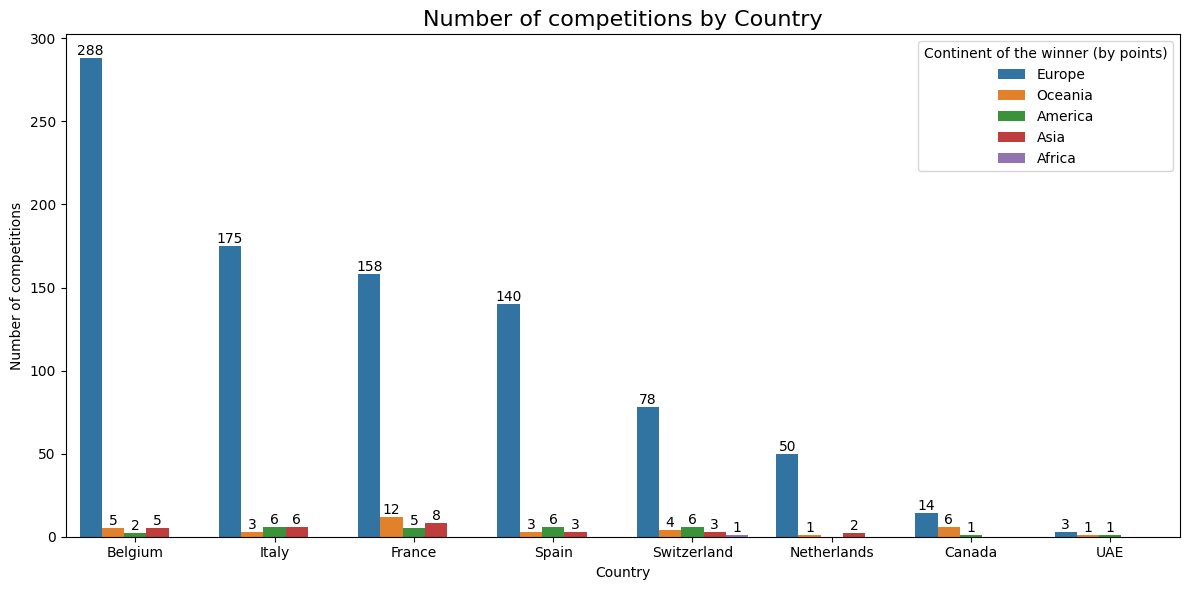

In [77]:
plt.figure(figsize=(12, 6))
plt.title('Number of competitions by Country', fontsize=16)

ax = sns.countplot(data=nationality_df, x='race_country', hue='points_winner_continent', 
                   order=nationality_df['race_country'].value_counts().index)

# Add the count on top of each bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge')

plt.xlabel('Country')
plt.ylabel('Number of competitions')
plt.legend(title='Continent of the winner (by points)')

plt.tight_layout()
plt.show()

This plot gives the idea of how much of an european sport this is.

### Study of the inferred features

Some features were inferred from linear (and non linear) combinations of previously existing features. Let's check them out.

#### BMI

Starting from the cyclists' dataset, we aim for the insights that the BMI of the different cyclists can offer. 

Even though BMI is not obtained with a linear combination, we start from this one

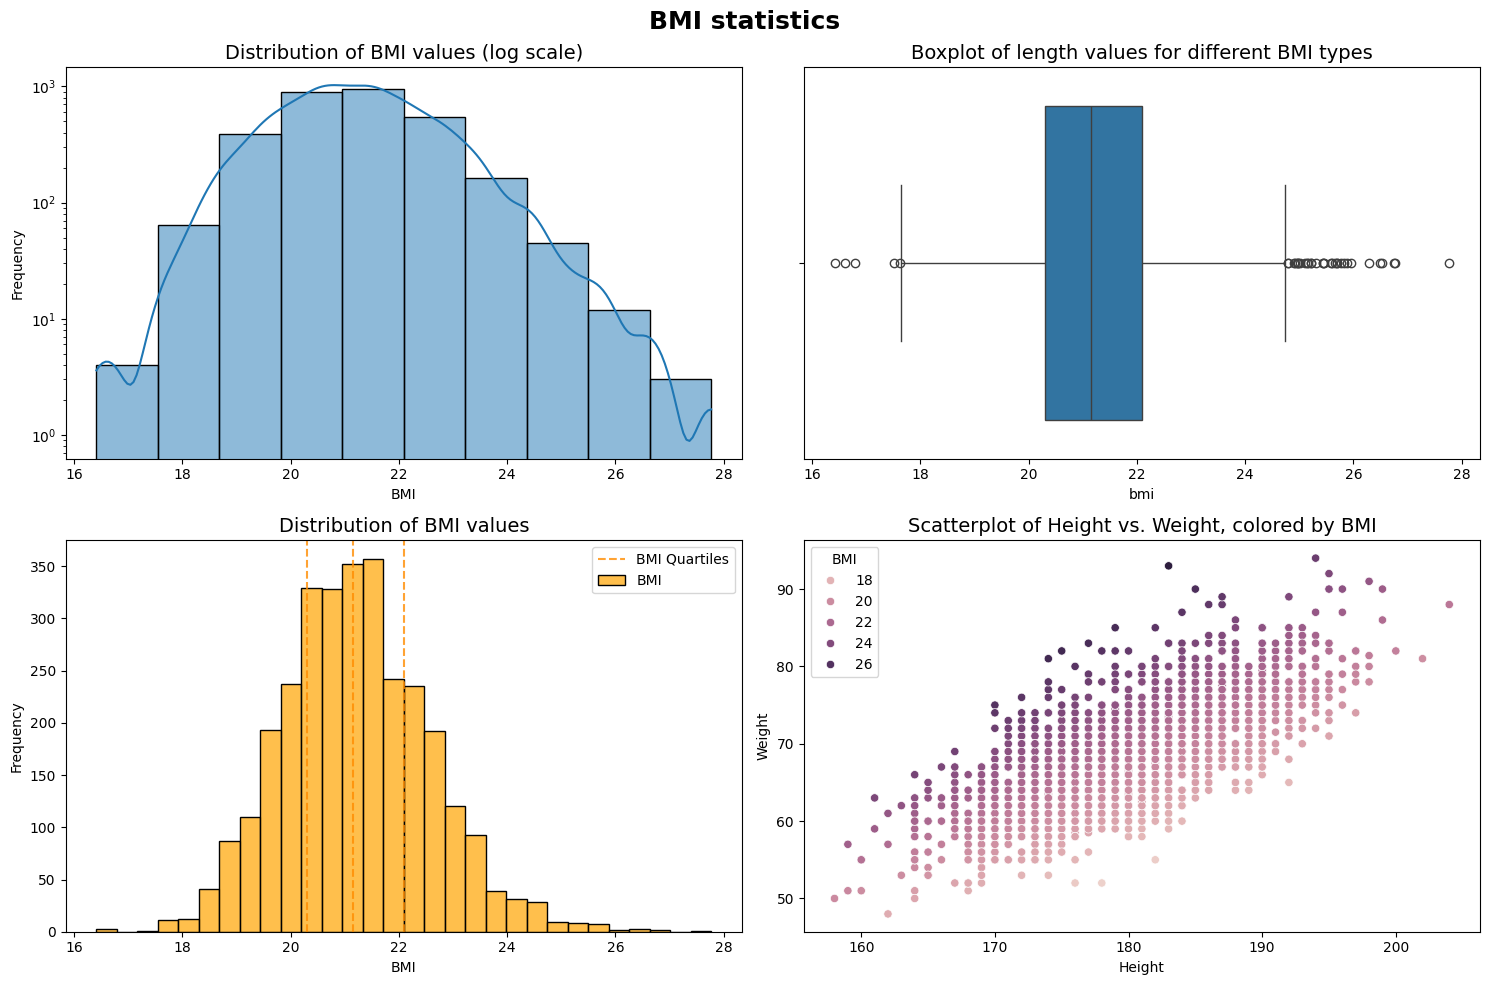

In [78]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

fig.suptitle('BMI statistics', fontsize=18, fontweight='bold')

sns.histplot(cyclist_df['bmi'], bins=10, kde=True, ax=ax[0, 0])
ax[0, 0].set_xlabel('BMI')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_yscale('log')
ax[0, 0].set_title('Distribution of BMI values (log scale)', fontsize=14)

sns.boxplot(data=cyclist_df, x='bmi', ax=ax[0, 1])
ax[0, 1].set_title('Boxplot of length values for different BMI types', fontsize=14)
ax[0, 1].set_xlabel('bmi')

sns.histplot(cyclist_df['bmi'], bins=30, color='orange', alpha=0.7, ax=ax[1, 0], label='BMI')
bmi_quantiles = cyclist_df['bmi'].quantile([0.25, 0.5, 0.75])
for i, q in enumerate(bmi_quantiles):
    label = 'BMI Quartiles' if i == 0 else None
    ax[1, 0].axvline(q, linestyle='--', color='darkorange', alpha=0.8, label=label)
ax[1, 0].set_xlabel('BMI')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('Distribution of BMI values', fontsize=14)
ax[1, 0].legend()

sns.scatterplot(data=cyclist_df, x='height', y='weight', hue='bmi', ax=ax[1, 1])
ax[1, 1].set_xlabel('Height')
ax[1, 1].set_ylabel('Weight')
ax[1, 1].set_title('Scatterplot of Height vs. Weight, colored by BMI', fontsize=14)
ax[1, 1].legend(title='BMI')


plt.tight_layout()
plt.show()

Looks like the mean bmi stands a bit below the European average. Some outliers appear, with particular frequency on the "bulkier" side. Cycling is a lot of cardiovascular work and athletes need to balance a good muscular density whilist not weighing too much.

The scatterplot hints at a correlation between height and weight. Taller cyclists tend to be heavier, which stands to reason. Of course, the BMI increases if the weight increases but the height is fixed. What is interesting is that the BMI is precisely the "measure of correlation" between height and weight: if height and weight were perfectly correlated the BMI would be a constant (i.e. all cyclists would have the same BMI). Vice versa, the less "concentrated" the BMI, the less correlated are height and weight.

##### `BMI` vs `total_points`

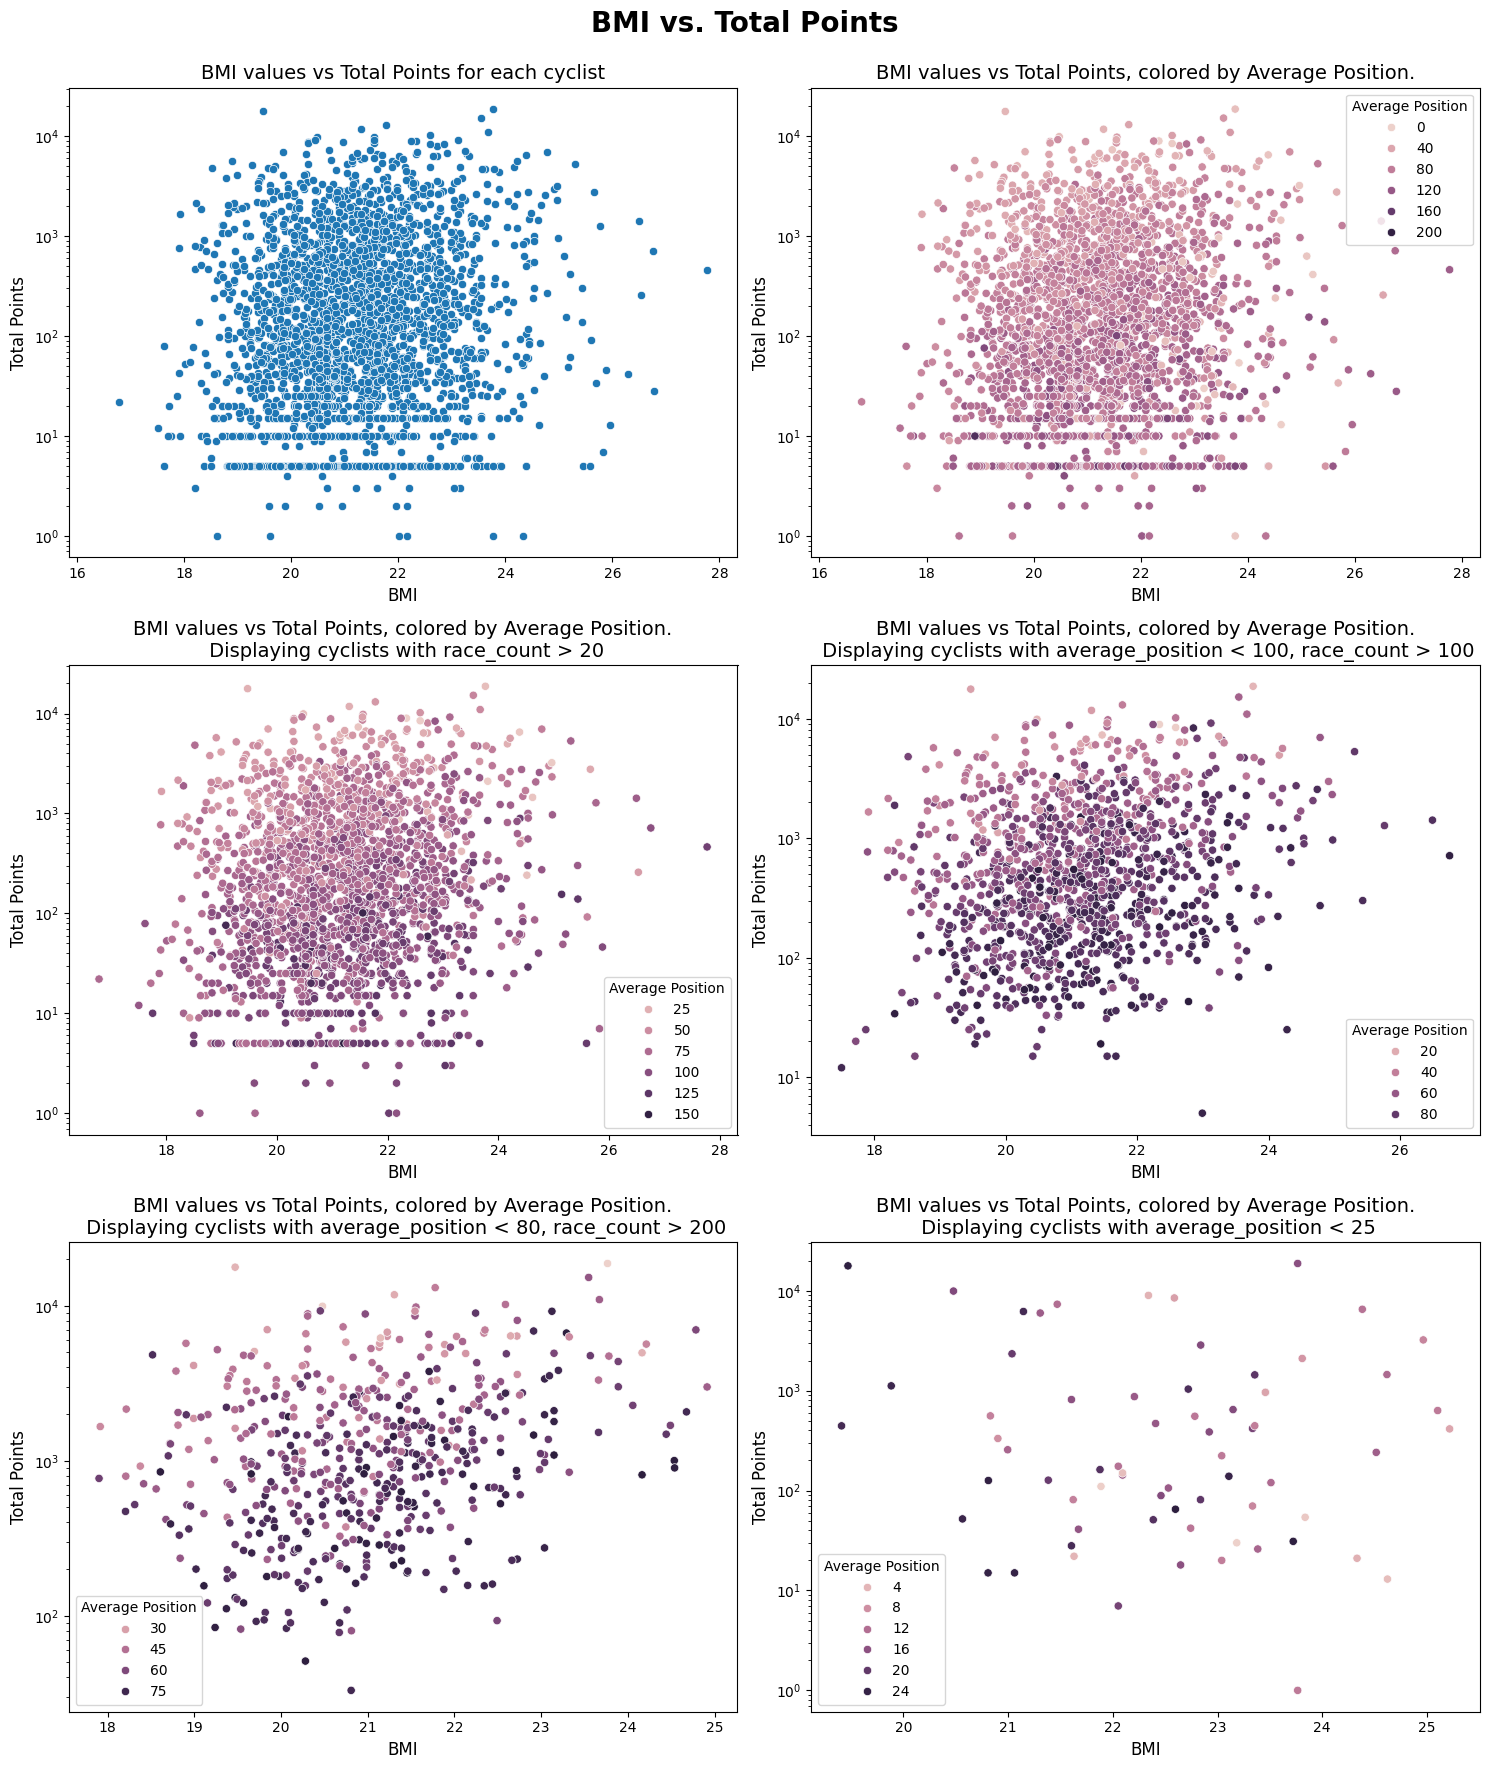

In [79]:
# Analyze the relationship between cyclist_df.bmi and races_df.uci_points.

fig, axes = plt.subplots(3,2, figsize=(15,18))
fig.suptitle('BMI vs. Total Points\n', fontsize=20, fontweight='bold')

sns.scatterplot(data=exclude_non_partecipants_df, x='bmi', y='total_points', ax=axes[0, 0])
axes[0, 0].set_title('BMI values vs Total Points for each cyclist', fontsize=14)
axes[0, 0].set_xlabel('BMI', fontsize=12)
axes[0, 0].set_ylabel('Total Points', fontsize=12)
axes[0, 0].set_yscale('log')

sns.scatterplot(data=exclude_non_partecipants_df, x='bmi', y='total_points', hue='average_position', ax=axes[0, 1])
axes[0, 1].set_title('BMI values vs Total Points, colored by Average Position.', fontsize=14)
axes[0, 1].set_xlabel('BMI', fontsize=12)
axes[0, 1].set_ylabel('Total Points', fontsize=12)
axes[0, 1].set_yscale('log')
axes[0, 1].legend(title='Average Position')

avg_pos_thresh = (100, 80, 25)
race_count_thresh = (20, 100, 200)

sns.scatterplot(data=even_more_filtering(exclude_non_partecipants_df, race_count_min=race_count_thresh[0]), 
                x='bmi', y='total_points', hue='average_position', ax=axes[1, 0])
axes[1, 0].set_title(f'BMI values vs Total Points, colored by Average Position.\n Displaying cyclists with race_count > {race_count_thresh[0]}', fontsize=14)
axes[1, 0].set_xlabel('BMI', fontsize=12)
axes[1, 0].set_ylabel('Total Points', fontsize=12)
axes[1, 0].set_yscale('log')
axes[1, 0].legend(title='Average Position')

sns.scatterplot(data=even_more_filtering(exclude_non_partecipants_df, avg_pos_max=avg_pos_thresh[0], race_count_min=race_count_thresh[1]), 
                x='bmi', y='total_points', hue='average_position', ax=axes[1, 1])
axes[1, 1].set_title(f'BMI values vs Total Points, colored by Average Position.\n Displaying cyclists with average_position < {avg_pos_thresh[0]}, race_count > {race_count_thresh[1]}', fontsize=14)
axes[1, 1].set_xlabel('BMI', fontsize=12)
axes[1, 1].set_ylabel('Total Points', fontsize=12)
axes[1, 1].set_yscale('log')
axes[1, 1].legend(title='Average Position')

sns.scatterplot(data=even_more_filtering(exclude_non_partecipants_df, avg_pos_max=avg_pos_thresh[1], race_count_min=race_count_thresh[2]), 
                x='bmi', y='total_points', hue='average_position', ax=axes[2, 0])
axes[2, 0].set_title(f'BMI values vs Total Points, colored by Average Position.\n Displaying cyclists with average_position < {avg_pos_thresh[1]}, race_count > {race_count_thresh[2]}', fontsize=14)
axes[2, 0].set_xlabel('BMI', fontsize=12)
axes[2, 0].set_ylabel('Total Points', fontsize=12)
axes[2, 0].set_yscale('log')
axes[2, 0].legend(title='Average Position')

sns.scatterplot(data=even_more_filtering(exclude_non_partecipants_df, avg_pos_max=avg_pos_thresh[2]), 
                x='bmi', y='total_points', hue='average_position', ax=axes[2, 1])
axes[2, 1].set_title(f'BMI values vs Total Points, colored by Average Position.\n Displaying cyclists with average_position < {avg_pos_thresh[2]}', fontsize=14)
axes[2, 1].set_xlabel('BMI', fontsize=12)
axes[2, 1].set_ylabel('Total Points', fontsize=12)
axes[2, 1].set_yscale('log')
axes[2, 1].legend(title='Average Position')


plt.tight_layout()
plt.show()

We put the Total Points in log scale because, as we noticed, that distribution is very skewed.

At a first glance it just looks like a mess of points. 

- Of course, as datapoints are "higher" in the plot (i.e. correspond to higher values of `total_points`), they're more lightly coloured, indicating a lower Average Position
- By applying a "gentle" filter w.r.t. `race_count` and `average_position`, we can remove part of the mess. In particular, the horizontally aligned points corresponding to 10 points circa.

For all the "levels of filtering", for all the "stratification of the analysis", the BMI values are really spread apart.
- It's not like the cyclists with better average position tend to have more or less the same BMI. Different body types win equally!

Let's bin the BMI values, and let's see that this can boost our analysis.

In [80]:
# We may need it later. Who knows?

merged_df = cyclist_df.merge(races_df, left_on='_url', right_on='cyclist', how='inner')

/tmp/ipykernel_769/3902239358.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exclude_non_partecipants_df.loc[:,'bmi_bin'] = pd.cut(exclude_non_partecipants_df.loc[:,'bmi'],


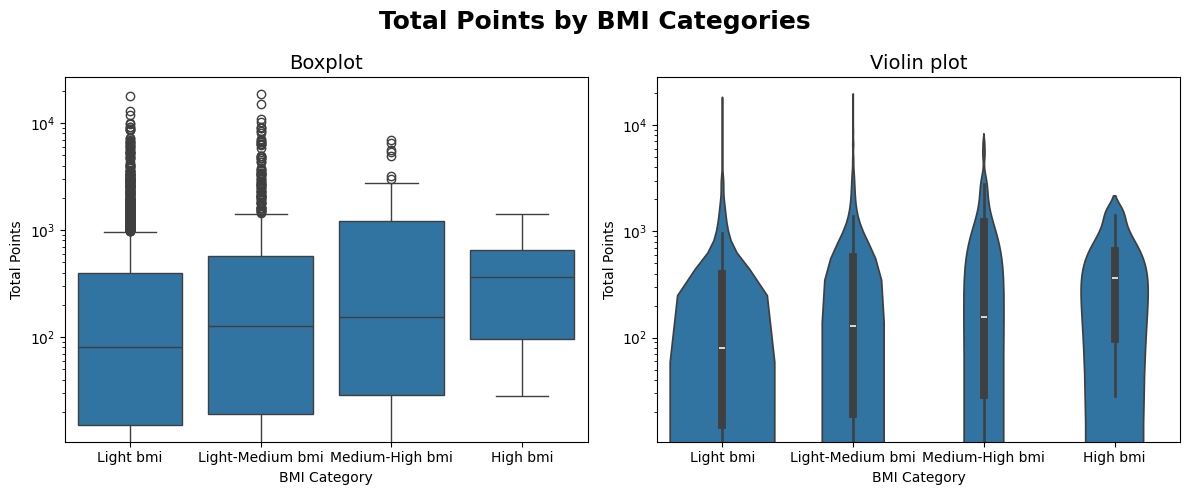

In [81]:
exclude_non_partecipants_df.loc[:,'bmi_bin'] = pd.cut(exclude_non_partecipants_df.loc[:,'bmi'], 
                                                bins=[19, 22, 24, 26, 28], 
                                                labels=['Light bmi', 'Light-Medium bmi', 'Medium-High bmi', 'High bmi'])

# Box plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Total Points by BMI Categories', fontsize=18, fontweight='bold')

sns.boxplot(data=exclude_non_partecipants_df, x='bmi_bin', y='total_points', ax=axs[0])
axs[0].set_title('Boxplot', fontsize=14)
axs[0].set_xlabel('BMI Category')
axs[0].set_ylabel('Total Points')
axs[0].set_yscale('log')

sns.violinplot(data=exclude_non_partecipants_df, x='bmi_bin', y='total_points', ax=axs[1])
axs[1].set_title('Violin plot', fontsize=14)
axs[1].set_xlabel('BMI Category')
axs[1].set_ylabel('Total Points')
axs[1].set_yscale('log')

plt.tight_layout()
plt.show()


**Da rifare**: Most BMIs seem to have a good base of riders who sit under the 70 `uci_points`. What is most interesting from this initial exploration is that there are no cyclists with an high bmi that manage to reach high values for the `uci_points`.
An interesting clustering could be based on these values and the length/steepness/stamina_index of the race, so that we may detect riders that are good on flat terrains, climbers, sprinters, etc...

##### BMI vs Average Speed

We've seen that the average speeds of the cyclists are very similar, all the values are concentrated into a small interval.

Nevertheless, we can check if athletes with different BMIs go at different speeds, on average.

In [82]:
cyclist_df.columns

Index(['_url', 'name', 'birth_year', 'weight', 'height', 'nationality', 'bmi',
       'race_count', 'experience_level', 'total_points', 'victories_by_points',
       'avg_points_per_race', 'average_position', 'avg_speed_cyclist'],
      dtype='object')

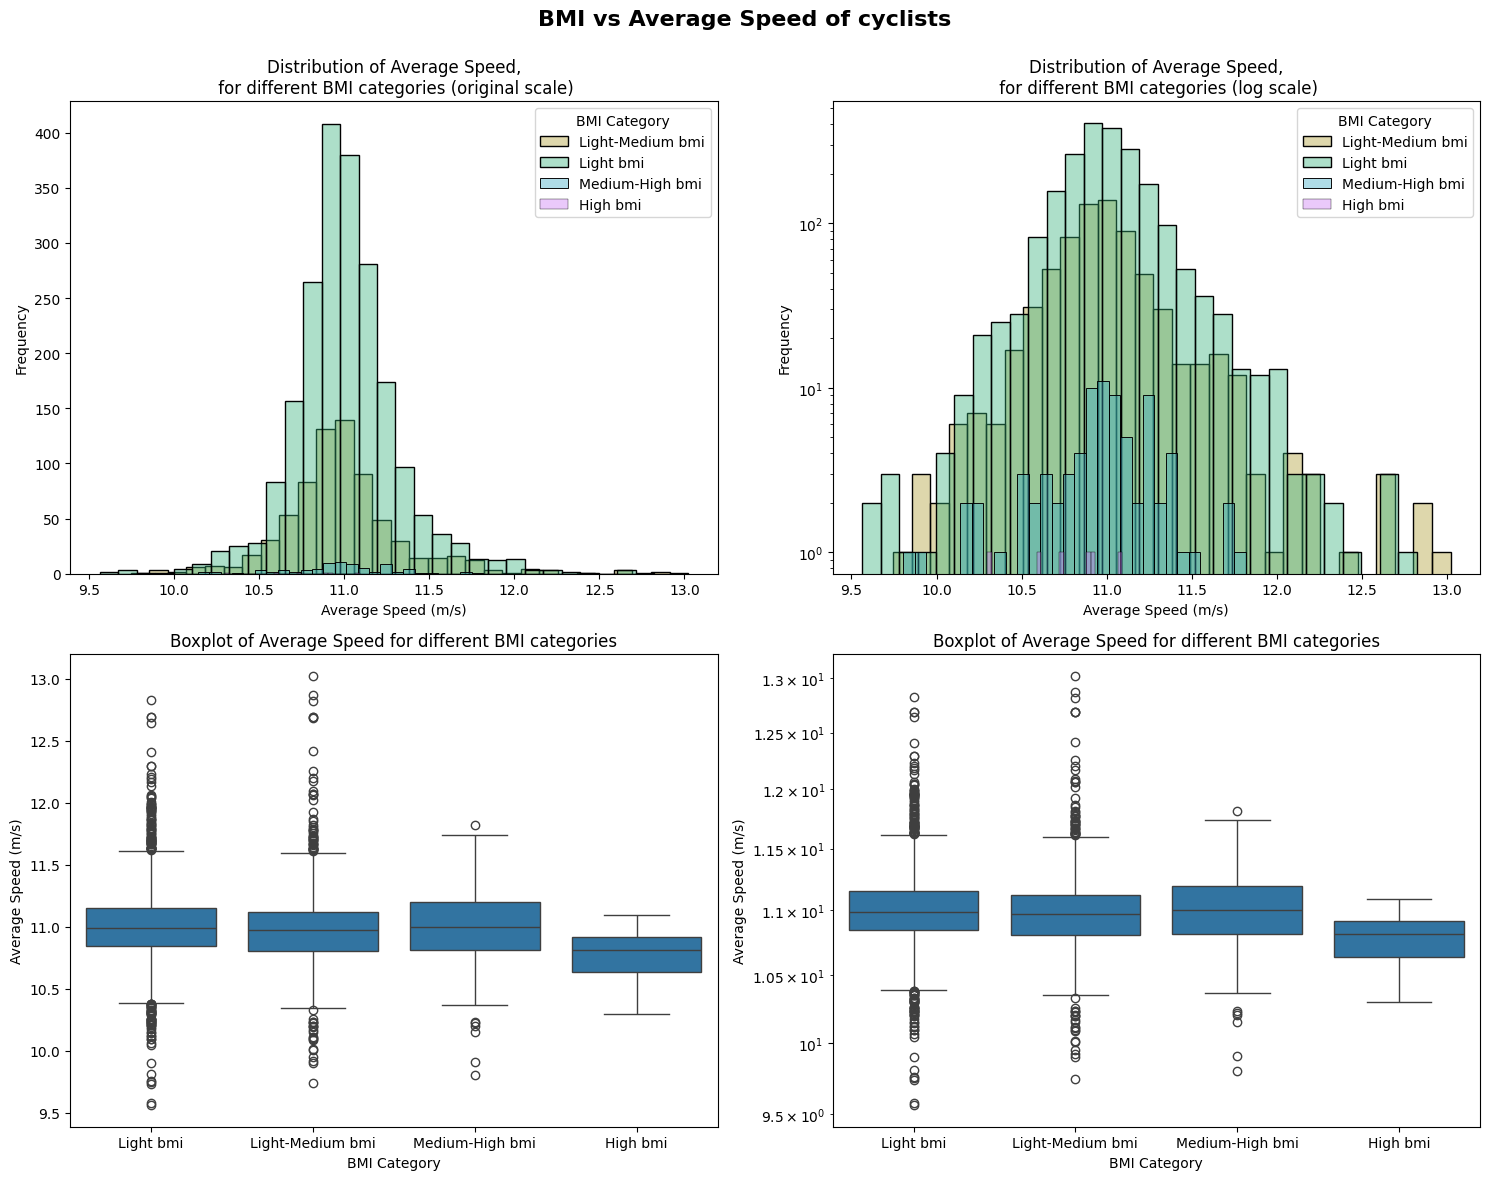

In [83]:
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("BMI vs Average Speed of cyclists\n", fontsize=16, fontweight='bold')

palette = sns.color_palette("husl", len(exclude_non_partecipants_df['bmi_bin'].unique()))
for i, bmi_bin in enumerate(exclude_non_partecipants_df['bmi_bin'].unique()):
    sns.histplot(exclude_non_partecipants_df[exclude_non_partecipants_df['bmi_bin'] == bmi_bin]['avg_speed_cyclist'], 
                 label=bmi_bin,
                 bins=30, kde=False, color=palette[i], alpha=0.4, ax=ax[0, 0])
ax[0, 0].set_title("Distribution of Average Speed,\n for different BMI categories (original scale)")
ax[0, 0].set_xlabel('Average Speed (m/s)')
ax[0, 0].set_ylabel('Frequency')
#ax[0, 0].set_yscale('log')
ax[0, 0].legend(title='BMI Category')

for i, bmi_bin in enumerate(exclude_non_partecipants_df['bmi_bin'].unique()):
    sns.histplot(exclude_non_partecipants_df[exclude_non_partecipants_df['bmi_bin'] == bmi_bin]['avg_speed_cyclist'], 
                 label=bmi_bin,
                 bins=30, kde=False, color=palette[i], alpha=0.4, ax=ax[0, 1])
ax[0, 1].set_title("Distribution of Average Speed,\n for different BMI categories (log scale)")
ax[0, 1].set_xlabel('Average Speed (m/s)')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_yscale('log')
ax[0, 1].legend(title='BMI Category')

sns.boxplot(data=exclude_non_partecipants_df, x='bmi_bin', y='avg_speed_cyclist', ax=ax[1, 0])
ax[1, 0].set_title('Boxplot of Average Speed for different BMI categories')
ax[1, 0].set_xlabel('BMI Category')
ax[1, 0].set_ylabel('Average Speed (m/s)')

sns.boxplot(data=exclude_non_partecipants_df, x='bmi_bin', y='avg_speed_cyclist', ax=ax[1, 1])
ax[1, 1].set_title('Boxplot of Average Speed for different BMI categories')
ax[1, 1].set_xlabel('BMI Category')
ax[1, 1].set_ylabel('Average Speed (m/s)')
ax[1, 1].set_yscale('log')

plt.tight_layout()
plt.show()

*Non ho energie per commentare questa roba*

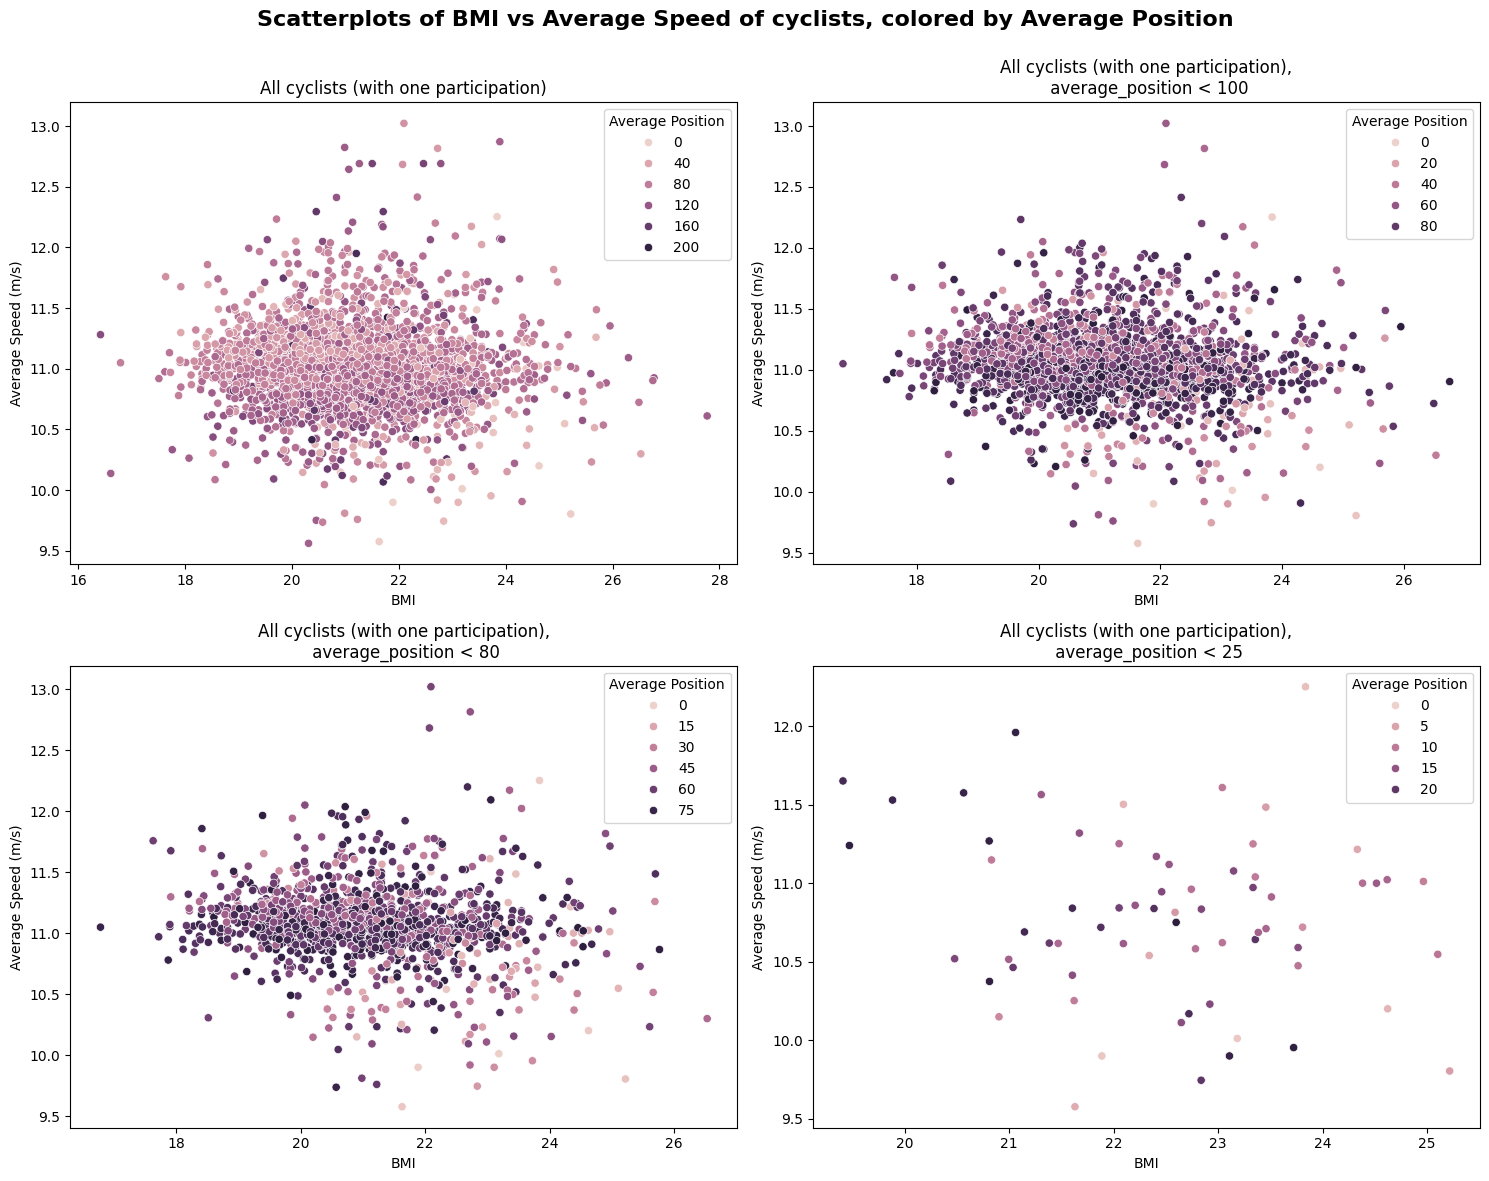

In [84]:
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
ax = ax.flatten()
fig.suptitle("Scatterplots of BMI vs Average Speed of cyclists, colored by Average Position\n", fontsize=16, fontweight='bold')

sns.scatterplot(data=exclude_non_partecipants_df, x='bmi', y='avg_speed_cyclist', hue='average_position', ax=ax[0])
ax[0].set_title('All cyclists (with one participation)')
ax[0].set_xlabel('BMI')
ax[0].set_ylabel('Average Speed (m/s)')
ax[0].legend(title='Average Position')

for i, thresh in enumerate(avg_pos_thresh, 1):
    sns.scatterplot(data=exclude_non_partecipants_df[exclude_non_partecipants_df['average_position'] < thresh], 
                    x='bmi', y='avg_speed_cyclist', hue='average_position', ax=ax[i])
    ax[i].set_title(f'All cyclists (with one participation),\n average_position < {thresh}')
    ax[i].set_xlabel('BMI')
    ax[i].set_ylabel('Average Speed (m/s)')
    ax[i].legend(title='Average Position')

plt.tight_layout()
plt.show()

- The top right scatterplot just shows a bulk of points
- When we exclude the cyclists with a poor average position, the blob of points is stil there, even though few points that are outside of the fringe (corresponding to high speed, and a BMI between 20 and 22) disappear. This is an interesting phenomenon
- The third scatterplot shows how the points on the "fringe", with a BMI above 22 and a lower average speed, actually are those with a better average position
- Yet again, the last scatterplot shows how the cyclists that have a very good average position don't tend to go faster than the others, nor tend to have a lower BMI (we already knew this)

#### Exploring the `average_points_per_race` feature

We've used the `total_points` feature in the previous analyses. This screams for an analysis of the `average_points_per_race` feature!

In [85]:
cyclist_df['avg_points_per_race'].describe()

count    6134.000000
mean        4.287532
std         7.778696
min         0.000000
25%         0.348837
50%         1.553851
75%         5.000000
max       150.000000
Name: avg_points_per_race, dtype: float64

We can see that the mean is pretty far from the median. We expect a skewed distribution, in which few cyclists have a high value for this feature. Another hint at this is the fact that the maximum value, 150, is far away from the 75th percentile.

Let's begin with the `average_points` distribution.

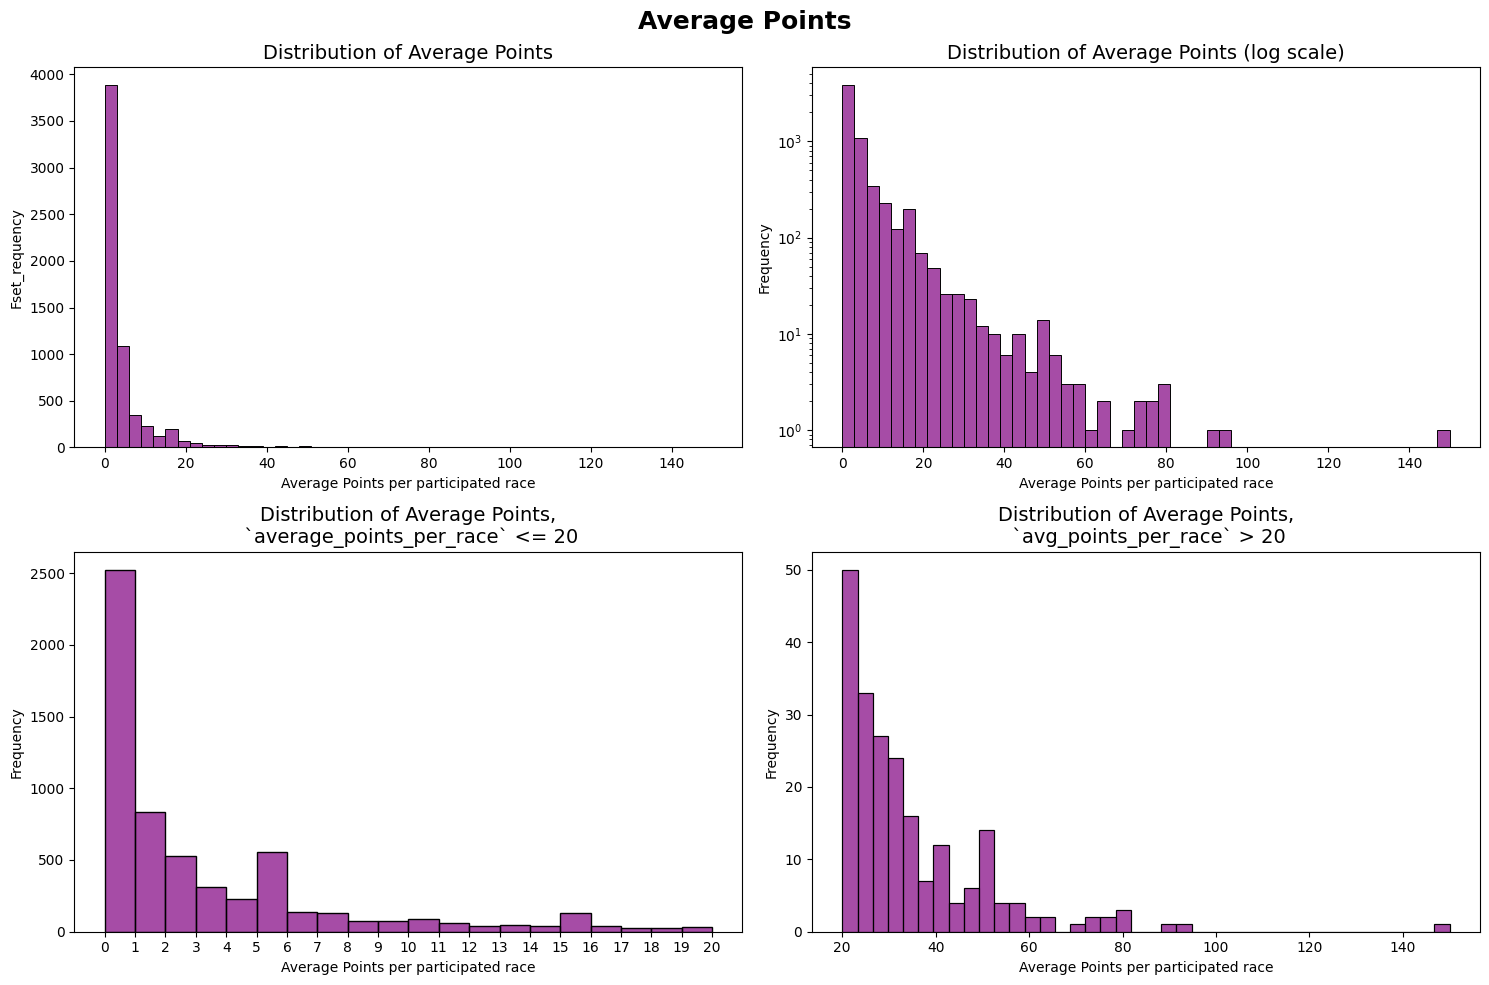

In [86]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Average Points', fontsize=18, fontweight='bold')

sns.histplot(cyclist_df['avg_points_per_race'], bins=50, kde=False, color='purple', alpha=0.7, ax=ax[0, 0])
ax[0, 0].set_title('Distribution of Average Points', fontsize=14)
ax[0, 0].set_xlabel('Average Points per participated race')
ax[0, 0].set_ylabel('Fset_requency')


sns.histplot(cyclist_df['avg_points_per_race'], bins=50, kde=False, color='purple', alpha=0.7, ax=ax[0, 1])
ax[0, 1].set_title('Distribution of Average Points (log scale)', fontsize=14)
ax[0, 1].set_xlabel('Average Points per participated race')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_yscale('log')

avg_points_per_race_thresh = 20
sns.histplot(cyclist_df.loc[cyclist_df['avg_points_per_race'] <= avg_points_per_race_thresh, 'avg_points_per_race'], bins=20, kde=False, color='purple', alpha=0.7, ax=ax[1, 0])
ax[1, 0].set_title(f'Distribution of Average Points,\n `average_points_per_race` <= {avg_points_per_race_thresh}', fontsize=14)
ax[1, 0].set_xlabel('Average Points per participated race')
ax[1, 0].set_xticks(np.arange(0, 21))
ax[1, 0].set_ylabel('Frequency')
#ax[1, 0].set_yscale('log')

sns.histplot(cyclist_df.loc[cyclist_df['avg_points_per_race'] > avg_points_per_race_thresh, 'avg_points_per_race'], bins=40, kde=False, color='purple', alpha=0.7, ax=ax[1, 1])
ax[1, 1].set_title(f'Distribution of Average Points,\n `avg_points_per_race` > {avg_points_per_race_thresh}', fontsize=14)
ax[1, 1].set_xlabel('Average Points per participated race')
ax[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

As expected, the distribution is extremely skewed towards lower values, and quickly decays. The bulk of it is before the value of 20.

Ok, who's got more than 60 points on average? That's a lot of points to get on average on a single race! 

By Chebychev inequality, the probability that a cyclist has a value for  `avg_points_per_race` that is greater than $\mu+8\cdot\sigma\approx 66.52$ is less than or equal to $\frac{1}{64}\approx 0.015$. Therefore we can say that cyclists with such high average points make no more than $1.5\%$ of the distribution.

In [87]:
chebychev_thresh = cyclist_df['avg_points_per_race'].mean() + 8*cyclist_df['avg_points_per_race'].std()
cyclist_df[cyclist_df['avg_points_per_race'] >= chebychev_thresh]

_url                 name  birth_year  weight  height  \
226   jean-pierre-monsere  Jean-Pierre Monseré      1948.0    66.0   178.0   
293        frans-verbeeck       Frans Verbeeck      1941.0     NaN     NaN   
427           eddy-merckx          Eddy Merckx      1945.0    74.0   182.0   
960       francesco-moser      Francesco Moser      1951.0    79.0   180.0   
992    roger-de-vlaeminck   Roger De Vlaeminck      1947.0    74.0   181.0   
2176             les-west             Les West      1943.0    70.0   178.0   
2675      frans-kerremans      Frans Kerremans      1947.0     NaN     NaN   
2896            luca-rota            Luca Rota      1963.0     NaN     NaN   
3730       felice-gimondi       Felice Gimondi      1942.0    78.0   181.0   
5018      enrico-maggioni      Enrico Maggioni      1946.0     NaN     NaN   
5417            mike-neel            Mike Neel      1951.0    79.0   184.0   

        nationality        bmi  race_count experience_level  total_points  \
226         Belgium  20.830703         7.0         beginner         559.0   
293         Belgium        NaN        52.0      competitive        4916.0   
427         Belgium  22.340297       111.0         semi-pro        8976.0   
960           Italy  24.382716        86.0      competitive        6517.0   
992         Belgium  22.587833       114.0         semi-pro        8465.0   
2176  Great Britain  22.093170         1.0         beginner         150.0   
2675        Belgium        NaN         3.0         beginner         223.0   
2896          Italy        NaN         1.0         beginner          90.0   
3730          Italy  23.808797        27.0       developing        2099.0   
5018          Italy        NaN         2.0         beginner         160.0   
5417  United States  23.334121         1.0         beginner          70.0   

      victories_by_points  avg_points_per_race  average_position  \
226                     1            79.857143          9.714286   
293                     5            94.538462          5.115385   
427                    21            80.864865          4.189189   
960                    10            75.779070         11.360465   
992                    13            74.254386          6.252174   
2176                    0           150.000000          3.000000   
2675                    0            74.333333         16.666667   
2896                    0            90.000000          5.000000   
3730                    3            77.740741          7.296296   
5018                    0            80.000000          6.000000   
5417                    0            70.000000          9.000000   

      avg_speed_cyclist  
226           11.149136  
293           10.951318  
427           10.539823  
960           11.000983  
992           10.815050  
2176          11.503743  
2675          11.528674  
2896          10.502929  
3730          10.720673  
5018          10.669630  
5417          11.251319

We can see cyclists that have a great average because they just participated to a single race, won it, and then left; but there are also cyclists that have a high attendance, such as Eddy Merckx. That's specifically the problem with averages: they put everything together.

Let's see things a little bit closer, thresholding as we've done earlier for the average position.

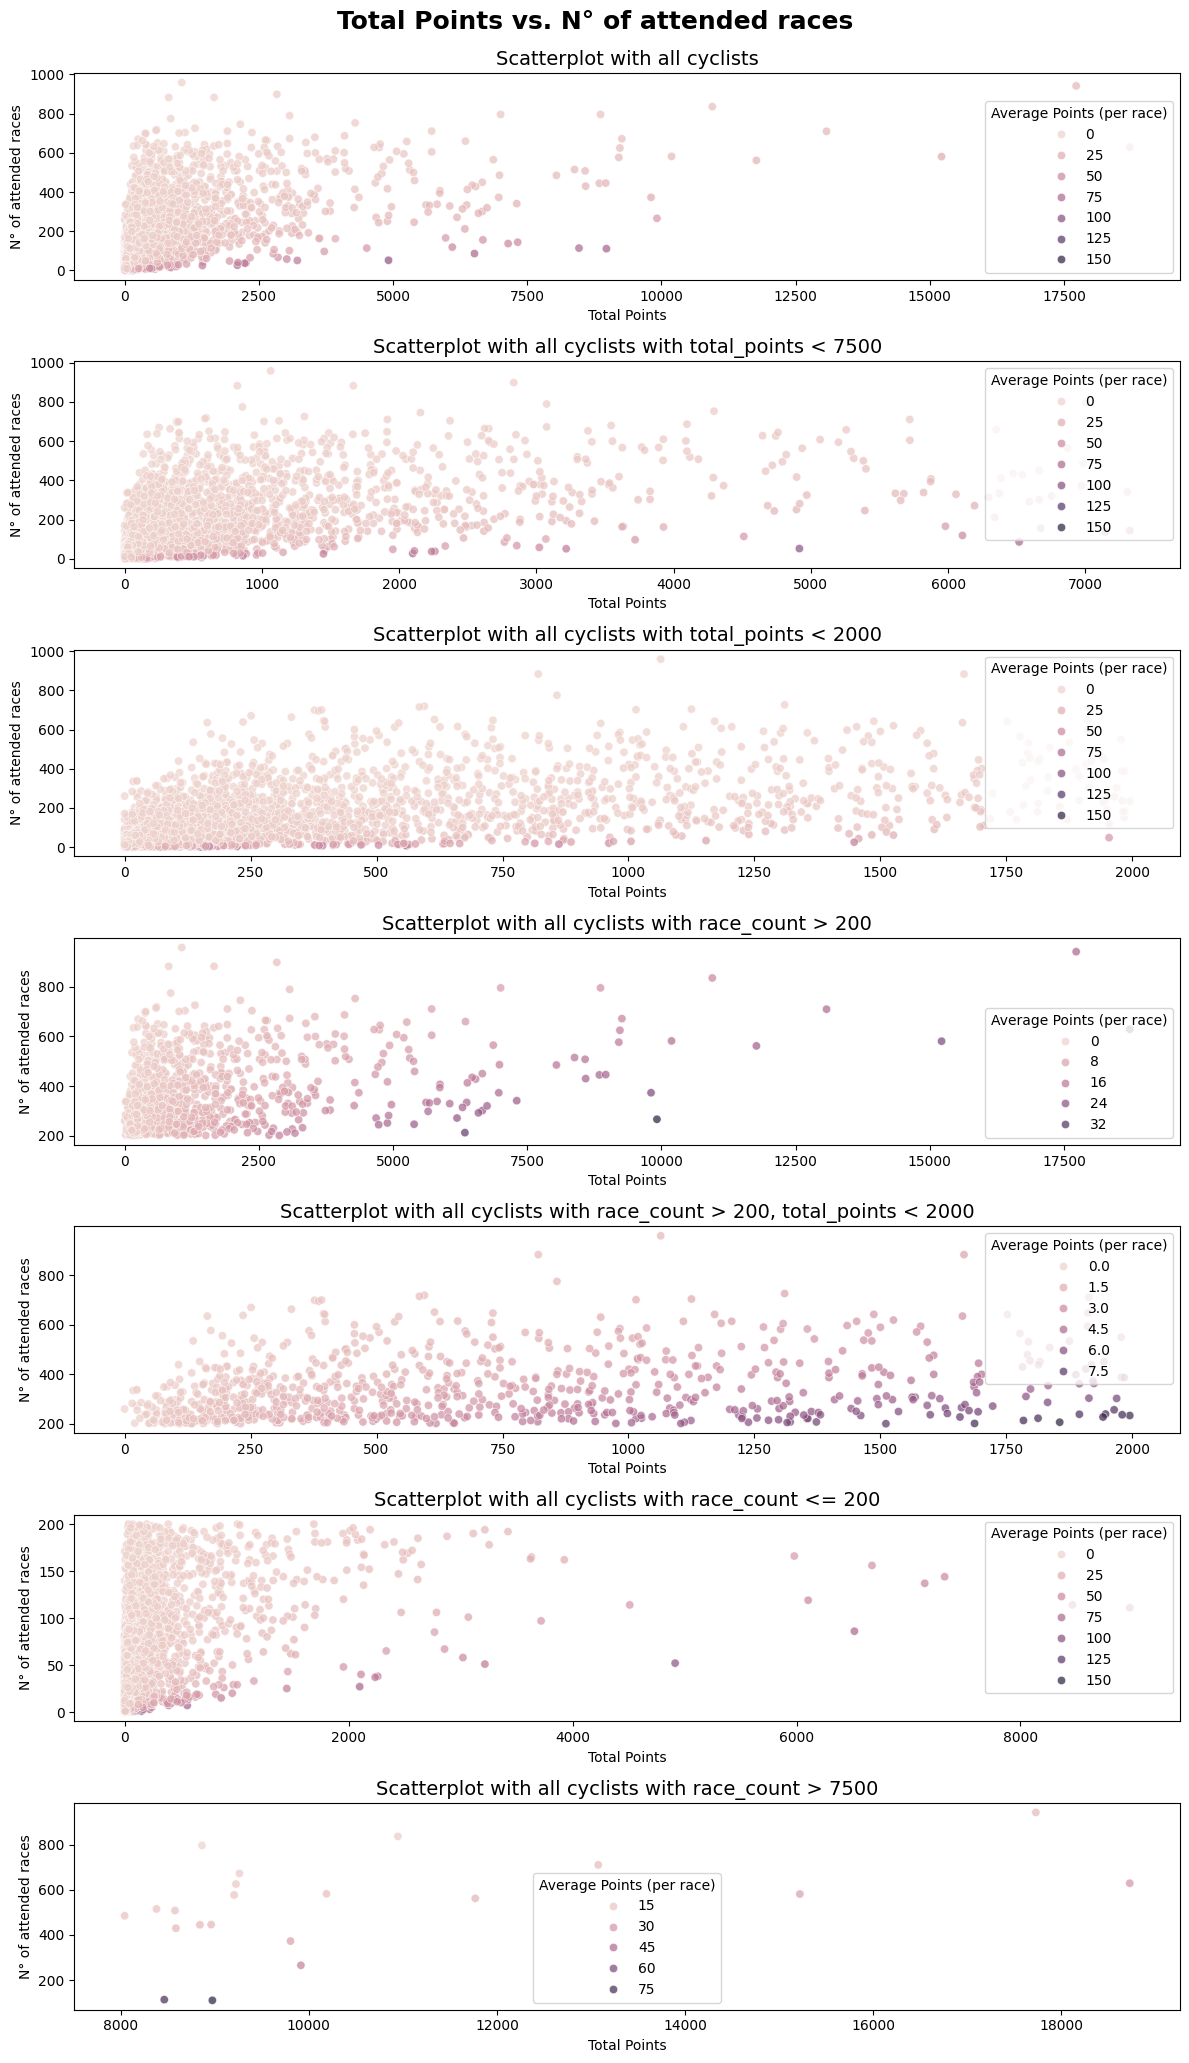

In [88]:
fig, axs = plt.subplots(7, 1, figsize=(12, 21))
fig.suptitle('Total Points vs. N° of attended races\n', fontsize=18, fontweight='bold')

sns.scatterplot(data=cyclist_df, x='total_points', y='race_count', hue='avg_points_per_race', alpha=0.7, ax=axs[0])
axs[0].set_title('Scatterplot with all cyclists', fontsize=14)
axs[0].set_xlabel('Total Points')
axs[0].set_ylabel('N° of attended races')
axs[0].legend(title='Average Points (per race)')

sns.scatterplot(data=cyclist_df[cyclist_df['total_points'] < TOT_PTS_THRESHOLD], x='total_points', y='race_count', hue='avg_points_per_race', alpha=0.7, ax=axs[1])
axs[1].set_title(f'Scatterplot with all cyclists with total_points < {TOT_PTS_THRESHOLD}', fontsize=14)
axs[1].set_xlabel('Total Points')
axs[1].set_ylabel('N° of attended races')
axs[1].legend(title='Average Points (per race)')

tot_pts_thresh = 2000
sns.scatterplot(data=cyclist_df[cyclist_df['total_points'] < tot_pts_thresh], x='total_points', y='race_count', hue='avg_points_per_race', alpha=0.7, ax=axs[2])
axs[2].set_title(f'Scatterplot with all cyclists with total_points < {tot_pts_thresh}', fontsize=14)
axs[2].set_xlabel('Total Points')
axs[2].set_ylabel('N° of attended races')
axs[2].legend(title='Average Points (per race)')


sns.scatterplot(data=cyclist_df[cyclist_df['race_count'] > race_count_thresh[-1]], x='total_points', y='race_count', hue='avg_points_per_race', alpha=0.7, ax=axs[3])
axs[3].set_title(f'Scatterplot with all cyclists with race_count > {race_count_thresh[-1]}', fontsize=14)
axs[3].set_xlabel('Total Points')
axs[3].set_ylabel('N° of attended races')
axs[3].legend(title='Average Points (per race)')

sns.scatterplot(data=cyclist_df[(cyclist_df['race_count'] > race_count_thresh[-1]) & (cyclist_df['total_points'] < tot_pts_thresh)], x='total_points', y='race_count', hue='avg_points_per_race', alpha=0.7, ax=axs[4])
axs[4].set_title(f'Scatterplot with all cyclists with race_count > {race_count_thresh[-1]}, total_points < {tot_pts_thresh}', fontsize=14)
axs[4].set_xlabel('Total Points')
axs[4].set_ylabel('N° of attended races')
axs[4].legend(title='Average Points (per race)')

sns.scatterplot(data=cyclist_df[cyclist_df['race_count'] <= race_count_thresh[-1]], x='total_points', y='race_count', hue='avg_points_per_race', alpha=0.7, ax=axs[5])
axs[5].set_title(f'Scatterplot with all cyclists with race_count <= {race_count_thresh[-1]}', fontsize=14)
axs[5].set_xlabel('Total Points')
axs[5].set_ylabel('N° of attended races')
axs[5].legend(title='Average Points (per race)')

sns.scatterplot(data=cyclist_df[cyclist_df['total_points'] > TOT_PTS_THRESHOLD], x='total_points', y='race_count', hue='avg_points_per_race', alpha=0.7, ax=axs[6])
axs[6].set_title(f'Scatterplot with all cyclists with race_count > {TOT_PTS_THRESHOLD}', fontsize=14)
axs[6].set_xlabel('Total Points')
axs[6].set_ylabel('N° of attended races')
axs[6].legend(title='Average Points (per race)')

plt.tight_layout()
plt.show()

Since both the `race_count` and `total_points` distributions are extremely skewed towards low values, it's expected that the bulk of points is found in the bottom left part of the scatterplot.

Here's some insights:
- Of couse the datapoints with same value of `total_points` but a smaller value for `race_count` are colored darker, as they're relative to a higher average
- Even by thresholding the `total_points` values (7500, then 2000), the bulk at the bottom left corner is still visible. The two different thresholds don't allow for a comparative analysis
- If we just consider the datapoints that have `race_count` values over 200 (in the tail of the `race_count` distribution), then the values for `average_points` drop significantly. By narrowing even further in the [0, 2000] range of `total_points`, the average drops even further.
- The high `average_points` values are retrieved in the [0, 200] range of the `race_count` feature. Thus, the cyclists with a high average got it by winning a lot in a few races, not so much by racing a lot and getting average results.
- If we focus on the cyclists with a high number of points, again we see that they partecipated at between 100 and 900 races, and the `average_points` values are a lot (15 or more). This means that cyclists who won a lot also did very well on average.

#### `experience_level`

Experience level is a feature that we derived by simply "cutting" based on the number of races attended by a cyclist. Thus, it might not be really indicative. This is why it's important to study it!

Now, what insights might we gain from the `experience_level` of a cyclist?

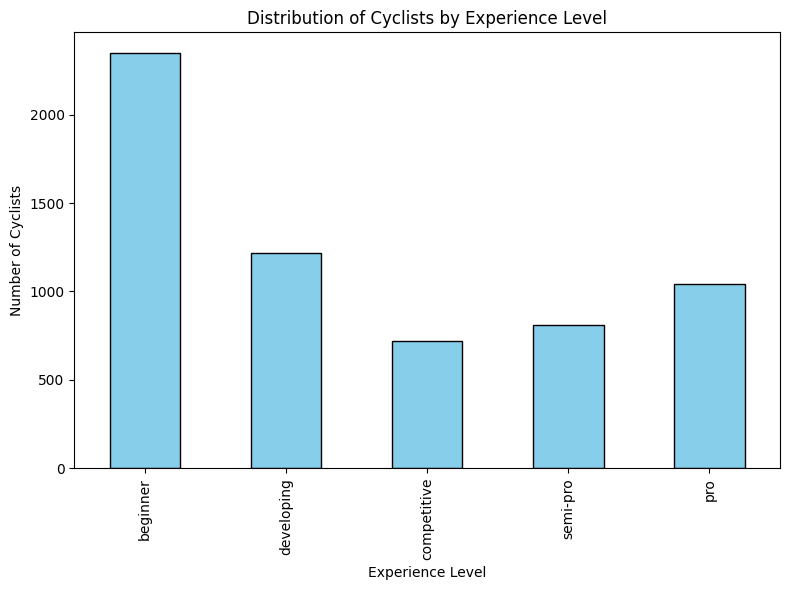

In [89]:
fig, ax = plt.subplots(figsize=(8, 6))
cyclist_df['experience_level'].value_counts().sort_index().plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
ax.set_title('Distribution of Cyclists by Experience Level')
ax.set_xlabel('Experience Level')
ax.set_ylabel('Number of Cyclists')
plt.tight_layout()
plt.show()


The distribution is quite skewed towards beginners. Also, seems that pro cyclists are more represented in the dataset than semi-pro and competitives. We expected the density to decrease monotonically. How do they distribute with respect to the age? 

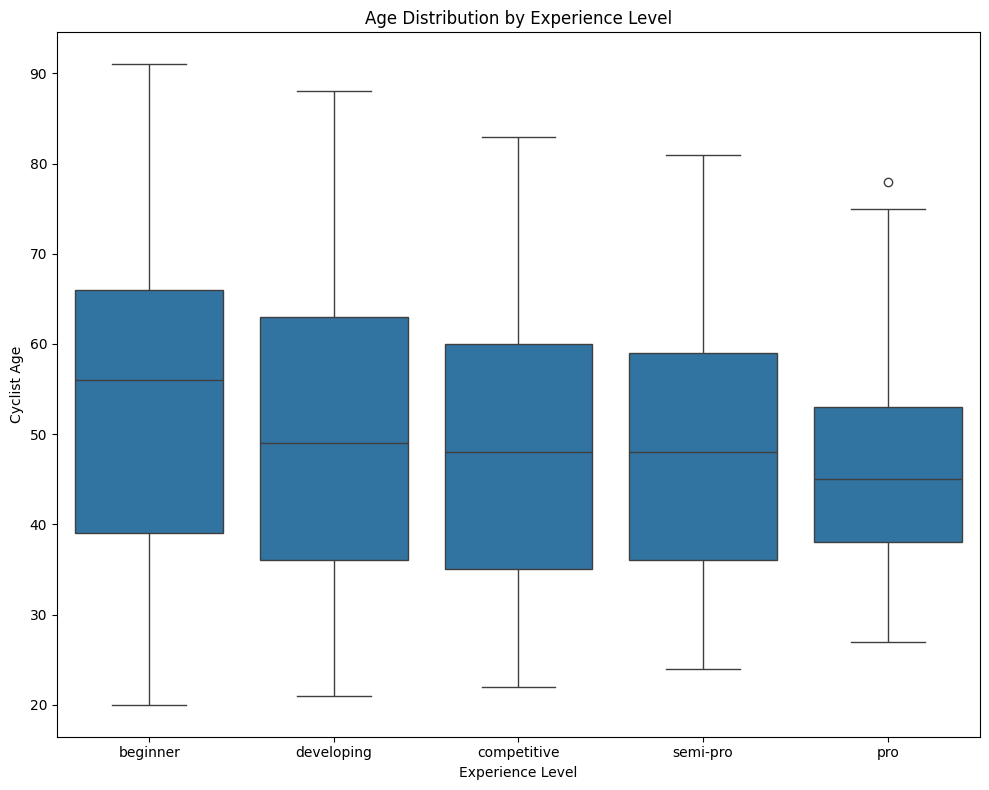

In [90]:
import datetime
current_year = datetime.datetime.now().year
cyclist_df['cyclist_age'] = current_year - cyclist_df['birth_year']

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=cyclist_df, x='experience_level', y='cyclist_age', ax=ax)
ax.set_title('Age Distribution by Experience Level')
ax.set_xlabel('Experience Level')
ax.set_ylabel('Cyclist Age')
plt.tight_layout()
plt.show()

Considering the fact that there are a lot of cyclists that ran in *ancient* races, we expected a lot more cyclists to be considered methusalems! Also, we can see that pro level cyclists tend to sit into a narrower distribution. 

##### `experience_level` vs `average_points`

/tmp/ipykernel_769/3880604516.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exclude_non_partecipants_df.loc[:,'less_7500_pts'] = exclude_non_partecipants_df.loc[:, 'total_points'] < 7500


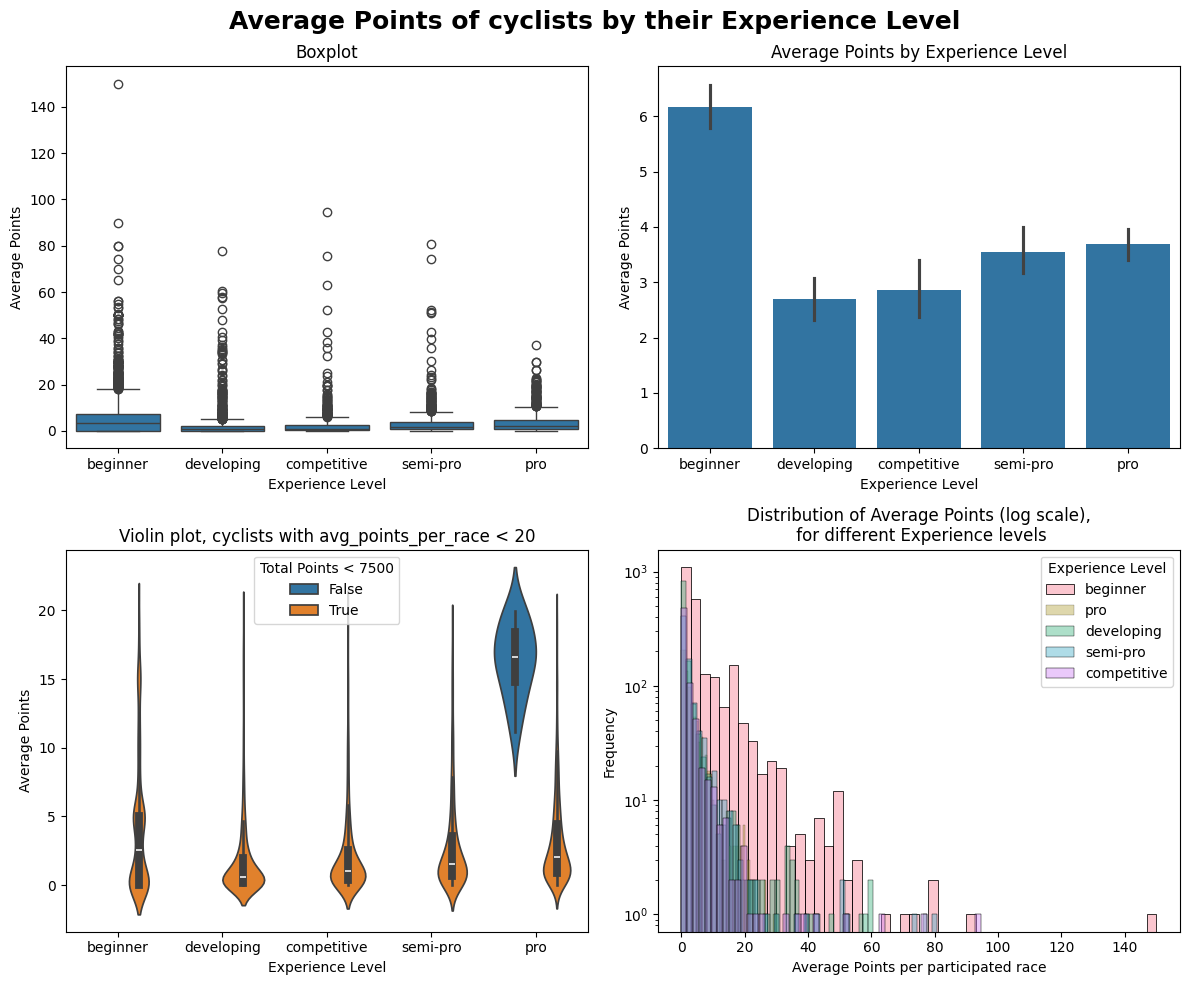

In [91]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Average Points of cyclists by their Experience Level', fontsize=18, fontweight='bold')

sns.boxplot(data=exclude_non_partecipants_df, x='experience_level', y='avg_points_per_race', ax=ax[0, 0])
ax[0, 0].set_title('Boxplot')
ax[0, 0].set_xlabel('Experience Level')
ax[0, 0].set_ylabel('Average Points')

# sns.stripplot(data = cyclist_df, x='experience_level', y= 'avg_points_per_race', ax=ax[1])
sns.barplot(data=exclude_non_partecipants_df, x='experience_level', y='avg_points_per_race', ax=ax[0, 1])
ax[0, 1].set_title('Average Points by Experience Level')
ax[0, 1].set_xlabel('Experience Level')
ax[0, 1].set_ylabel('Average Points')

exclude_non_partecipants_df.loc[:,'less_7500_pts'] = exclude_non_partecipants_df.loc[:, 'total_points'] < 7500
exclude_non_partecipants_df.loc[:,'less_7500_pts'] = exclude_non_partecipants_df.loc[:, 'total_points'] < 7500
sns.violinplot(data=exclude_non_partecipants_df[exclude_non_partecipants_df['avg_points_per_race'] < avg_points_per_race_thresh], x='experience_level', y='avg_points_per_race', hue='less_7500_pts', ax=ax[1, 0])
ax[1, 0].set_title(f'Violin plot, cyclists with avg_points_per_race < {avg_points_per_race_thresh}')
ax[1, 0].set_xlabel('Experience Level')
ax[1, 0].set_ylabel('Average Points')
#ax[1, 0].set_yscale('log')
ax[1, 0].legend(title='Total Points < 7500')


palette = sns.color_palette("husl", len(exclude_non_partecipants_df['experience_level'].unique()))
for i, exp_lvl in enumerate(exclude_non_partecipants_df['experience_level'].unique()):
    sns.histplot(exclude_non_partecipants_df.loc[exclude_non_partecipants_df['experience_level'] == exp_lvl,'avg_points_per_race'], 
                 bins=50, color=palette[i], kde=False, alpha=0.4, label=exp_lvl, ax=ax[1, 1])
ax[1, 1].set_title('Distribution of Average Points (log scale),\n for different Experience levels')
ax[1, 1].set_xlabel('Average Points per participated race')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_yscale('log')
ax[1, 1].legend(title='Experience Level')


plt.tight_layout()
plt.show()


The mean `avg_points_per_race` values for each experience level are not so different. In fact, rather counterintuitively, it is the beginners that have a higher average for `avg_points_per_race`, rather counterintuitively. This is because the `experience_level` category is just given by the number of participated races, but we've seen that the "best" cyclists performed very well in the "few" races they attended. 

All in all, the relationship between the `race_count` feature and the points-related features (`avg_points_per_race` and `total_points`) is quite complicated. The fact that the distributions
$$ \mathbb{P}(\mathtt{avg\_points\_per\_race}\mid\mathtt{experience\_level}=\mathtt{e})\qquad\mathtt{e}\in\{\text{beginner},\dots,\text{pro}\}$$
are very "intertwined" is a further confirmation of this.

Maybe a more complex model of the joint distribution $\mathbb{P}(\mathtt{total\_points},\mathtt{race\_count})$ is needed, in order to gain some explaination or insight.

**DA RIVEDERE**: The distributions of average points for the different experience level reveal some insight: beginners have higher values, while from developing to pros we can see a monotonical growth. What we believe is that beginners seem exceptional because, with less races ran, exceptional performances on certain tracks are valued more. Rising stars or people whose craft hasn't been truly tested? Only future will tell. Or maybe it's the zeros.

Was it maybe because we excluded the cyclists that participated to no race?

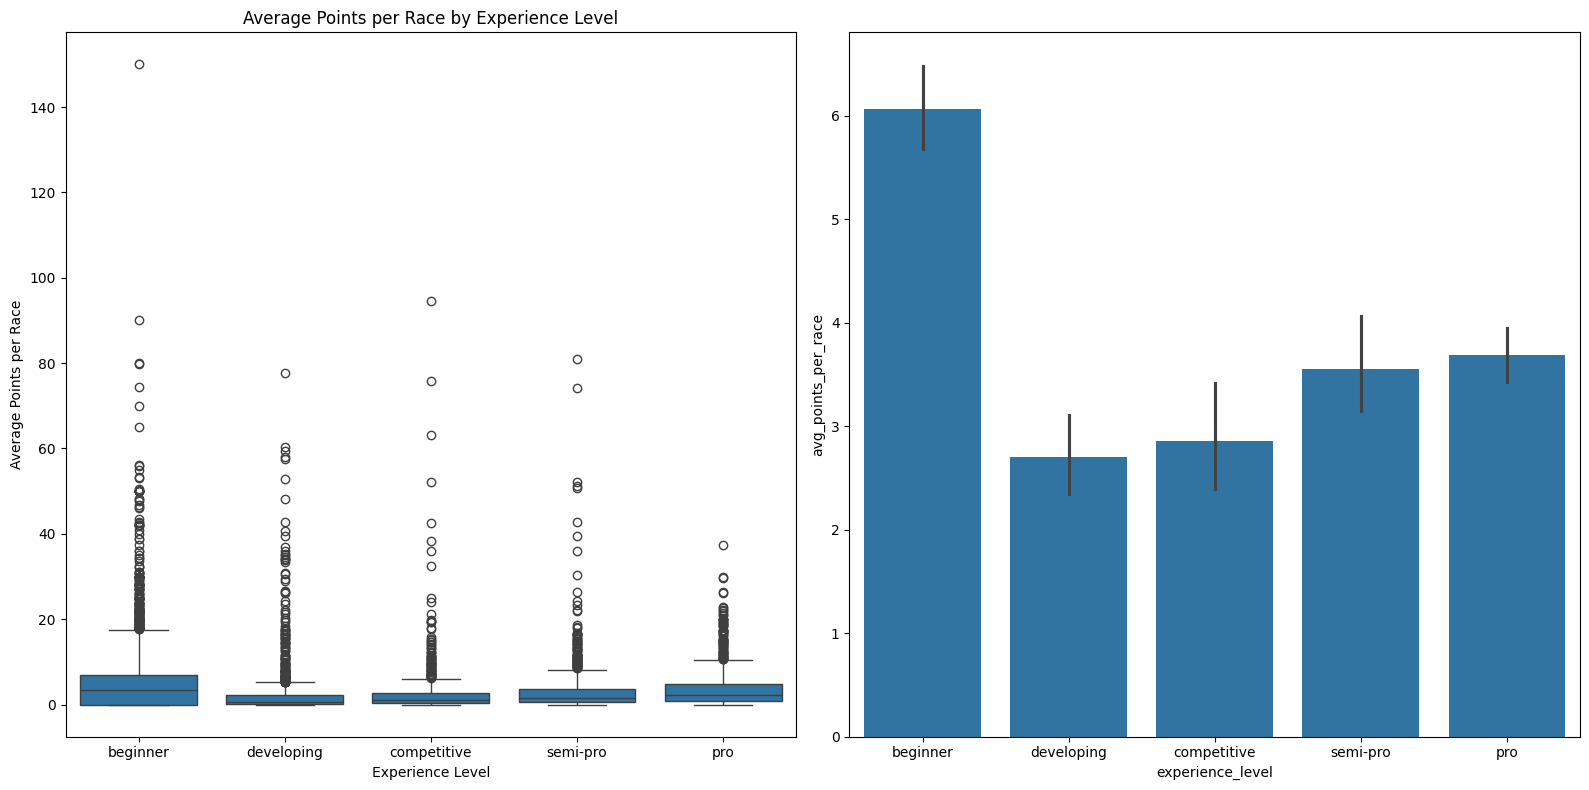

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.boxplot(data=cyclist_df, x='experience_level', y='avg_points_per_race', ax=ax[0])
ax[0].set_title('Average Points per Race by Experience Level')
ax[0].set_xlabel('Experience Level')
ax[0].set_ylabel('Average Points per Race')

sns.barplot(data=cyclist_df, x='experience_level', y='avg_points_per_race', ax=ax[1])
ax[0].set_title('Average Points per Race by Experience Level')
ax[0].set_xlabel('Experience Level')
ax[0].set_ylabel('Average Points per Race')

plt.tight_layout()
plt.show()


It's quite not the zeros.

#### Seasons

How are the races distributed over seasons? What if we consider the stages and what if we didn't?

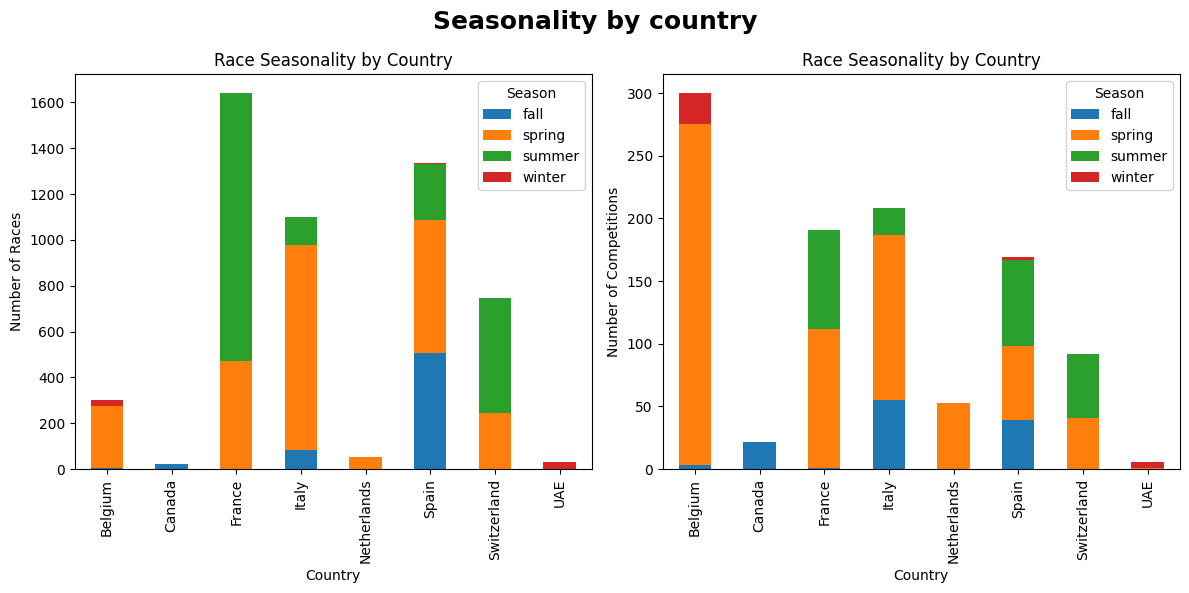

In [93]:
season_map = {0: 'winter', 1: 'spring', 2: 'summer', 3: 'fall'}

seasons_df = races_df.copy()[['_url', 'season', 'name', 'race_country']]
# We just need one row per url, actually
# Otherwise we count multiple times based on the number of participants
seasons_df.drop_duplicates(subset=['_url'], inplace=True)
# We may not need all the url, just the base one, actually
# We re-use the `get_base_url` function defined above, for the `victories_by_points` feature
seasons_df['race_url'] = seasons_df['_url'].apply(get_base_url)
seasons_df.drop(columns=['_url'], inplace=True)


# Apply the mapping to the 'season' column
seasons_df['season_name'] = seasons_df['season'].map(season_map)
seasons_df.drop(columns=['season'], inplace=True)

# Group by race_country and season_name, then count occurrences
# With this approach, each stage is counted separately
race_seasonality = seasons_df.groupby(['race_country', 'season_name']).size().unstack().fillna(0)

# Group by as before, but this time we drop duplicates based on the race_url (name and year) and season_name
# Thus, we don't count each stage separately, but if a competition is held in multiple seasons, we count it multiple times
# So, if a competition is composed of multiple stages, each held in the same season, the competition is counted just once
competitions_seasonality = seasons_df.drop_duplicates(subset=['race_url', 'season_name']).groupby(['race_country', 'season_name']).size().unstack().fillna(0)

show_numbers_on_bars = False
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Seasonality by country', fontsize=18, fontweight='bold')

race_seasonality.plot(kind='bar', stacked=True, figsize=(12, 6), ax=ax[0])
ax[0].set_title('Race Seasonality by Country')
ax[0].set_xlabel('Country')
ax[0].set_ylabel('Number of Races')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[0].legend(title='Season')

# Annotate each bar with the population count
if show_numbers_on_bars:
    for container in ax[0].containers:
    # To hide the ugly 0
        labels = [f'{int(v.get_height())}' if v.get_height() > 25 else '' for v in container]
        ax[0].bar_label(container, labels=labels, label_type='center')


competitions_seasonality.plot(kind='bar', stacked=True, figsize=(12, 6), ax=ax[1])
ax[1].set_title('Race Seasonality by Country')
ax[1].set_xlabel('Country')
ax[1].set_ylabel('Number of Competitions')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[1].legend(title='Season')

# Annotate each bar with the population count
if show_numbers_on_bars:
    for container in ax[1].containers:
    # To hide values under 30
        labels = [f'{int(v.get_height())}' if v.get_height() > 25 else '' for v in container]
        ax[1].bar_label(container, labels=labels, label_type='center')

plt.tight_layout()
plt.show()

The difference between the two plots is that the one on the left counts each individual stage in a given competition. The second one just counts the competitions, but if a certain competition (e.g. the UAE Tour) is held across multiple seasons, then is counted multiple times.

The second plot is more "truthful", but is always helpful to have both, in order to draw comparisons. 

When counting the stages, France and Spain dominate. This is because they host two Grand Tours. When we narrow the count to the single races, the numbers drastically reduce. In fact the staged races are "shrunken down"

- France has a lot of summer stages (in the dataset of course), but not so many summer competitions. This is the Tour de France's fault
- The favoured season for cycling is spring, as one can also check with the numbers. This gives another hint as to why the cyclists tend to win the races of their home country: there are too many races in a short period, so it's reasonable that a cyclist focuses on those of his country
- As expected, there are very few races held in winter.

In [94]:
race_seasonality

season_name    fall  spring  summer  winter
race_country                               
Belgium         3.0   272.0     0.0    25.0
Canada         22.0     0.0     0.0     0.0
France          1.0   471.0  1168.0     0.0
Italy          82.0   896.0   120.0     0.0
Netherlands     0.0    53.0     0.0     0.0
Spain         507.0   579.0   243.0     7.0
Switzerland     0.0   245.0   503.0     0.0
UAE             0.0     2.0     0.0    29.0

In [95]:
competitions_seasonality

season_name   fall  spring  summer  winter
race_country                              
Belgium        3.0   272.0     0.0    25.0
Canada        22.0     0.0     0.0     0.0
France         1.0   111.0    79.0     0.0
Italy         55.0   132.0    21.0     0.0
Netherlands    0.0    53.0     0.0     0.0
Spain         39.0    59.0    69.0     2.0
Switzerland    0.0    41.0    51.0     0.0
UAE            0.0     1.0     0.0     5.0

Let's see more in detail which race is held when!

In [96]:
seasons_df_uniques = seasons_df.groupby(['race_country', 'season_name'])['name'].agg(unique_names=('unique'), unique_count=(lambda x: len(np.unique(x)))).unstack().fillna('')
seasons_df_uniques

unique_names  \
season_name                                                fall   
race_country                                                      
Belgium       [Liège - Bastogne - Liège, La Flèche Wallonne,...   
Canada        [Grand Prix Cycliste de Quebec, Grand Prix Cyc...   
France                                        [Paris - Roubaix]   
Italy         [Tirreno-Adriatico, Giro d'Italia, Giro di Lom...   
Netherlands                                                       
Spain         [La Vuelta ciclista a España, Volta Ciclista a...   
Switzerland                                                       
UAE                                                               

                                                                 \
season_name                                              spring   
race_country                                                      
Belgium       [Ronde van Vlaanderen - Tour des Flandres ME, ...   
Canada                                                            
France        [Paris - Nice, Paris - Roubaix, Criterium du D...   
Italy         [Tirreno-Adriatico, Milano-Sanremo, Giro d'Ita...   
Netherlands                                  [Amstel Gold Race]   
Spain         [Volta Ciclista a Catalunya, La Vuelta ciclist...   
Switzerland                                  [Tour de Romandie]   
UAE                                                  [UAE Tour]   

                                                                 \
season_name                                              summer   
race_country                                                      
Belgium                                                           
Canada                                                            
France                  [Tour de France, Criterium du Dauphiné]   
Italy         [Giro d'Italia, Milano-Sanremo, Giro di Lombar...   
Netherlands                                                       
Spain         [Volta Ciclista a Catalunya, La Vuelta ciclist...   
Switzerland                                    [Tour de Suisse]   
UAE                                                               

                                         unique_count                       
season_name                       winter         fall spring summer winter  
race_country                                                                
Belgium       [Omloop Het Nieuwsblad ME]          3.0    6.0           1.0  
Canada                                            2.0                       
France                                            1.0    3.0    2.0         
Italy                                             4.0    4.0    4.0         
Netherlands                                              1.0                
Spain                      [Gran Camiño]          2.0    3.0    3.0    1.0  
Switzerland                                              1.0    1.0         
UAE                           [UAE Tour]                 1.0           1.0

We can print it all for a easier reading

In [97]:
for country in seasons_df_uniques.index:
    print(f'Country: {country}')
    #print(seasons_df_uniques.loc[country])
    for stagione in seasons_df_uniques.columns.levels[1]:
        print(f"\tCompetitions in {stagione}:\n {'\t\t'+'\n\t\t'.join(seasons_df_uniques.loc[country, 'unique_names'][stagione])}")
    print()

Country: Belgium
	Competitions in fall:
 		Liège - Bastogne - Liège
		La Flèche Wallonne
		Ronde van Vlaanderen - Tour des Flandres ME
	Competitions in spring:
 		Ronde van Vlaanderen - Tour des Flandres ME
		La Flèche Wallonne
		E3 BinckBank Classic
		Liège - Bastogne - Liège
		Dwars door België / À travers la Belgique
		Omloop Het Nieuwsblad ME
	Competitions in summer:
 		
	Competitions in winter:
 		Omloop Het Nieuwsblad ME

Country: Canada
	Competitions in fall:
 		Grand Prix Cycliste de Quebec
		Grand Prix Cycliste de Montréal
	Competitions in spring:
 		
	Competitions in summer:
 		
	Competitions in winter:
 		

Country: France
	Competitions in fall:
 		Paris - Roubaix
	Competitions in spring:
 		Paris - Nice
		Paris - Roubaix
		Criterium du Dauphiné
	Competitions in summer:
 		Tour de France
		Criterium du Dauphiné
	Competitions in winter:
 		

Country: Italy
	Competitions in fall:
 		Tirreno-Adriatico
		Giro d'Italia
		Giro di Lombardia
		Monte Paschi Eroica
	Competitions in sp

From the list, we can see which competitions are held in which season, which competitions have been held across multiple seasons

---

Let's study it in relationship with other features

/tmp/ipykernel_769/2390687185.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  races_df['length_category'] = pd.qcut(races_df['length'], q=5, labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'])


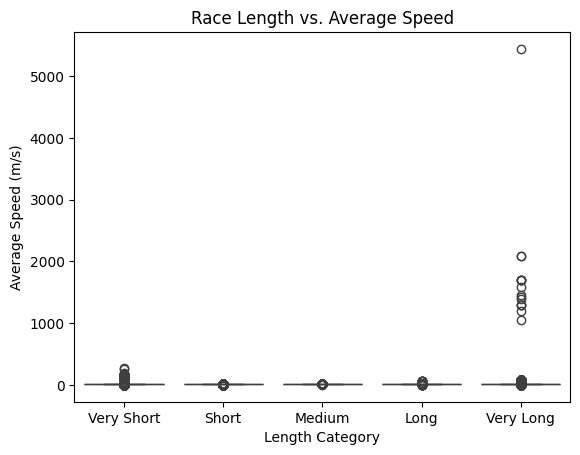

In [98]:
# Create quantile-based bins
races_df['length_category'] = pd.qcut(races_df['length'], q=5, labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'])

# sns.scatterplot(data=races_df, x='length', y='average_speed')
sns.boxplot(data=races_df, x='length_category', y='average_speed')
plt.title('Race Length vs. Average Speed')
plt.xlabel('Length Category')
plt.ylabel('Average Speed (m/s)')
plt.show()

As we can see, shorter races have the highest average speeds.

Now, let's move onto the `steepness` of the races. We try to confront them with the acquired points. Maybe, steeper tracks may provide more points (if the race is more difficult it's reasonable if it's valued more) or less points (being more difficult, the performance of the cyclists is scarcer). We try to check this with a scatterplot, coloring the points based on the `stage_type` to see if we can gain any insight from this analysis.

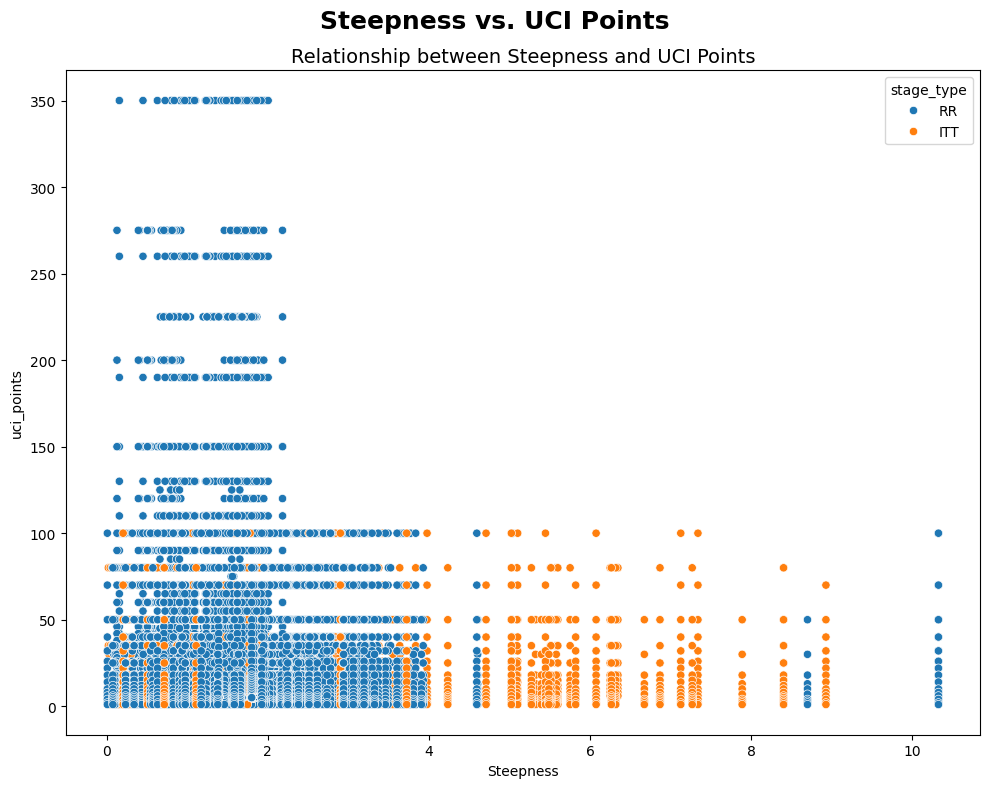

In [99]:
# Analyze the relationship between cyclist_df.bmi and races_df.uci_points.

fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Steepness vs. UCI Points', fontsize=18, fontweight='bold')

sns.scatterplot(data=races_df, x='steepness', y='points', hue='stage_type')
ax.set_title('Relationship between Steepness and UCI Points', fontsize=14)
ax.set_xlabel('Steepness')
ax.set_ylabel('uci_points')

plt.tight_layout()

As we can see, a wider context gives a more comprehensive breadth of analysis. We can see two main things from this plot:
1. Flatter tracks open the possibility to gain a great amount of points.
2. Most Individual Time Trials are ran on medium to high steepness levels. This is probably due to the fact that being them organized on shorter races, the steep sections contribute more to the steepness value of the race.

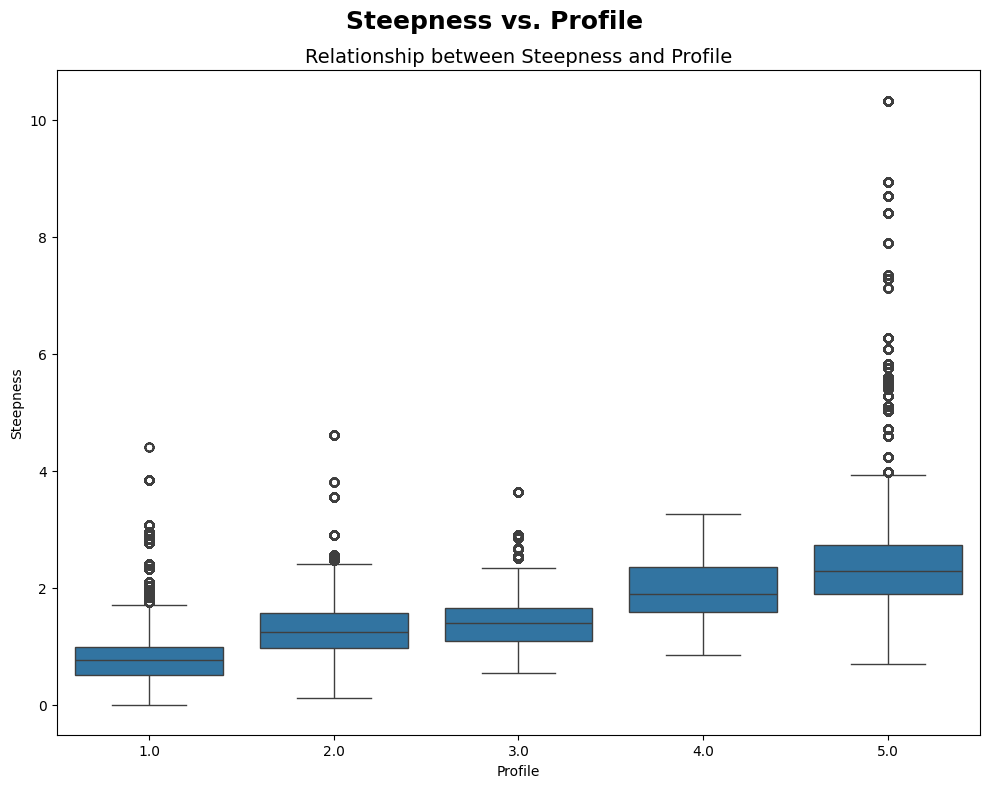

In [100]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Steepness vs. Profile', fontsize=18, fontweight='bold')

sns.boxplot(data=races_df, x='profile', y='steepness', ax=ax)

ax.set_title('Relationship between Steepness and Profile', fontsize=14)
ax.set_xlabel('Profile')
ax.set_ylabel('Steepness')

plt.tight_layout()

As we can see, only the highest steepness values fit into the highest race profiles. Let's check how it influences the average speed

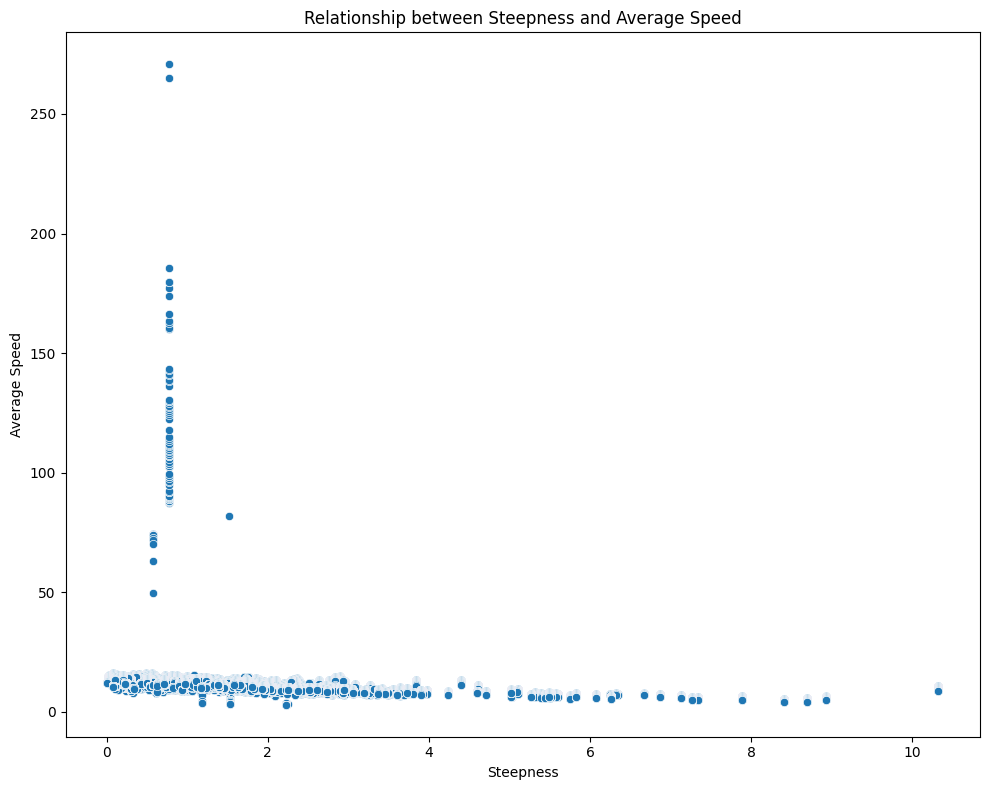

In [101]:
# plot the relationship between steepness and average speed

fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=races_df, x='steepness', y='average_speed', ax=ax)
ax.set_title('Relationship between Steepness and Average Speed')
ax.set_xlabel('Steepness')
ax.set_ylabel('Average Speed')
plt.tight_layout()
plt.show()

Well, seems that steeper tracks make it more difficult to keep an higher speed.

Let's check the stamina index we computed

In [102]:
races_df['stamina_index'].describe()

count    454957.000000
mean          7.672430
std           5.162515
min           0.046740
25%           6.211840
50%           7.432146
75%           8.754109
max         366.622837
Name: stamina_index, dtype: float64

Quite a weird difference between the maximum value and the third quantile. A violinplot might help

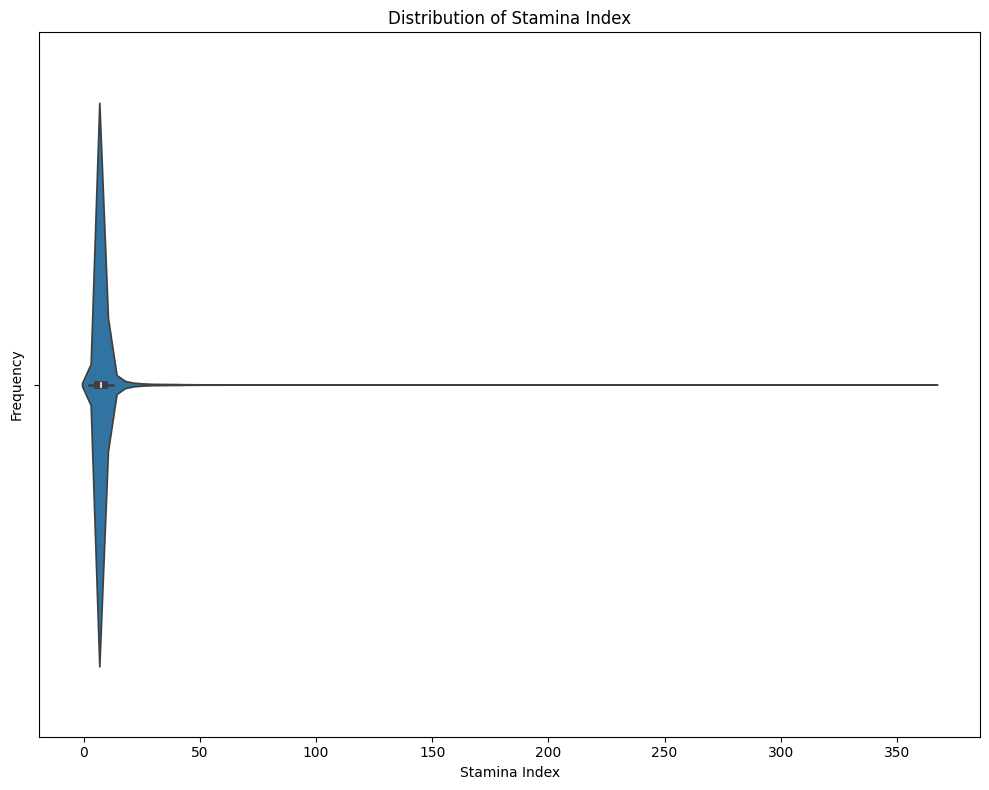

In [103]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.violinplot(data=races_df, x='stamina_index', ax=ax)
ax.set_title('Distribution of Stamina Index')
ax.set_xlabel('Stamina Index')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

What a nice manta ray! Let's check an histogram without the exceptional riders

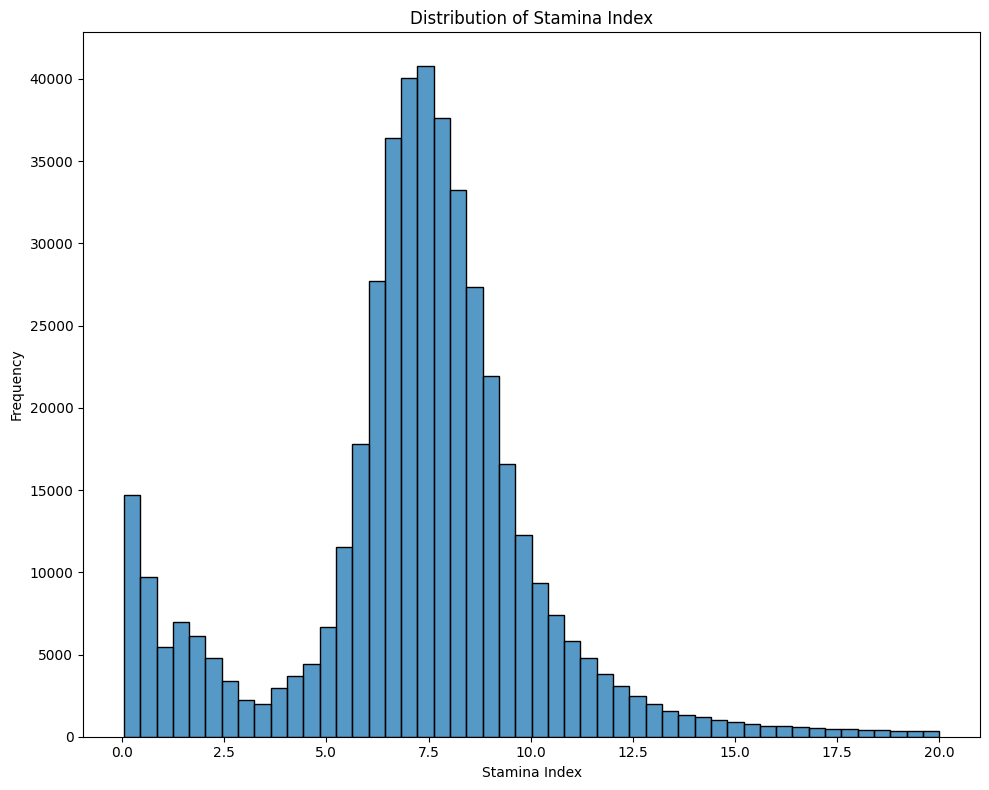

In [104]:
# plot the stamina index

fig, ax = plt.subplots(figsize=(10, 8))
sns.histplot(data=races_df[races_df['stamina_index'] < 20], x='stamina_index', bins=50, kde=False, ax=ax)
ax.set_title('Distribution of Stamina Index')
ax.set_xlabel('Stamina Index')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

Seems like the performances fit a bimodal. The values tending more towards 0 are probably just the molar aggregate of subpar performances (bad positions alongside mediocre groups in flat, small tracks)

Let's compute a mean stamina index for each cyclist.

In [105]:
# compute a mean stamina index for each cyclist

mean_stamina_index = races_df.groupby('cyclist')['stamina_index'].mean().reset_index()

# merge the mean stamina index with cyclist_df
cyclist_df = cyclist_df.merge(mean_stamina_index, how='left', left_on='_url', right_on='cyclist')

In [106]:
cyclist_df['stamina_index'].describe()

count    4703.000000
mean        7.590663
std         2.434010
min         0.179735
25%         6.546939
50%         7.092159
75%         8.021521
max        70.167143
Name: stamina_index, dtype: float64

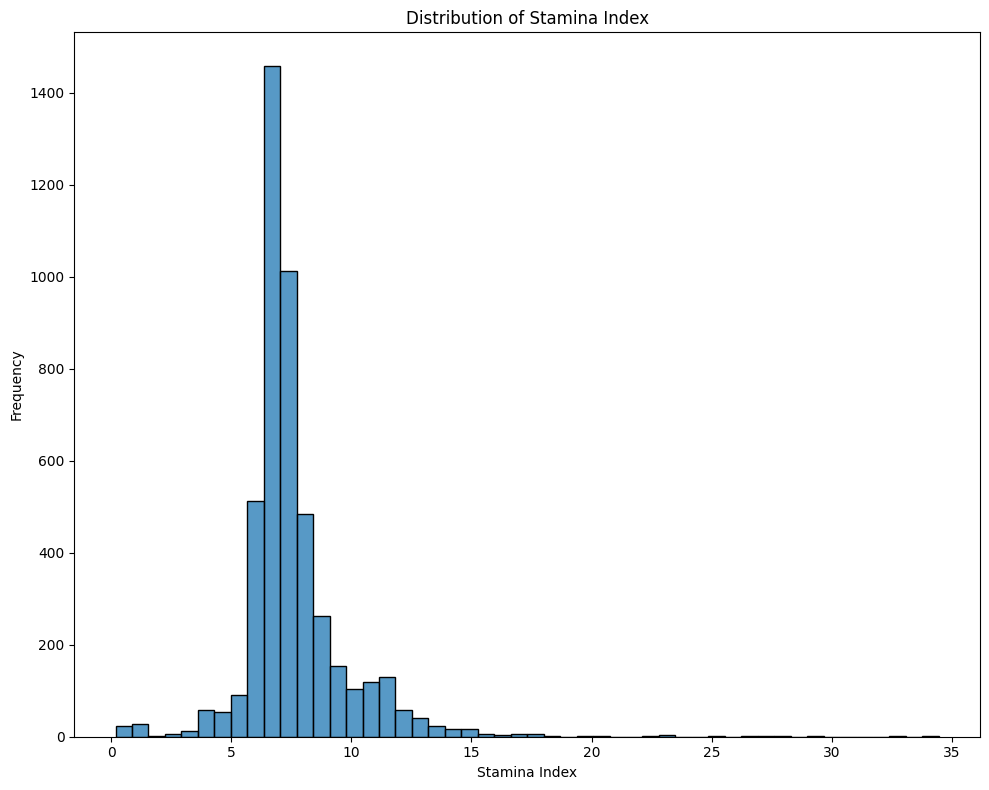

In [107]:
# plot the stamina index

fig, ax = plt.subplots(figsize=(10, 8))
sns.histplot(data=cyclist_df[cyclist_df['stamina_index'] < 40], x='stamina_index', bins=50, kde=False, ax=ax)
ax.set_title('Distribution of Stamina Index')
ax.set_xlabel('Stamina Index')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

As we can see, there is clearly a giant mass of cyclists between 6 and 8. Aside the great deal of people, we have a few exceptional cyclists with a lot of stamina (or nor too many races).

## Dataset cleaning

Here we should copy the cleaning notebook because we have here many added feature that are not in the other notebook but that we need in the final cleaned dataset

The delta has already been discussed in an appropriate notebook so here we'll just report the cleaning process

In [109]:
from utility.dataset_cleaning import delta_based_dataset_cleaning

initial_len = races_df.shape[0]
races_df = delta_based_dataset_cleaning(races_df)
final_len = races_df.shape[0]
print(f"removed lines {-final_len-(-initial_len)}")

removed lines 81591


#### Bad columns

just a reminder of why these are not useful: `is_cobbled` is always false; `is_gravel` is always false; `cyclist_team` can change from year to year and there were some considerations about the fact that the name is just the name of the sponsor (so the team can be the same but with different name); `average_temperature` is almost always null; `Unnamed: 0` is a column created for error during the scraping (because the indices were not dropped).

In [110]:
columns_to_drop = [
    'is_cobbled',
    'is_gravel',
    'cyclist_team',
    'average_temperature',
    #'Unnamed: 0',
]
races_df = races_df.drop(columns=columns_to_drop)
races_df.head()


_url            name    stage stage_type  points  \
0  tour-de-france/1978/stage-6  Tour de France  stage-6         RR   100.0   
1  tour-de-france/1978/stage-6  Tour de France  stage-6         RR    70.0   
2  tour-de-france/1978/stage-6  Tour de France  stage-6         RR    50.0   
3  tour-de-france/1978/stage-6  Tour de France  stage-6         RR    40.0   
4  tour-de-france/1978/stage-6  Tour de France  stage-6         RR    32.0   

   uci_points    length  climb_total  profile  startlist_quality  ...  \
0         NaN  162000.0       1101.0      1.0               1241  ...   
1         NaN  162000.0       1101.0      1.0               1241  ...   
2         NaN  162000.0       1101.0      1.0               1241  ...   
3         NaN  162000.0       1101.0      1.0               1241  ...   
4         NaN  162000.0       1101.0      1.0               1241  ...   

  race_country  norm_points age_performance_index  quality_adjusted_points  \
0       France     2.597540             57.145880              3223.547139   
1       France     1.532004             41.364108              1901.216954   
2       France     0.821647             19.719520              1019.663498   
3       France     0.466468             13.994040               578.886770   
4       France     0.182325              4.922776               226.265387   

   normalized_length  normalized_quality normalized_steepness  \
0            0.47929            6.062531             0.065817   
1            0.47929            6.062531             0.065817   
2            0.47929            6.062531             0.065817   
3            0.47929            6.062531             0.065817   
4            0.47929            6.062531             0.065817   

   normalized_time  stamina_index  length_category  
0         0.207085      41.744580            Short  
1         0.207085      23.827646            Short  
2         0.207085      17.855334            Short  
3         0.207085      14.869178            Short  
4         0.207085      13.077485            Short  

[5 rows x 32 columns]

#### Saving the dataset

In [111]:
races_df.to_csv(os.path.join('dataset', 'races_cleaned.csv'), index=False)
cyclist_df.to_csv(os.path.join('dataset', 'cyclists_cleaned.csv'), index=False)

## Correlations

Now, onto, the correlations!

In [ ]:
merged_df.drop(columns=['norm_points', 'normalized_length', 'normalized_quality', 'normalized_steepness', 'profile_adjustment', 'normalized_time'], inplace=True)

In [ ]:
normalized_dataset, normalization_scalers_dataset = center_and_scale(merged_df)
corr = correlations(normalized_dataset)
corr

birth_year    weight    height       bmi  race_count  \
birth_year                 1.000000 -0.048803  0.084663 -0.162113    0.075368   
weight                    -0.048803  1.000000  0.562259  0.462301   -0.042833   
height                     0.084663  0.562259  1.000000 -0.010594   -0.017339   
bmi                       -0.162113  0.462301 -0.010594  1.000000   -0.042309   
race_count                 0.075368 -0.042833 -0.017339 -0.042309    1.000000   
...                             ...       ...       ...       ...         ...   
steepness                  0.071922 -0.048133 -0.012615 -0.056390    0.030571   
season                    -0.095181 -0.001370 -0.012292  0.009665    0.034463   
age_performance_index      0.046982  0.047063 -0.000749  0.063789    0.054007   
quality_adjusted_points    0.013987  0.066664  0.007324  0.082064    0.042147   
stamina_index             -0.045945 -0.025928 -0.037323  0.001083    0.077271   

                         total_points    points  uci_points    length  \
birth_year                  -0.089351 -0.097800    0.198348 -0.064112   
weight                       0.011991  0.033811    0.019580  0.033074   
height                      -0.064742 -0.032199    0.015617  0.009760   
bmi                          0.084587  0.076261    0.005633  0.036273   
race_count                   0.474431  0.040183   -0.064907 -0.021248   
...                               ...       ...         ...       ...   
steepness                    0.000678  0.028758   -0.008434 -0.109981   
season                       0.042281  0.108628    0.071963 -0.053480   
age_performance_index        0.204396  0.822647    0.497462  0.088272   
quality_adjusted_points      0.197432  0.785026    0.470080  0.020113   
stamina_index                0.176765  0.619530    0.313099  0.823839   

                         climb_total  ...  cyclist_age     delta  \
birth_year                  0.046401  ...    -0.145400  0.077881   
weight                     -0.021358  ...     0.037791  0.071509   
height                     -0.004028  ...    -0.008855  0.057732   
bmi                        -0.026266  ...     0.064869  0.040922   
race_count                  0.024476  ...     0.241153 -0.057398   
...                              ...  ...          ...       ...   
steepness                   0.762462  ...     0.003055  0.550002   
season                      0.068260  ...    -0.010571  0.092351   
age_performance_index       0.010916  ...    -0.096749 -0.232589   
quality_adjusted_points    -0.013135  ...     0.014324 -0.242085   
stamina_index               0.339357  ...     0.011548 -0.225588   

                         time_seconds  average_speed  steepness    season  \
birth_year                  -0.082867       0.064969   0.048096 -0.073991   
weight                       0.038143      -0.005755  -0.032897 -0.001110   
height                       0.010093       0.005320  -0.008609 -0.009803   
bmi                          0.043267      -0.013893  -0.037672  0.007506   
race_count                  -0.034741       0.040841   0.020375  0.026845   
...                               ...            ...        ...       ...   
steepness                    0.183787      -0.674704   1.000000  0.061783   
season                      -0.044443      -0.003785   0.061783  1.000000   
age_performance_index        0.061383       0.061294  -0.029140 -0.026535   
quality_adjusted_points     -0.002076       0.042924  -0.033709 -0.076694   
stamina_index                0.633061       0.068665  -0.122164  0.017188   

                         age_performance_index  quality_adjusted_points  \
birth_year                            0.032995                 0.011606   
weight                                0.032249                 0.046002   
height                               -0.000719                 0.005048   
bmi                                   0.042476                 0.055322   
race_count                            0.036343            

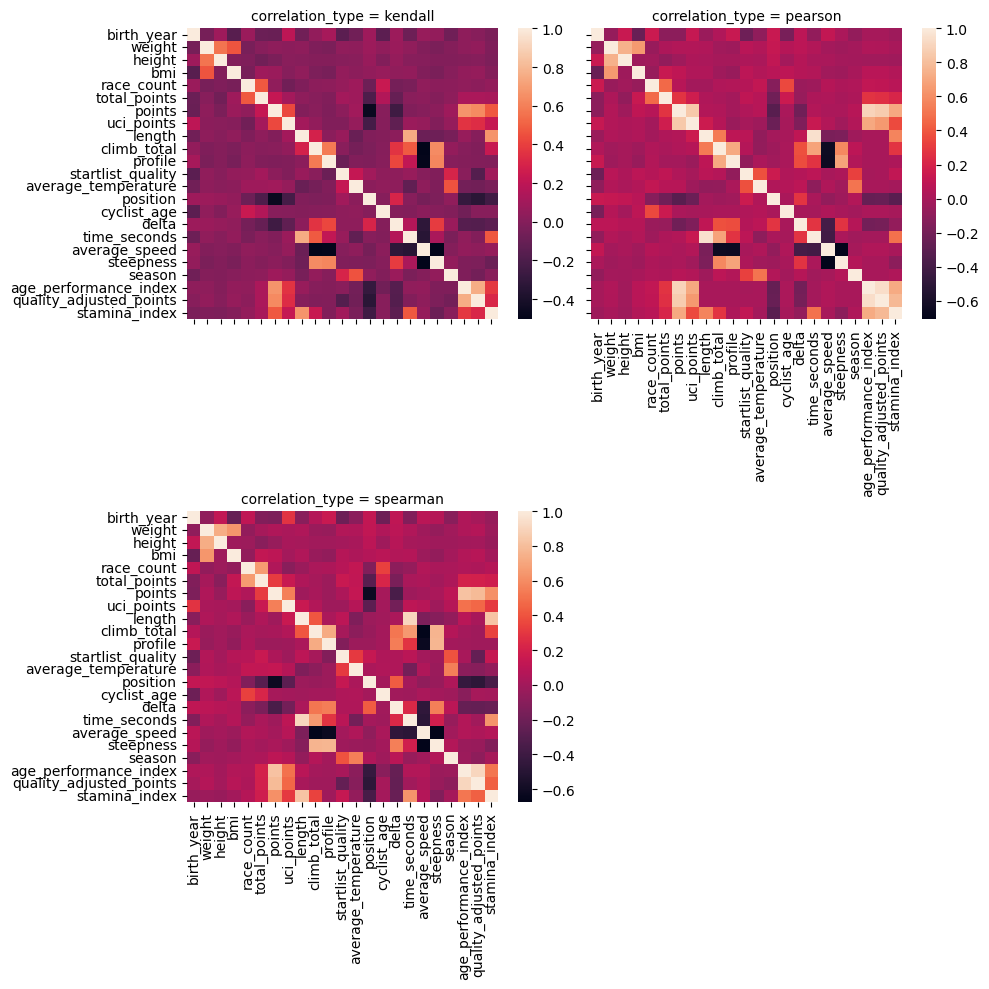

In [ ]:
g = sns.FacetGrid(corr, col="correlation_type", col_wrap=2, height=5, aspect=1)
g.map_dataframe(lambda data, color: sns.heatmap(data[data.columns[:-1]]))

## Rewatch

Let's analyze how some plot changed after all this work

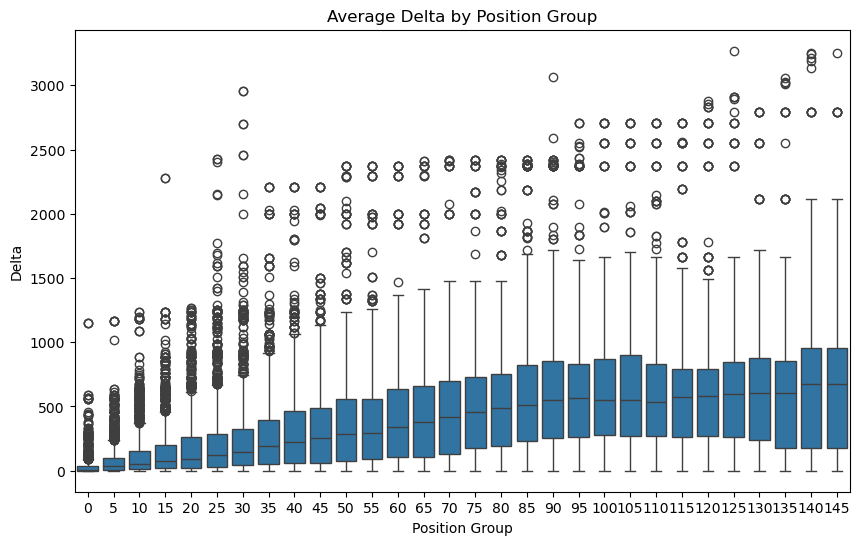

In [ ]:
length_range = (250000, 2500000)  # Example length range in meters
# we still consider a subrange of the races because the delta is much
# influenced by this and so is expected a hig variance if we consider all the races
filtered_df = races_df[(races_df['length'] >= length_range[0]) & (races_df['length'] <= length_range[1])]
filtered_df = filtered_df[(filtered_df['stage_type'] == 'RR') & (filtered_df['stage'] != 'prologue')]
filtered_df = filtered_df[filtered_df['position'] < 150]
# Create a new column 'position_group' that groups positions in intervals of 5
filtered_df = filtered_df.assign(position_group=(filtered_df['position'] // 5) * 5)

# Plot the box plot for the average delta by position group
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_df, x='position_group', y='delta')
plt.title('Average Delta by Position Group')
plt.xlabel('Position Group')
plt.ylabel('Delta')
plt.show()

This is pretty much the same :( But some arbitrary cleaning was already done in the previous version, at least we can say tath this one is more 'theoretically grounded'

Anyway, we can see that the delta increse almost logarithmic, this means (personal interpretation to be discussed) that more or less all the athletes are on the same level